In [1]:
import xarray as xr
import numpy as np
import glob
from netCDF4 import Dataset
import os
import gsw
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import cmocean
from geopy.distance import geodesic
import re

In [3]:
file_path='/users/karolina/Desktop/AREX_netCDF_1996-2024/*/netcdf/*.nc' 
file_list = glob.glob(file_path)

In [5]:
datasets = [xr.open_dataset(fp, chunks={}) for fp in file_list]
print(len(datasets))

5821


In [7]:
max_levels = max(ds.sizes.get('n_levels', 0) for ds in datasets)
print("Max number of n_levels:", max_levels)

Max number of n_levels: 3988


In [9]:
aligned_datasets=[
    ds.pad(n_levels=(0, max_levels-ds.sizes["n_levels"]), constant_values=np.nan)
    if "n_levels" in ds.sizes else ds
    for ds in datasets
]
print(aligned_datasets[:5])

[<xarray.Dataset> Size: 223kB
Dimensions:    (time: 1, n_levels: 3988)
Coordinates:
  * time       (time) datetime64[ns] 8B 1970-01-09T12:17:17.232094907
Dimensions without coordinates: n_levels
Data variables:
    latitude   (time) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    longitude  (time) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    pres       (time, n_levels) float64 32kB dask.array<chunksize=(1, 1907), meta=np.ndarray>
    temp       (time, n_levels) float64 32kB dask.array<chunksize=(1, 1907), meta=np.ndarray>
    cond       (time, n_levels) float64 32kB dask.array<chunksize=(1, 1907), meta=np.ndarray>
    psal       (time, n_levels) float64 32kB dask.array<chunksize=(1, 1907), meta=np.ndarray>
    fluo       (time, n_levels) float64 32kB dask.array<chunksize=(1, 1907), meta=np.ndarray>
    oxy        (time, n_levels) float64 32kB dask.array<chunksize=(1, 1907), meta=np.ndarray>
    oxysat     (time, n_levels) float64 32kB dask.array<chunksize=(1, 1

In [11]:
selected_data = []

for ds in aligned_datasets:
    try:
        
        if 'station_name' in ds:
            station_name = ds['station_name'].values
        elif 'station_name' in ds.attrs:
            station_name = ds.attrs['station_name']
        else:
            station_name = None

        # year from the project year
        if 'project_name' in ds.attrs:
            proj = ds.attrs['project_name']
            match = re.search(r'(\d{4})$', proj)  # getting the year from the end of the name 
            if match:
                year = int(match.group(1))
            else:
                year = np.nan
        else:
            year = np.nan

       
        latitude = float(np.ravel(ds['latitude'])[0]) if 'latitude' in ds else np.nan
        longitude = float(np.ravel(ds['longitude'])[0]) if 'longitude' in ds else np.nan

        
        if 'pres' in ds and ds['pres'].size > 0:
            pres = ds['pres'].values.astype(float)
        else:
            pres = np.nan

    
        if 'temp' in ds and ds['temp'].size > 0:
            temp = ds['temp'].values.astype(float)
        else:
            temp = np.nan

        
        if 'psal' in ds and ds['psal'].size > 0:
            psal = ds['psal'].values.astype(float)
        else:
            psal = np.nan

        
        station_data = {
            'station_name': station_name,
            'year': year,
            'latitude': latitude,
            'longitude': longitude,
            'temp': temp,
            'pres': pres,
            'psal': psal }

        selected_data.append(station_data)

    except Exception as e:
        print(f"Data processing error: {e}")

In [13]:
for i, data in enumerate(selected_data[:5]): 
    print(data)

{'station_name': '   NB12 ', 'year': 2013, 'latitude': 80.86616666666667, 'longitude': 15.836166666666667, 'temp': array([[4.0555, 4.0538, 4.0517, ...,    nan,    nan,    nan]]), 'pres': array([[ 1.,  2.,  3., ..., nan, nan, nan]]), 'psal': array([[34.224 , 34.2253, 34.2249, ...,     nan,     nan,     nan]])}
{'station_name': '   Z13 ', 'year': 2013, 'latitude': 78.09433333333334, 'longitude': 5.0056666666666665, 'temp': array([[5.4279, 5.4257, 5.4282, ...,    nan,    nan,    nan]]), 'pres': array([[ 3.,  4.,  5., ..., nan, nan, nan]]), 'psal': array([[34.9854, 34.9854, 34.9855, ...,     nan,     nan,     nan]])}
{'station_name': '   A12 ', 'year': 2013, 'latitude': 71.478, 'longitude': 8.474, 'temp': array([[8.7333, 8.7362, 8.733 , ...,    nan,    nan,    nan]]), 'pres': array([[ 2.,  3.,  4., ..., nan, nan, nan]]), 'psal': array([[35.1581, 35.1588, 35.1596, ...,     nan,     nan,     nan]])}
{'station_name': '   O-2 ', 'year': 2013, 'latitude': 75.966, 'longitude': 14.343833333333333

In [15]:
years = sorted({entry['year'] for entry in selected_data})
print(years)

[1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [17]:
for i, data in enumerate(selected_data[:5]): 
    print(f"  Stacja {i+1}:")
    print(f"  Nazwa: {data['station_name']}")
    print(f"  Rok: {data['year']}")
    print(f"  Szerokość geograficzna: {data['latitude']}")
    print(f"  Długość geograficzna: {data['longitude']}")
    print(f"  Salinity (psal): {data['psal'][:5]} ...")  
    print(f"  Temperature (temp): {data['temp'][:5]} ...") 
    print("-" * 50)

  Stacja 1:
  Nazwa:    NB12 
  Rok: 2013
  Szerokość geograficzna: 80.86616666666667
  Długość geograficzna: 15.836166666666667
  Salinity (psal): [[34.224  34.2253 34.2249 ...     nan     nan     nan]] ...
  Temperature (temp): [[4.0555 4.0538 4.0517 ...    nan    nan    nan]] ...
--------------------------------------------------
  Stacja 2:
  Nazwa:    Z13 
  Rok: 2013
  Szerokość geograficzna: 78.09433333333334
  Długość geograficzna: 5.0056666666666665
  Salinity (psal): [[34.9854 34.9854 34.9855 ...     nan     nan     nan]] ...
  Temperature (temp): [[5.4279 5.4257 5.4282 ...    nan    nan    nan]] ...
--------------------------------------------------
  Stacja 3:
  Nazwa:    A12 
  Rok: 2013
  Szerokość geograficzna: 71.478
  Długość geograficzna: 8.474
  Salinity (psal): [[35.1581 35.1588 35.1596 ...     nan     nan     nan]] ...
  Temperature (temp): [[8.7333 8.7362 8.733  ...    nan    nan    nan]] ...
--------------------------------------------------
  Stacja 4:
  Nazwa: 

In [19]:
!conda install gsw --channel conda-forge -y # TEOS-10

Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.



In [21]:
def calculate_SA_CT(data, n_levels):   #ravel: flattens a NumPy array- converts a multi-dimensional array (e.g., a matrix) into a one-dimensional vector
    SP = np.ravel(data['psal'])         
    t = np.ravel(data['temp'])         
    p = np.ravel(data['pres'])
    longitude = float(np.ravel(data['longitude'])[0])
    latitude = float(np.ravel(data['latitude'])[0])
    
    try:
        SA = gsw.SA_from_SP(SP, p, longitude, latitude)
        
        CT = gsw.CT_from_t(SA, t, p)

        depth = n_levels

        data['SA'] = SA
        data['CT'] = CT
        data['pres'] = p
        data['depth'] = depth
    except Exception as e:
        print(f"Error in calculations: {data['station_name']}: {e}")
        data['SA'] = None
        data['CT'] = None
        data['pres'] = None
        data['depth'] = None
        
    return data


processed_data = [calculate_SA_CT(station, n_levels) 
                  for station, n_levels in zip(selected_data, [ds['n_levels'].values for ds in datasets])]

# Conversion to DataFrame
df = pd.DataFrame(processed_data)
df.index = df.index + 1


print(df[['station_name', 'SA', 'CT', 'pres', 'depth']])

     station_name                                                 SA  \
1           NB12   [34.38715881927579, 34.388466900366524, 34.388...   
2            Z13   [35.15225710251249, 35.152258466785725, 35.152...   
3            A12   [35.32537225766071, 35.3260784285569, 35.32688...   
4            O-2   [35.18029640553261, 35.180700889153584, 35.180...   
5             V4   [34.12358832868736, 34.12489613238961, 34.1262...   
...           ...                                                ...   
5817          H3   [35.29887663439905, 35.299683463950814, 35.299...   
5818         S14   [35.121283539948294, 35.12178821288701, 35.121...   
5819         V27   [34.79845150506925, 34.78901199890856, 34.7894...   
5820         K11   [35.27813375678316, 35.27833453416102, 35.2781...   
5821         X11   [33.358127916755215, 33.359942273270285, 33.35...   

                                                     CT  \
1     [4.058147875649834, 4.0563666186574485, 4.0542...   
2     [5.42109009

In [23]:
years = range(1996, 2025)

stations_N_by_year = {}

for year in years:

    # Filtrowanie stacji N 
    stations_N_sorted = df[
        (df['year'] == year) &
        (df['station_name'].str.strip().str.startswith("N")) &
        (~df['station_name'].str.strip().str[1].str.upper().eq("B")) &
        (~df['station_name'].str.strip().str.startswith("NP"))
    ].copy()

    # Usunięcie braku współrzędnych
    stations_N_sorted = stations_N_sorted.dropna(
        subset=['latitude', 'longitude']
    )

    if stations_N_sorted.empty:
        print(f"Brak stacji 'N' w {year}")
        continue

    # Sortowanie po długości geograficznej
    stations_N_sorted = stations_N_sorted.sort_values(
        by="longitude",
        ascending=True
    )

    
    stations_N_sorted['max_depth'] = stations_N_sorted['depth'].apply(max)

    # N3- reference station
    ref_station = stations_N_sorted[
        stations_N_sorted['station_name']
        .str.strip()
        .str.startswith("N3")
    ]

    if ref_station.empty:
        print(f"Brak stacji N3 w {year}")
        continue

    first_station = ref_station.iloc[0]

    ref_coords = (
        first_station['latitude'],
        first_station['longitude']
    )

    print(f"\nRok {year} – Reference station: N3")
    print(
        f"{first_station['station_name']} "
        f"(max_depth = {first_station['max_depth']} m)"
    )

    # Dystans względem N3
    stations_N_sorted['distance_km'] = stations_N_sorted.apply(
        lambda row: geodesic(
            ref_coords,
            (row['latitude'], row['longitude'])
        ).kilometers
        * (1 if row['longitude'] >= ref_coords[1] else -1),
        axis=1
    )

    # Sortowanie względem N3 
    stations_all = stations_N_sorted.sort_values("distance_km")

    # Do słownika
    stations_N_by_year[year] = stations_all


    print("\nStacje względem N3:")

    print(
        stations_all[
            [
                'station_name',
                'max_depth',
                'longitude',
                'latitude',
                'distance_km'
            ]
        ].to_string(index=False)
    )


Rok 1996 – Reference station: N3
N3  (max_depth = 765 m)

Stacje względem N3:
station_name  max_depth  longitude  latitude  distance_km
       N-10        1487        5.0      76.5  -234.398858
        N-9        1501        5.5      76.5  -221.399960
        N-8        1512        6.0      76.5  -208.397076
        N-7        1502        6.5      76.5  -195.390439
        N-6        1516        7.0      76.5  -182.380284
        N-5        1566        7.5      76.5  -169.366845
        N-4        1551        8.0      76.5  -156.350356
        N-3        1502        8.5      76.5  -143.331053
        N-2        1554        9.0      76.5  -130.309169
        N-1        1536       10.0      76.5  -104.258597
         N0        1490       11.0      76.5   -78.200517
         N1        1537       12.0      76.5   -52.136807
        N1P        1552       12.5      76.5   -39.103426
         N2        1546       13.0      76.5   -26.069342
        N2P        1258       13.5      76.5   -13.

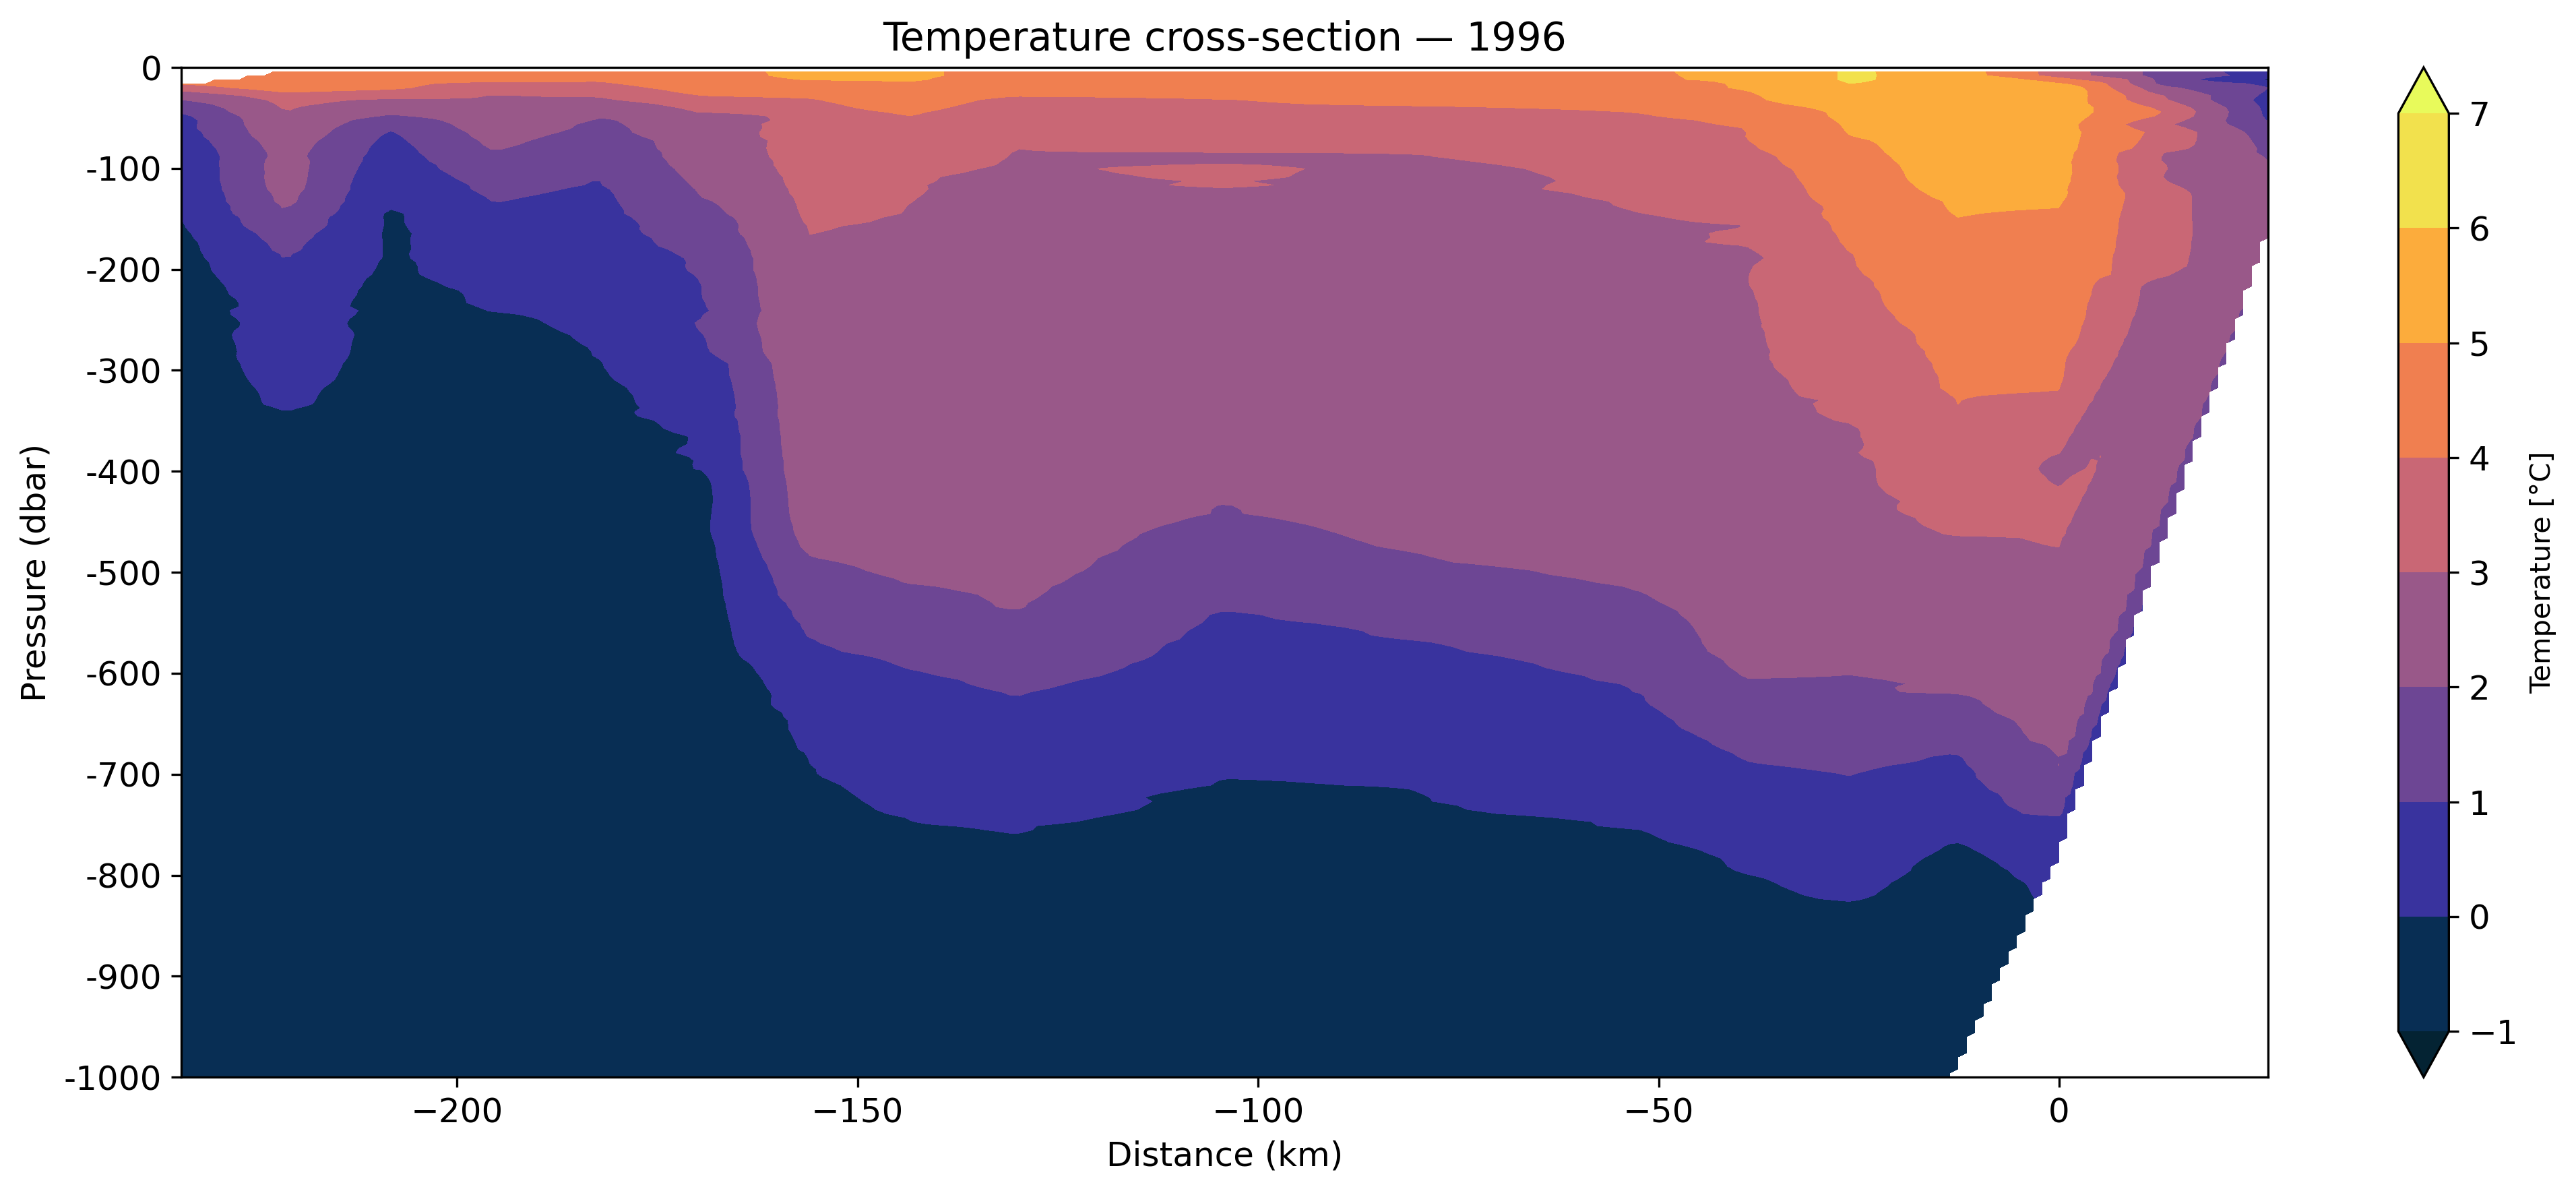

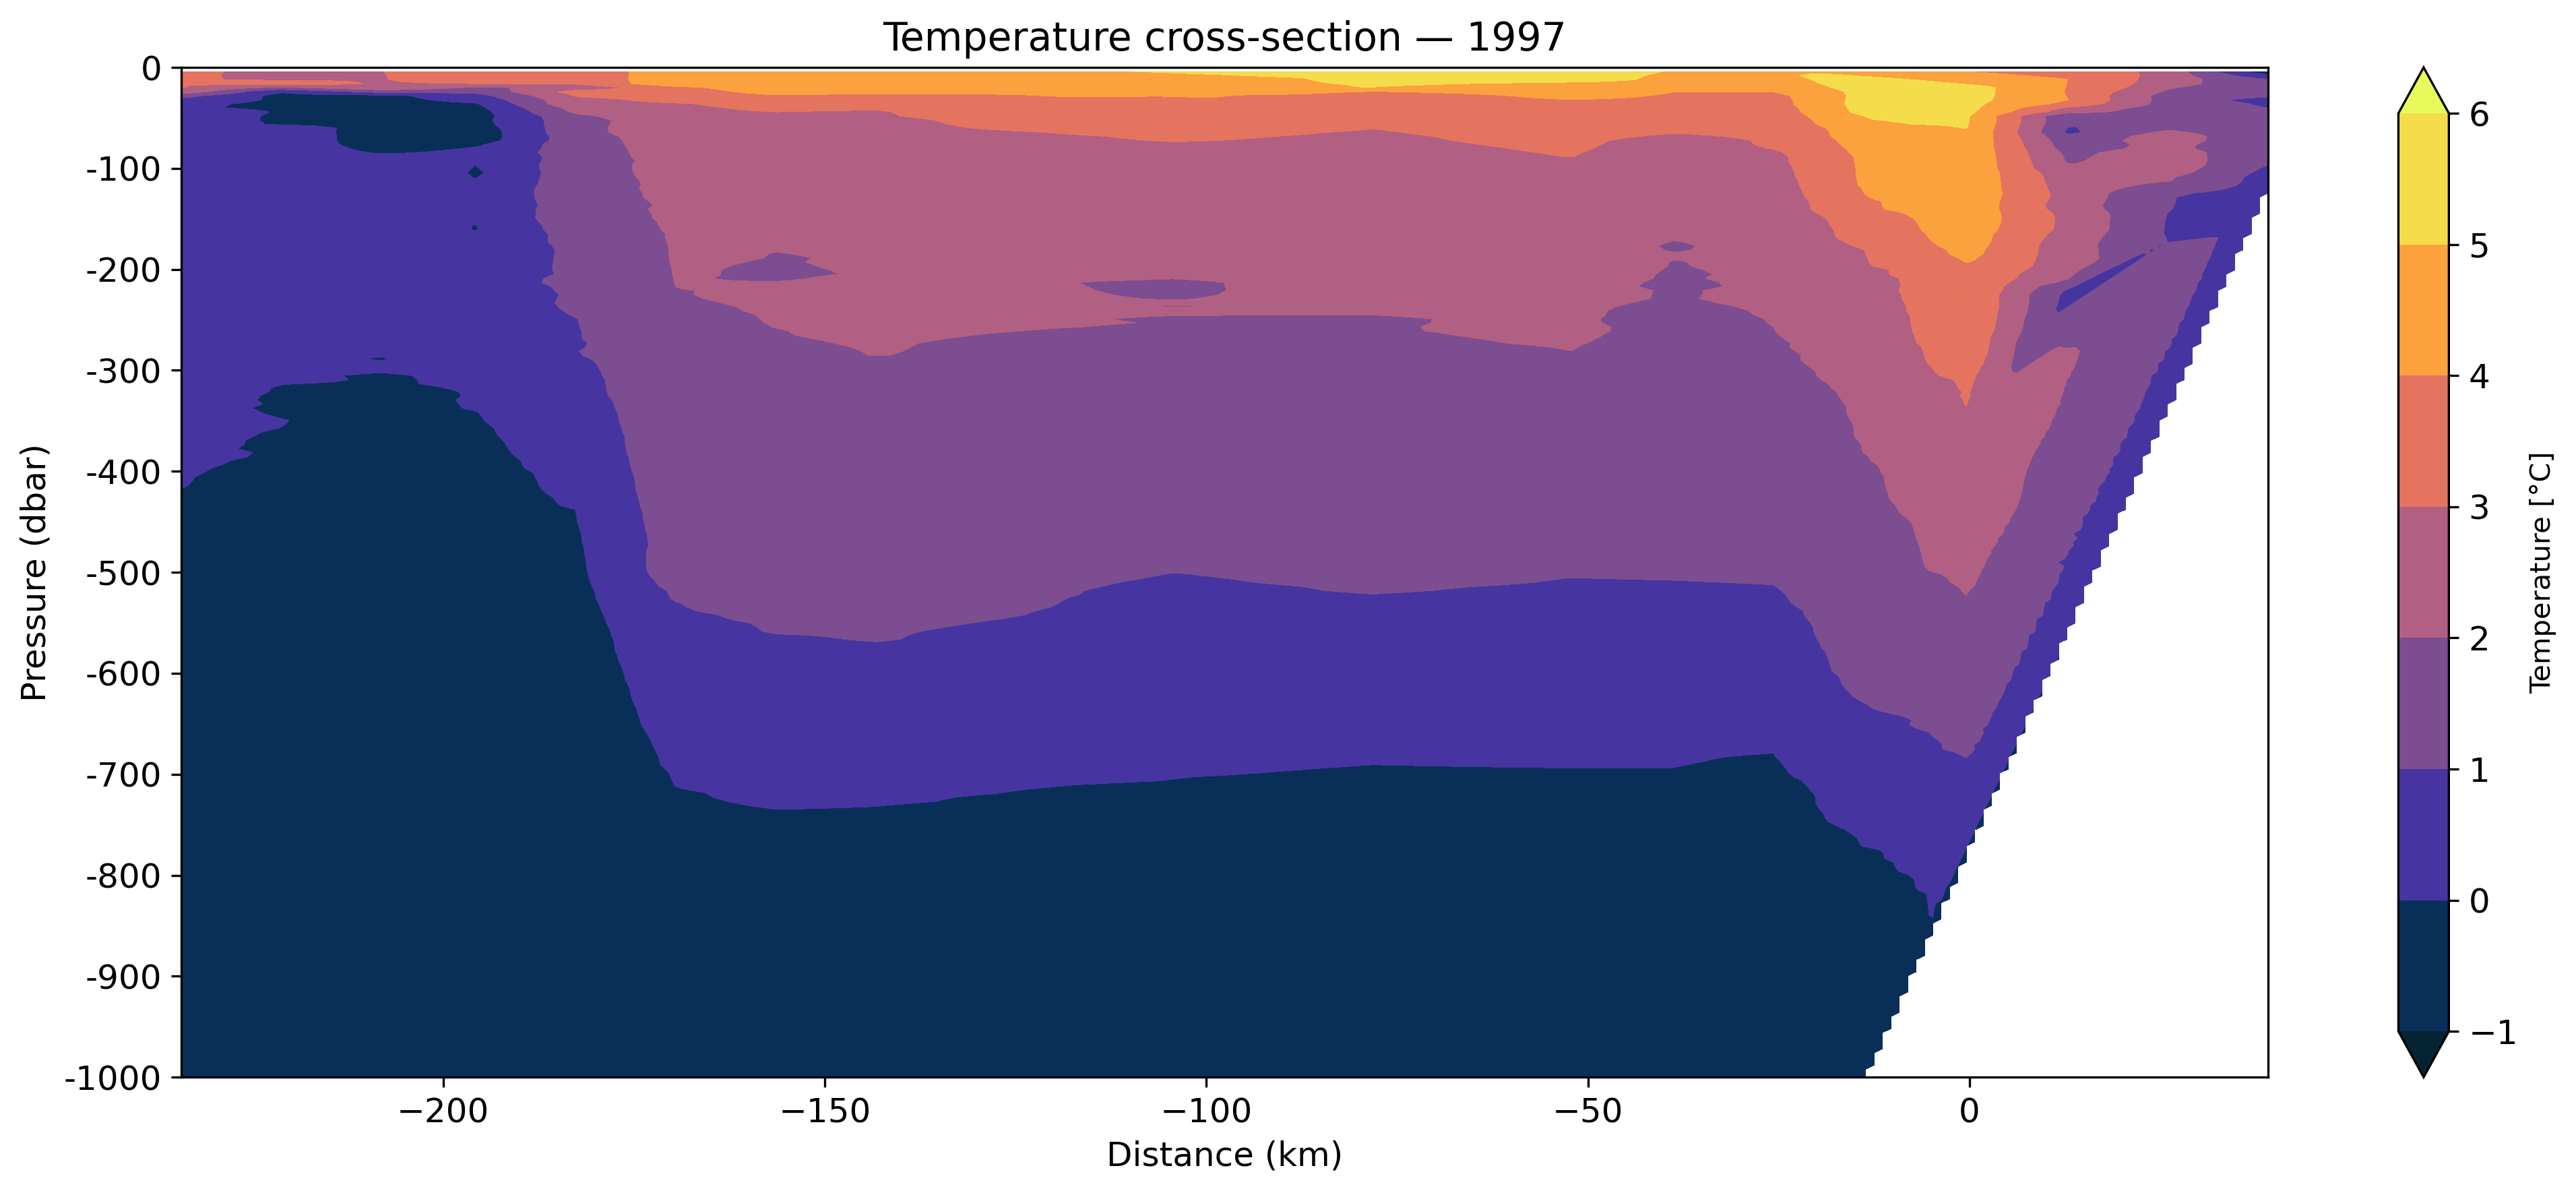

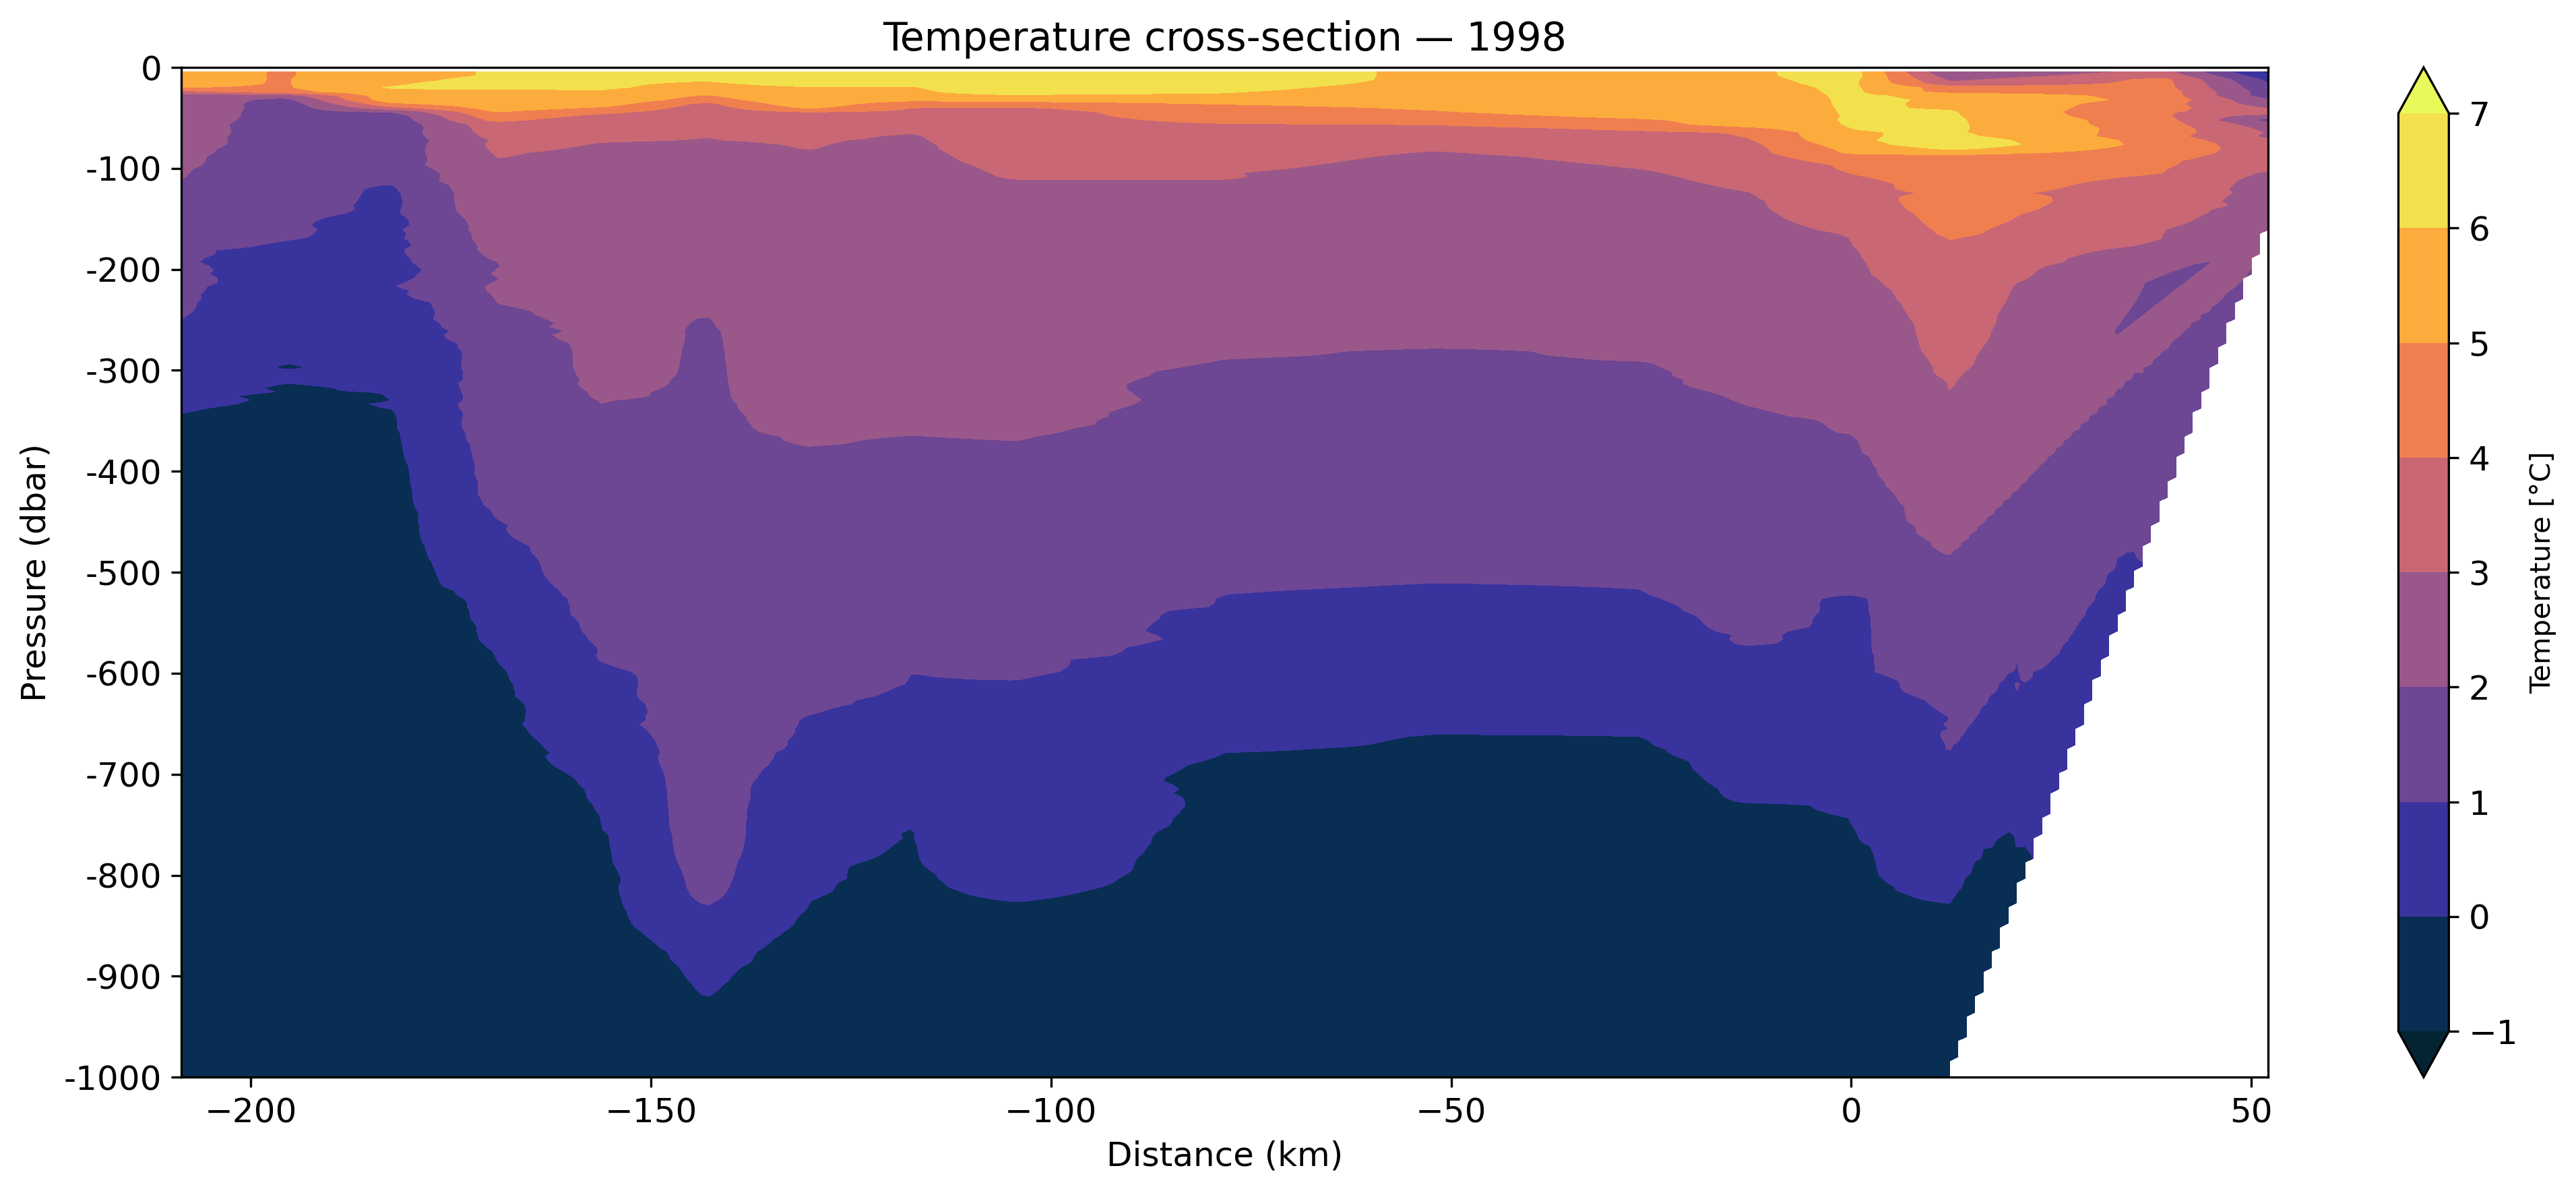

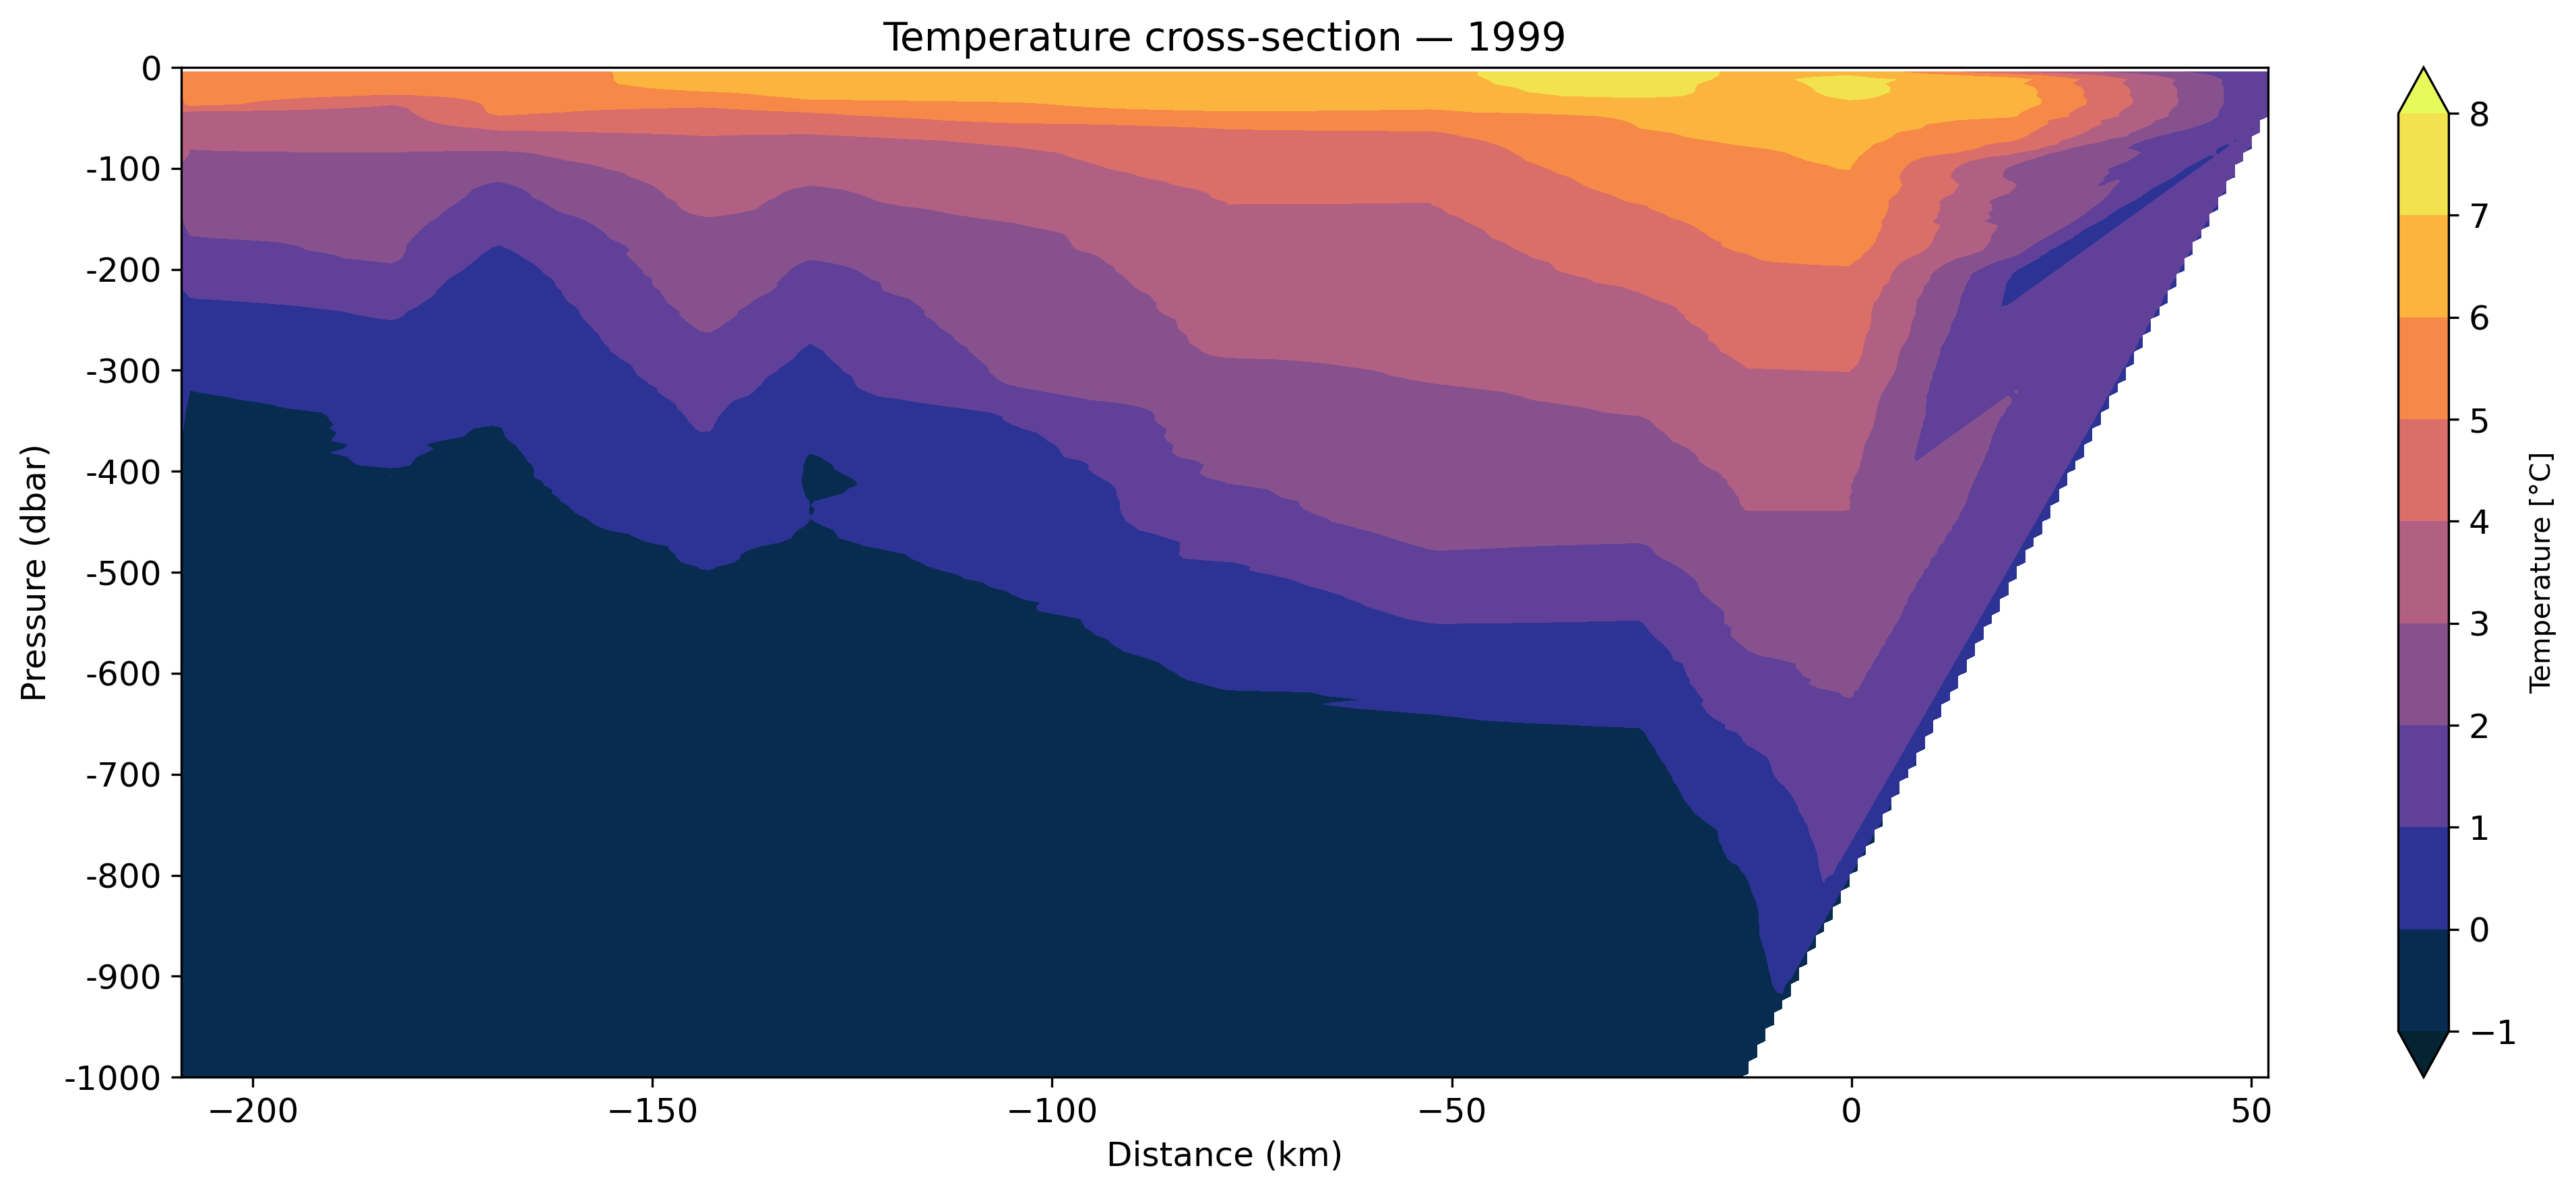

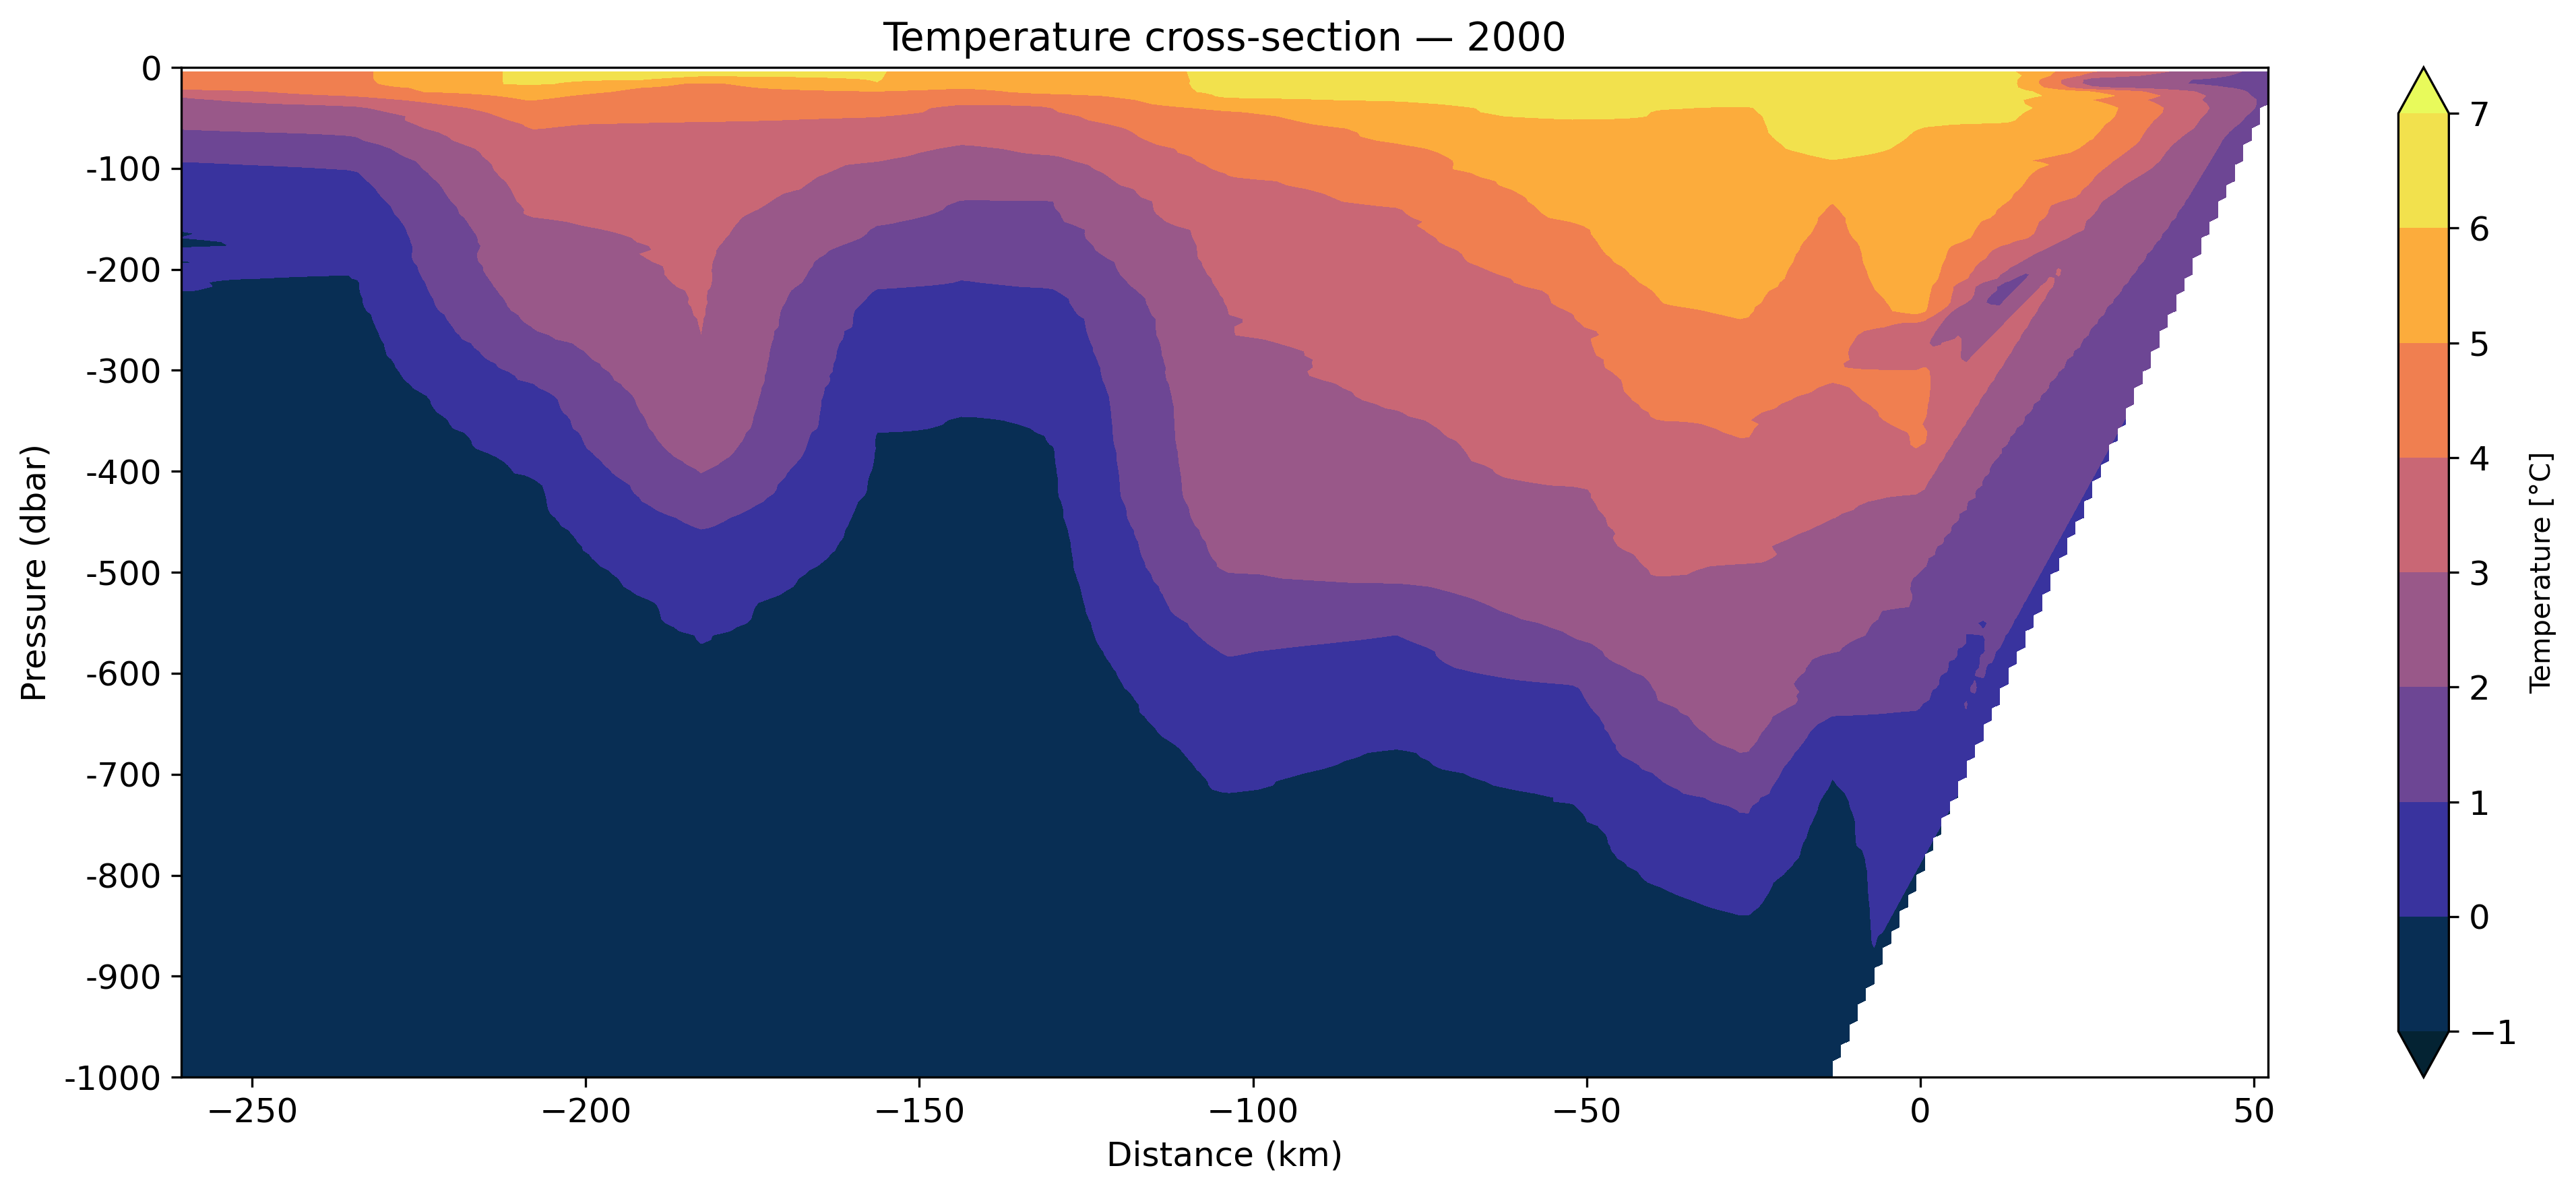

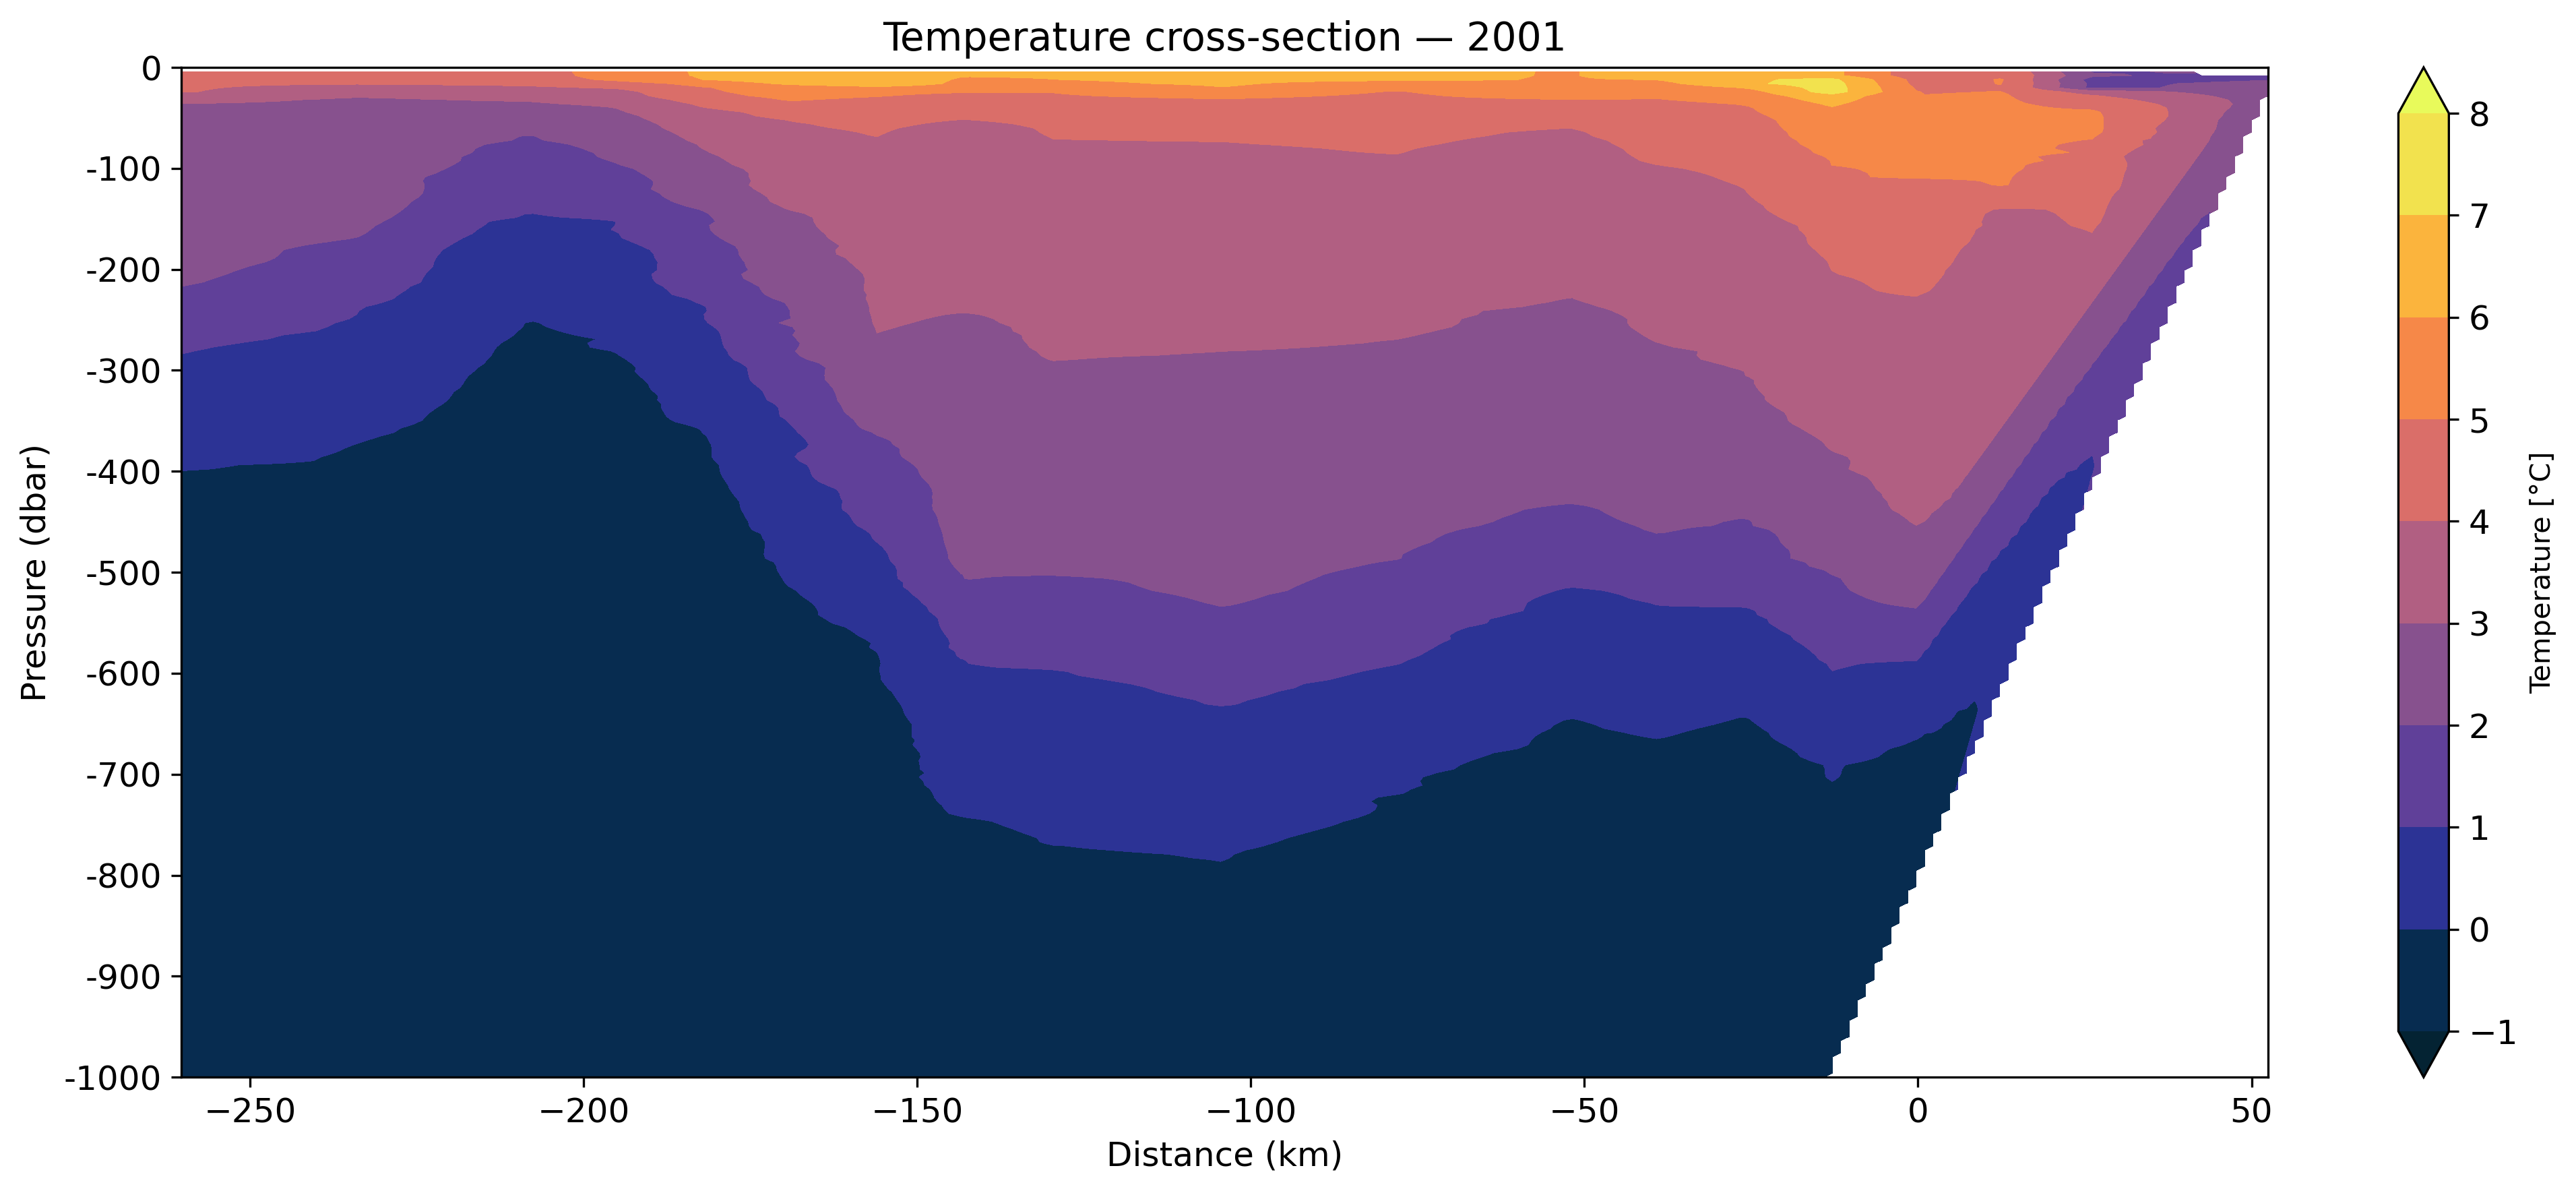

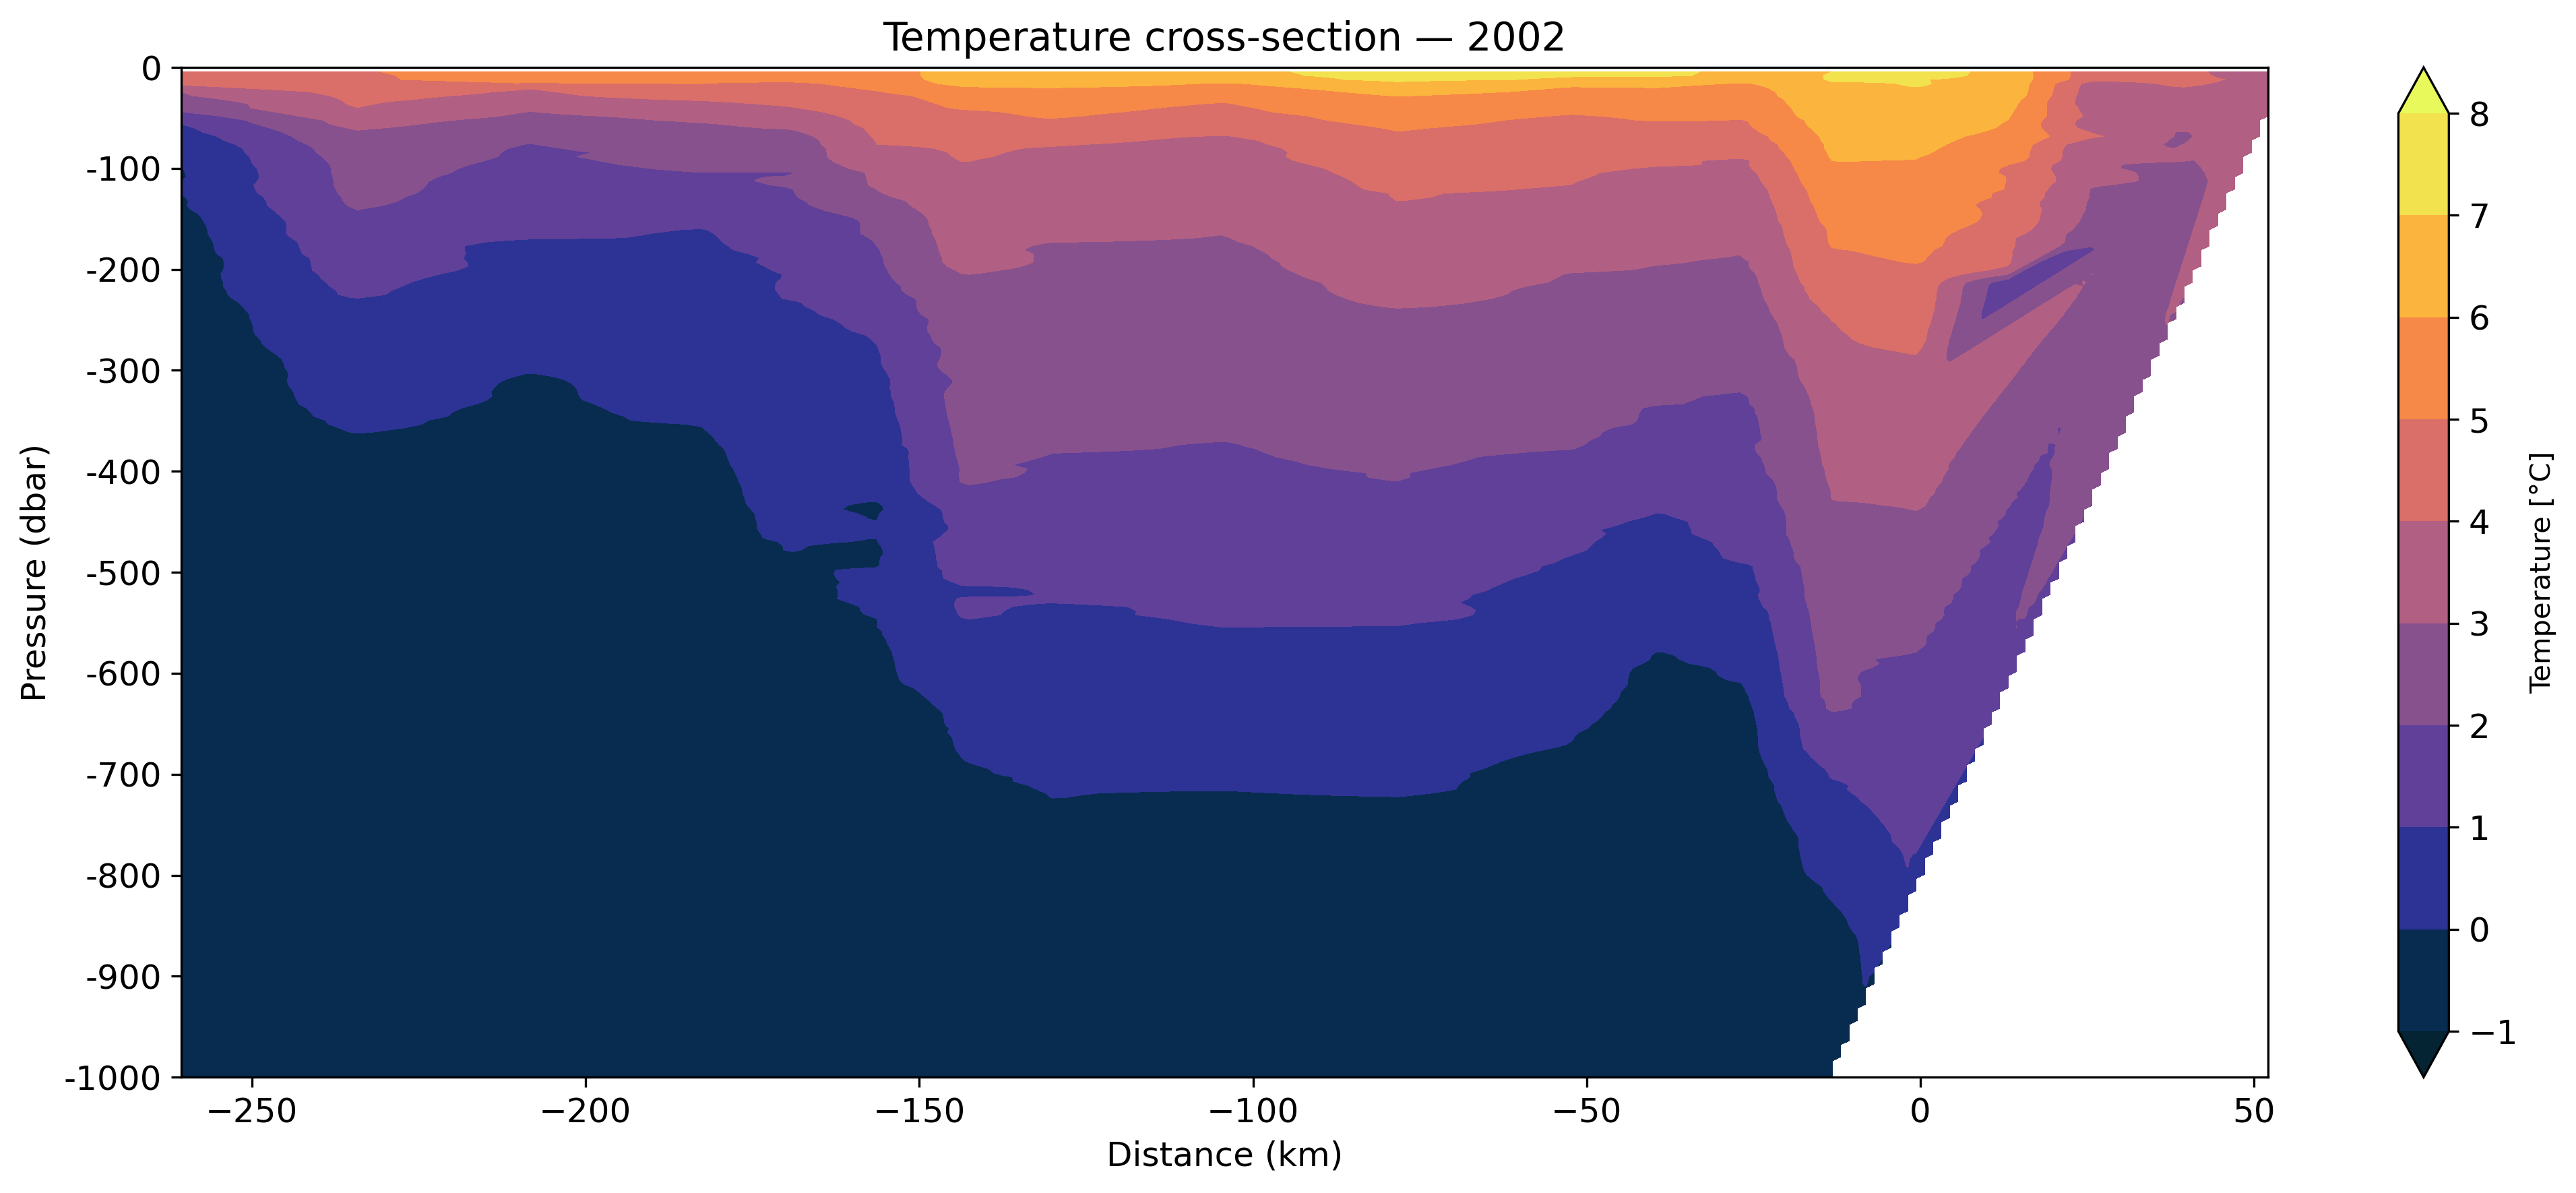

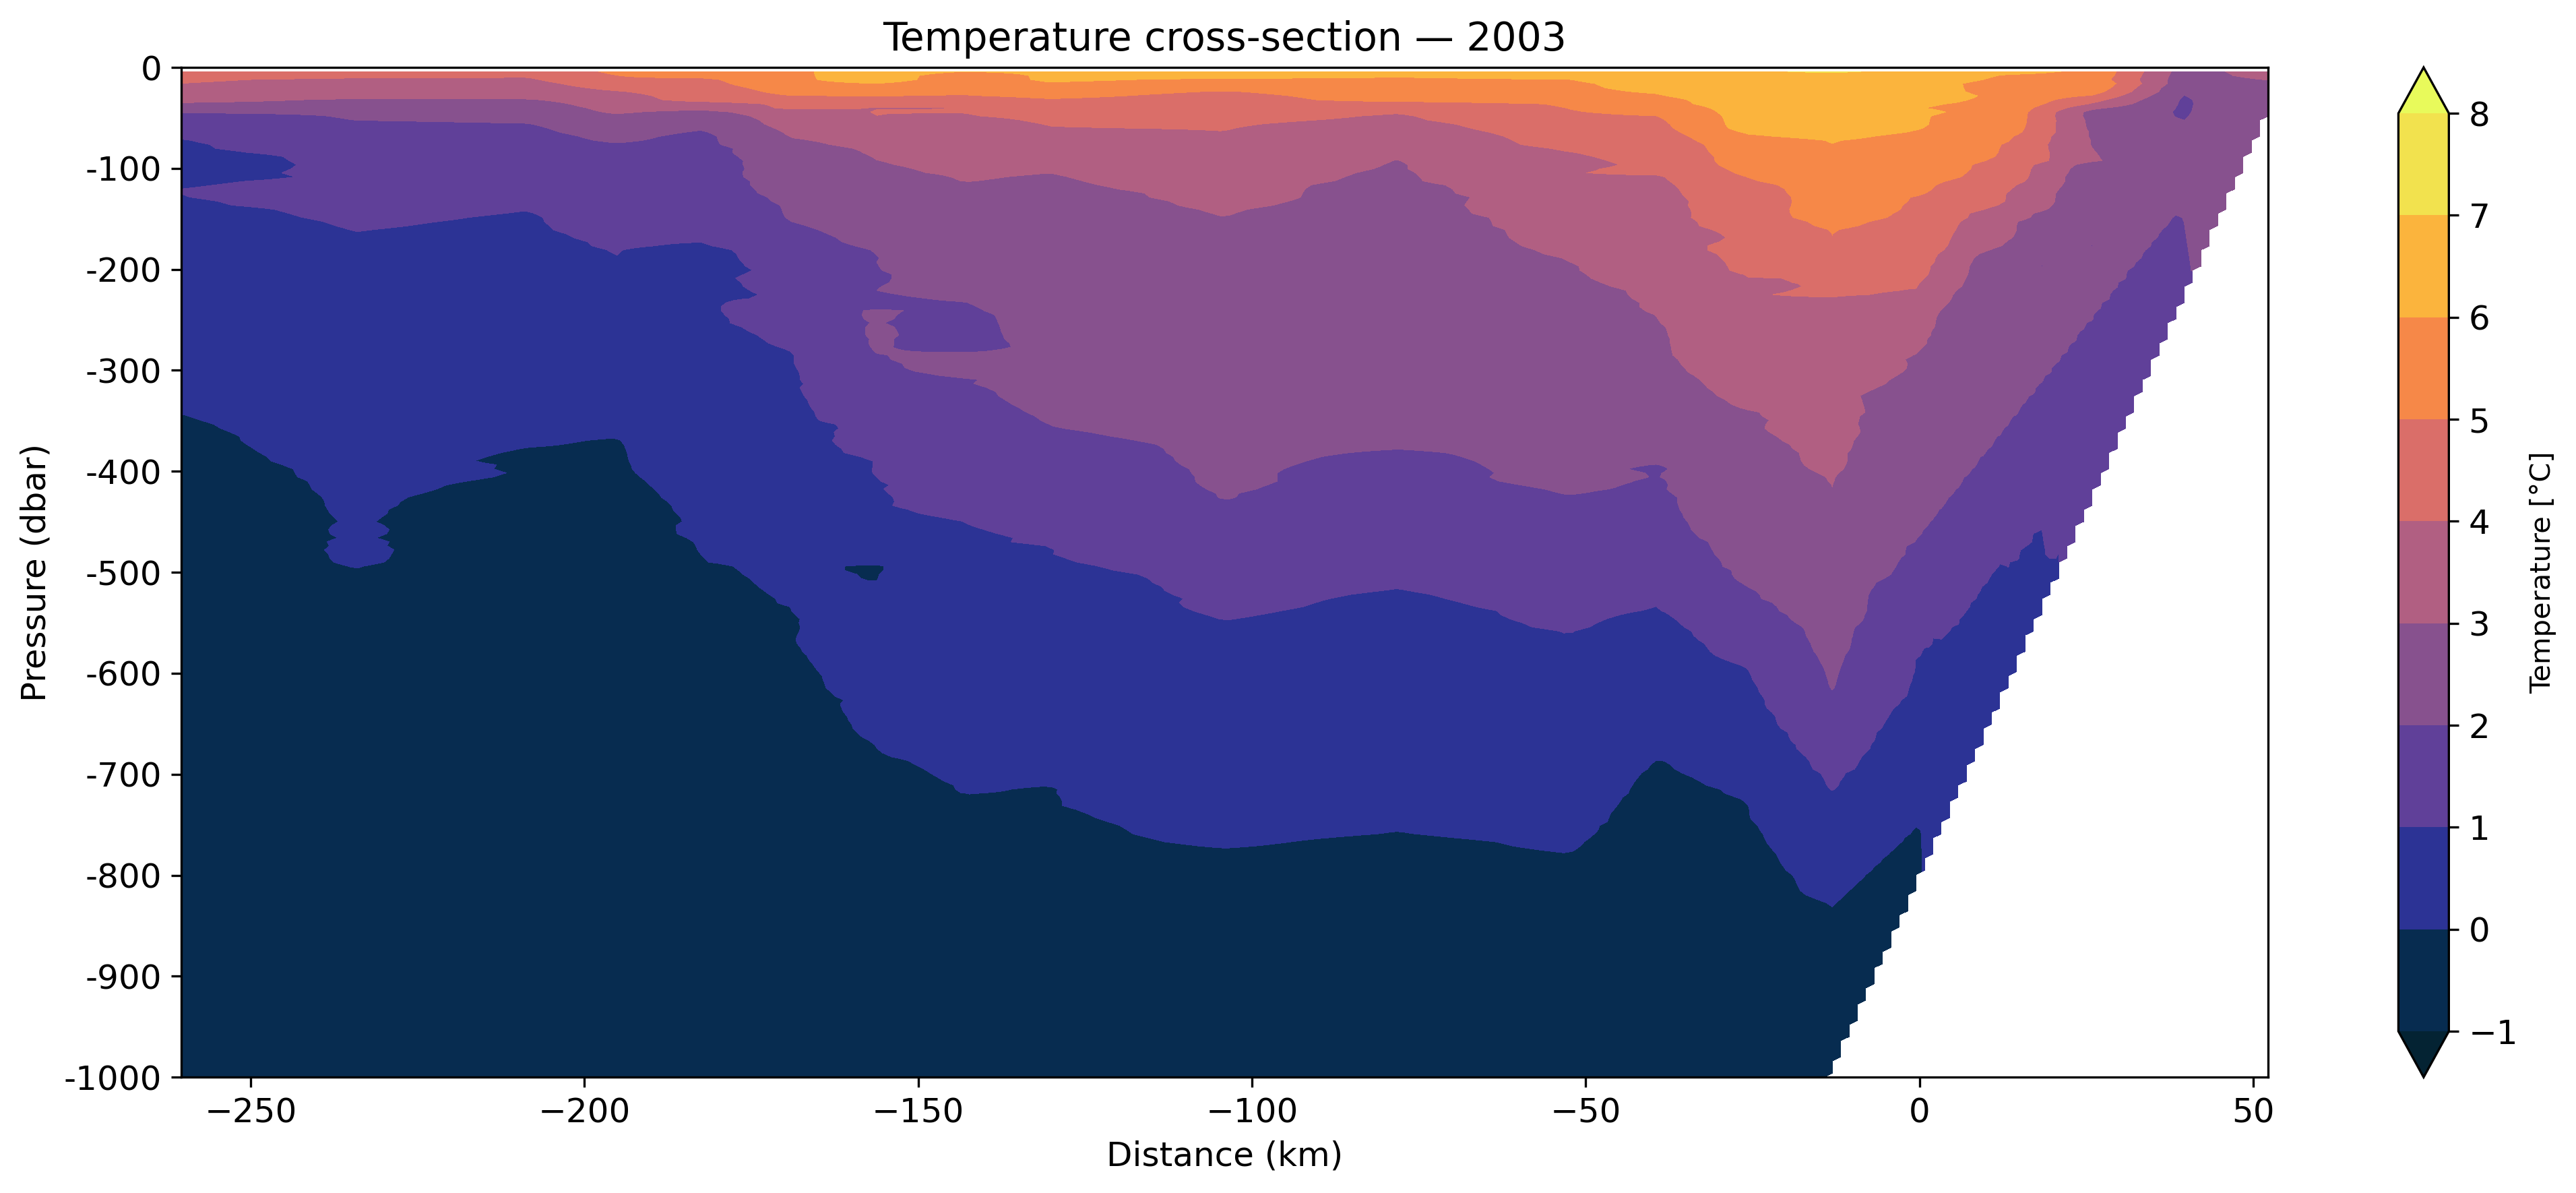

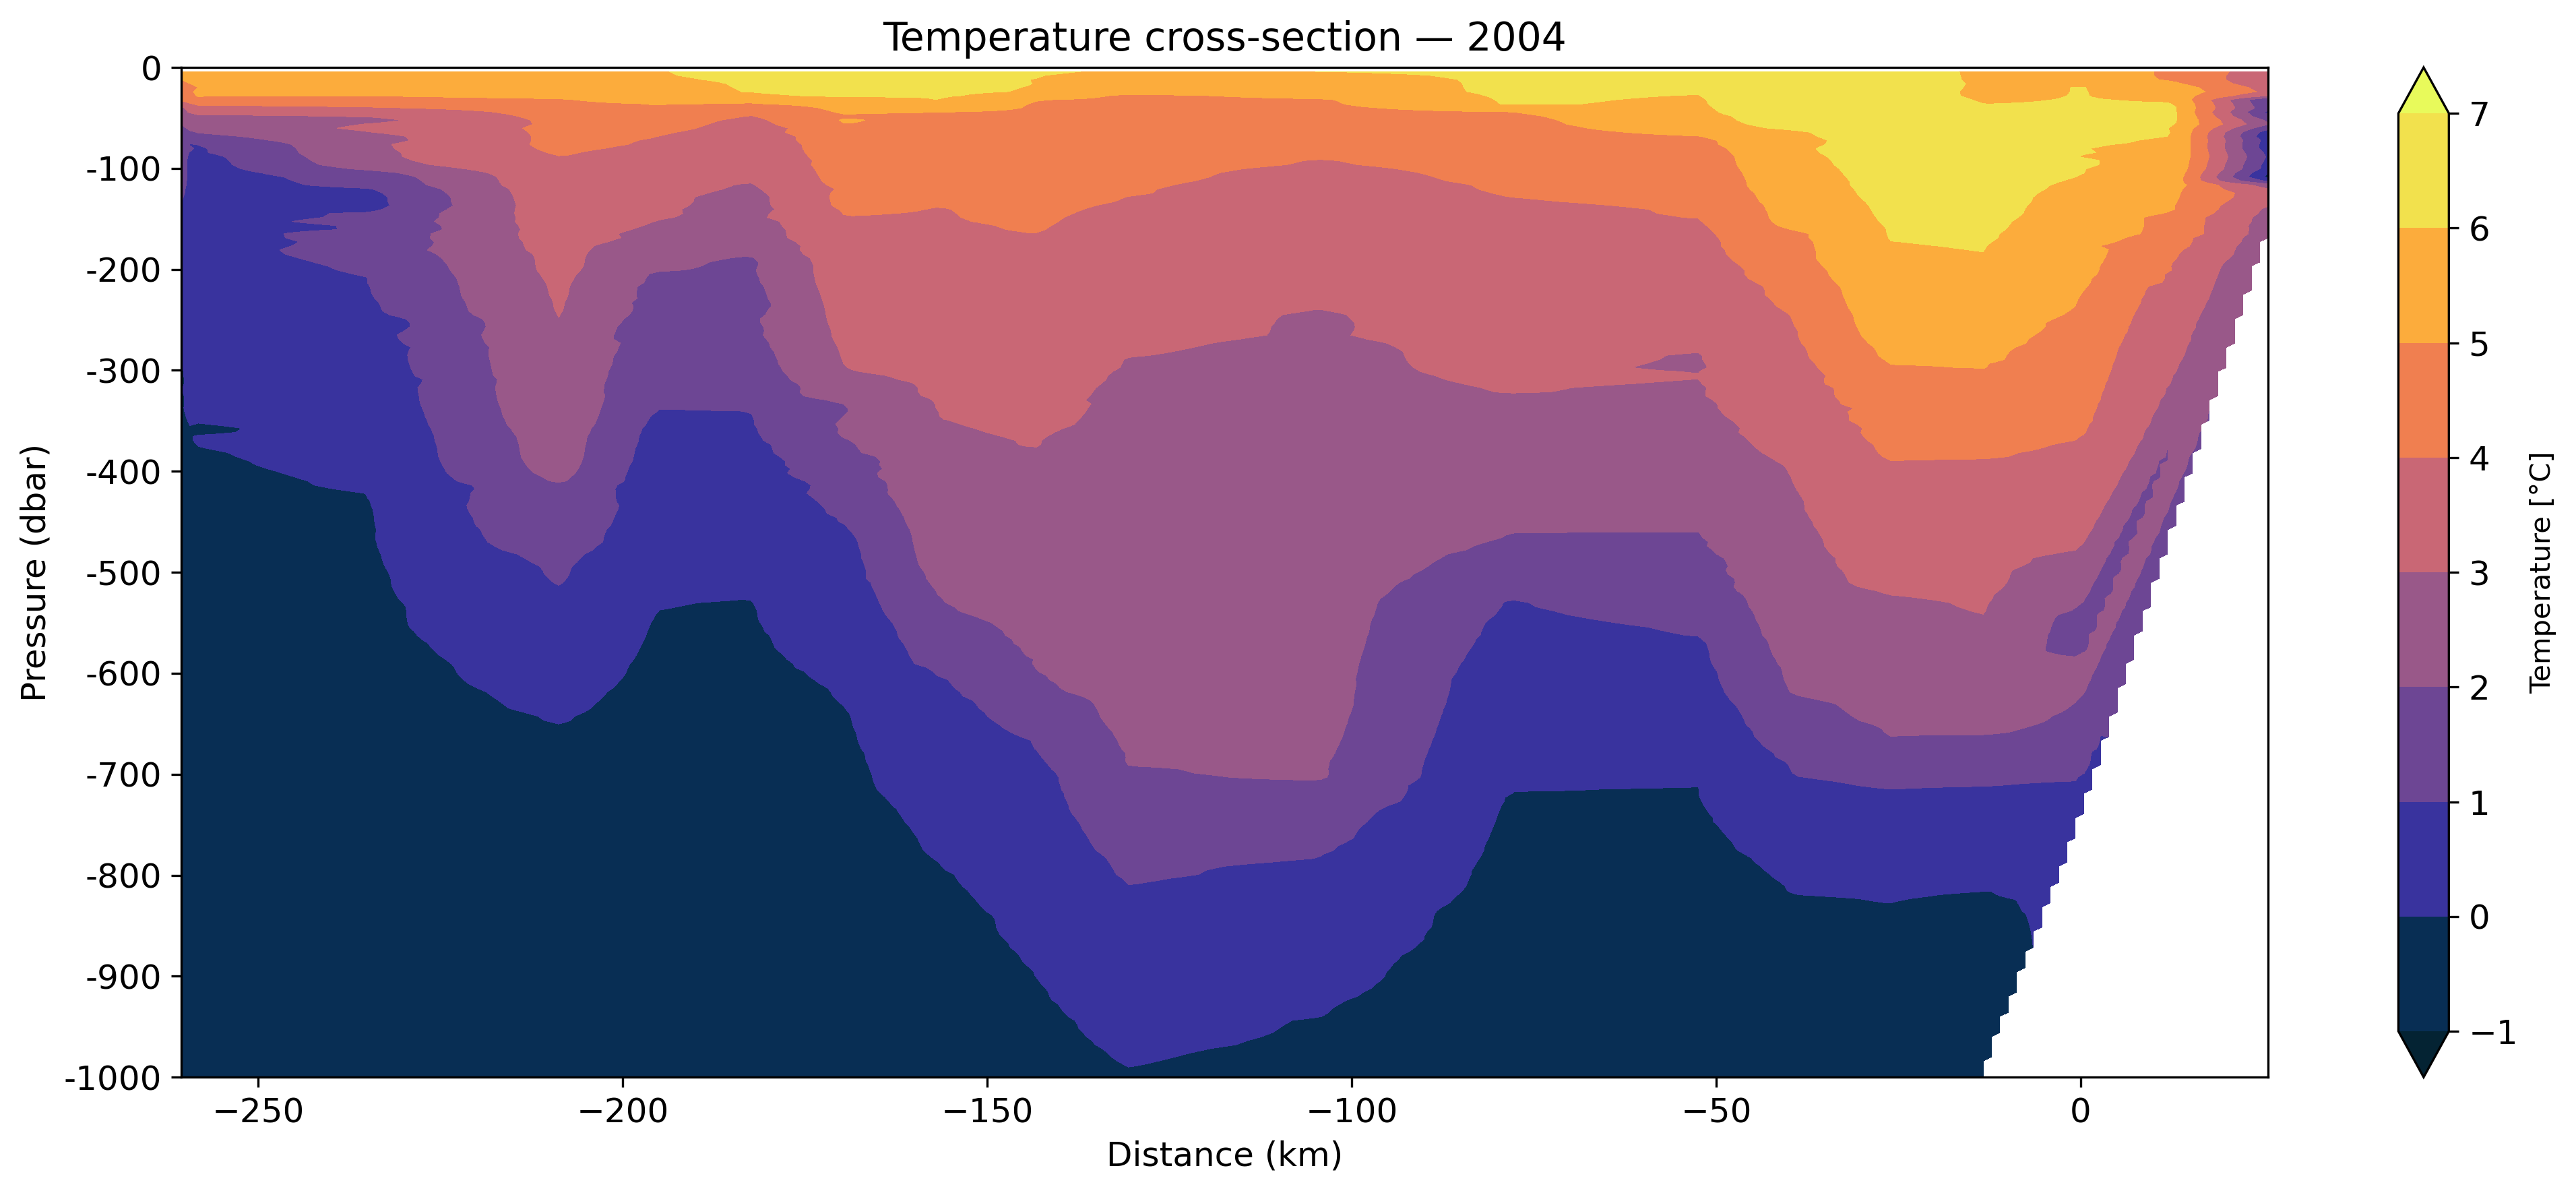

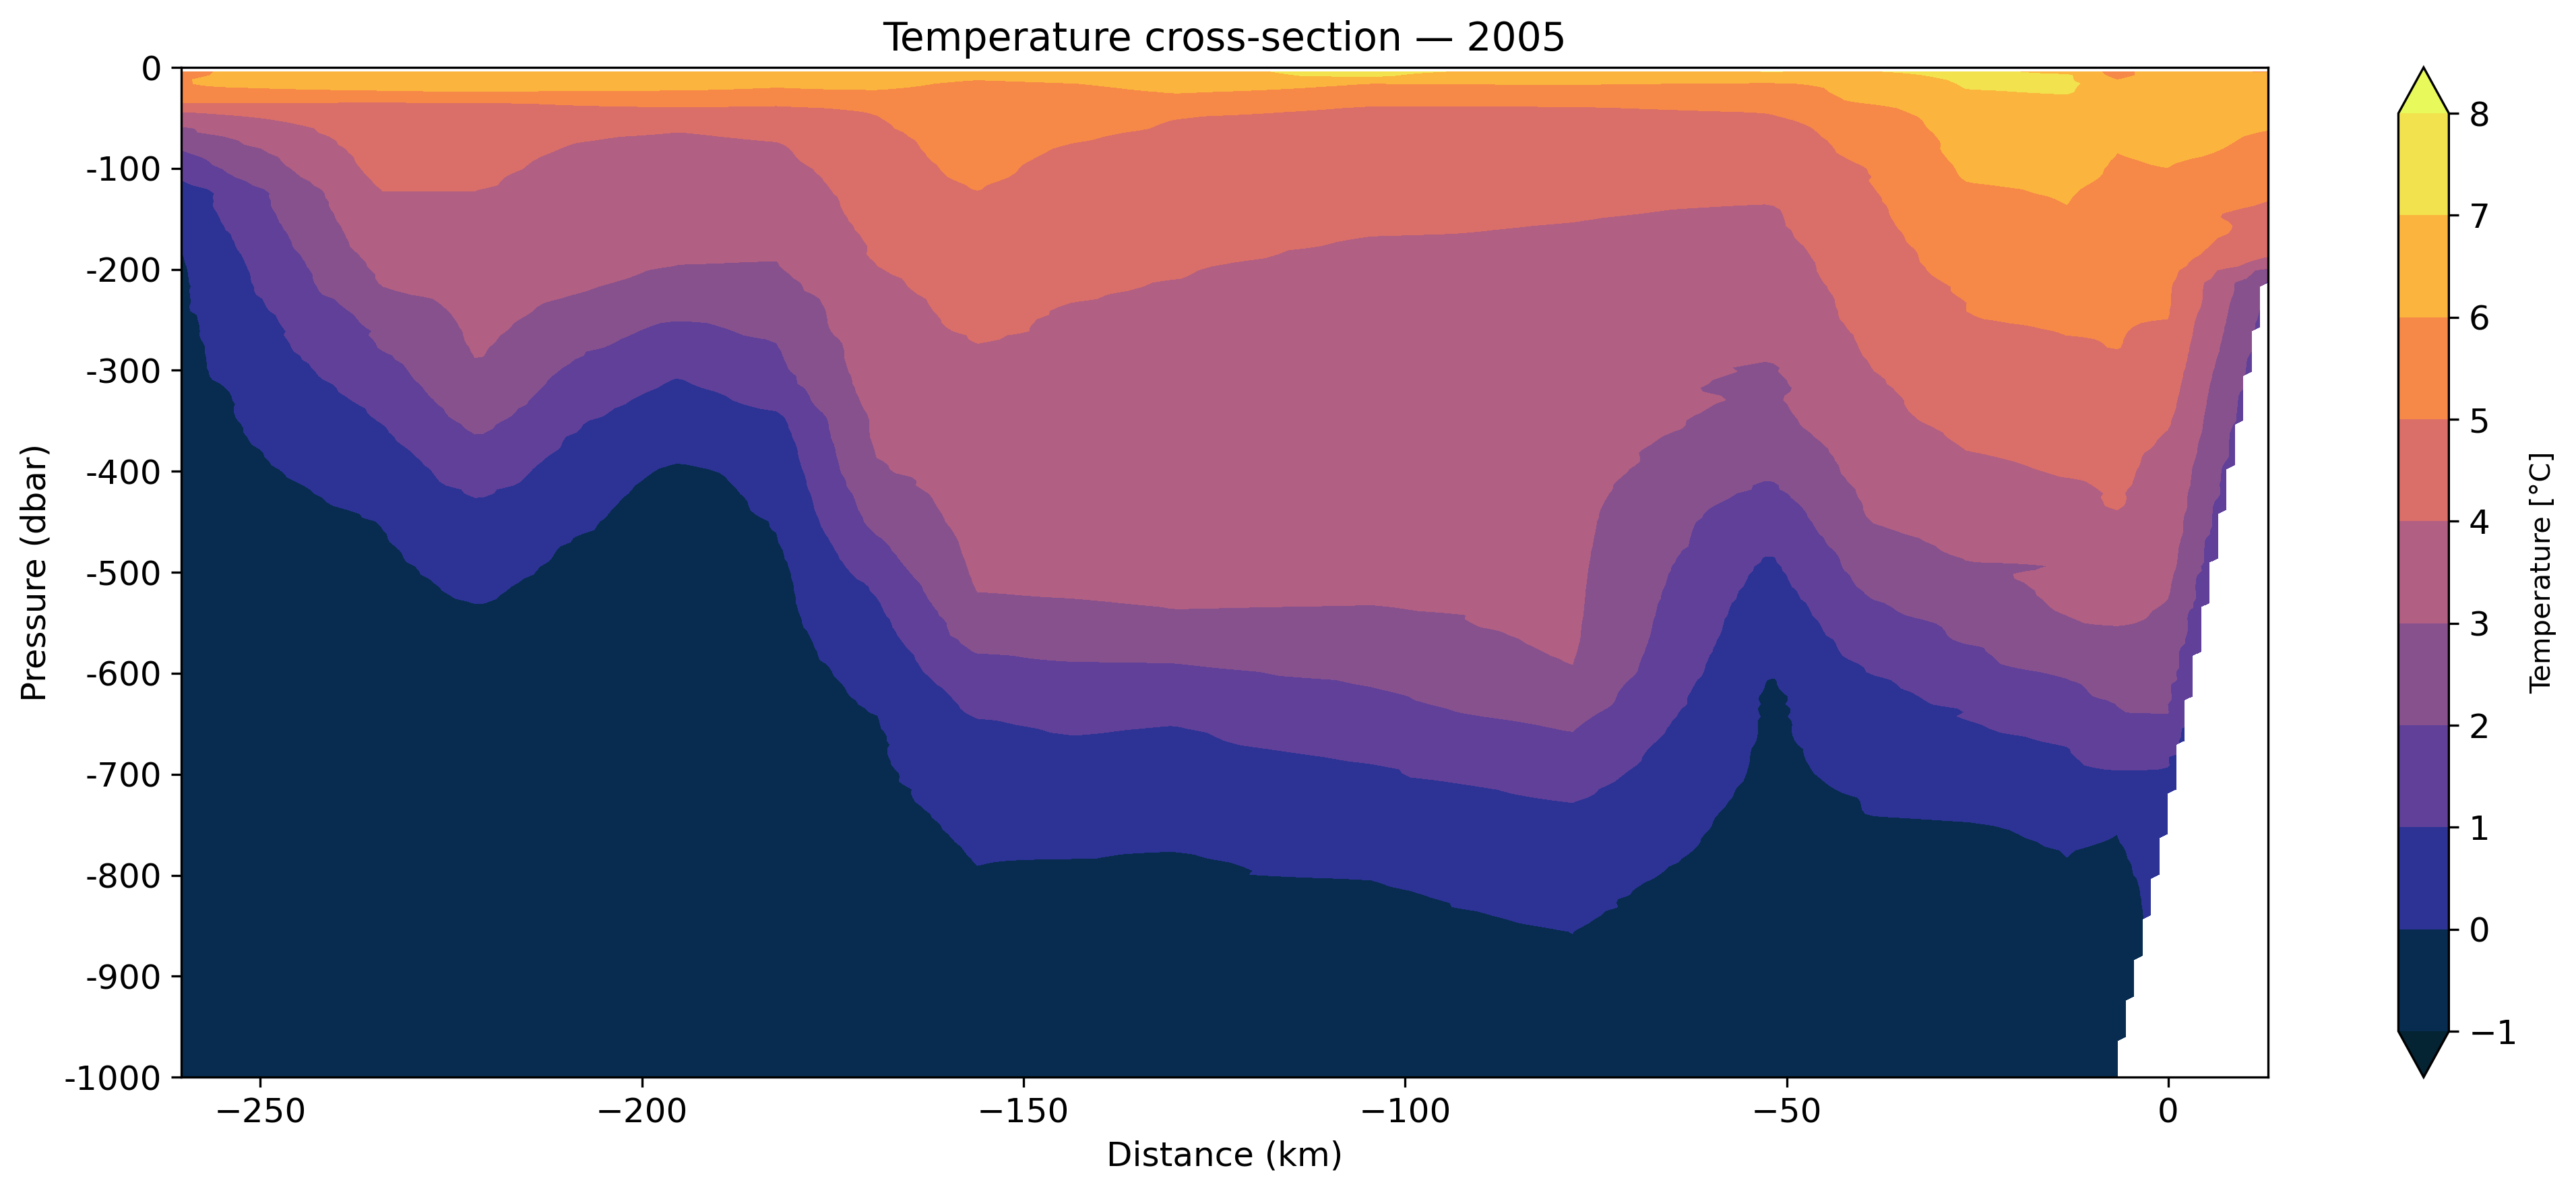

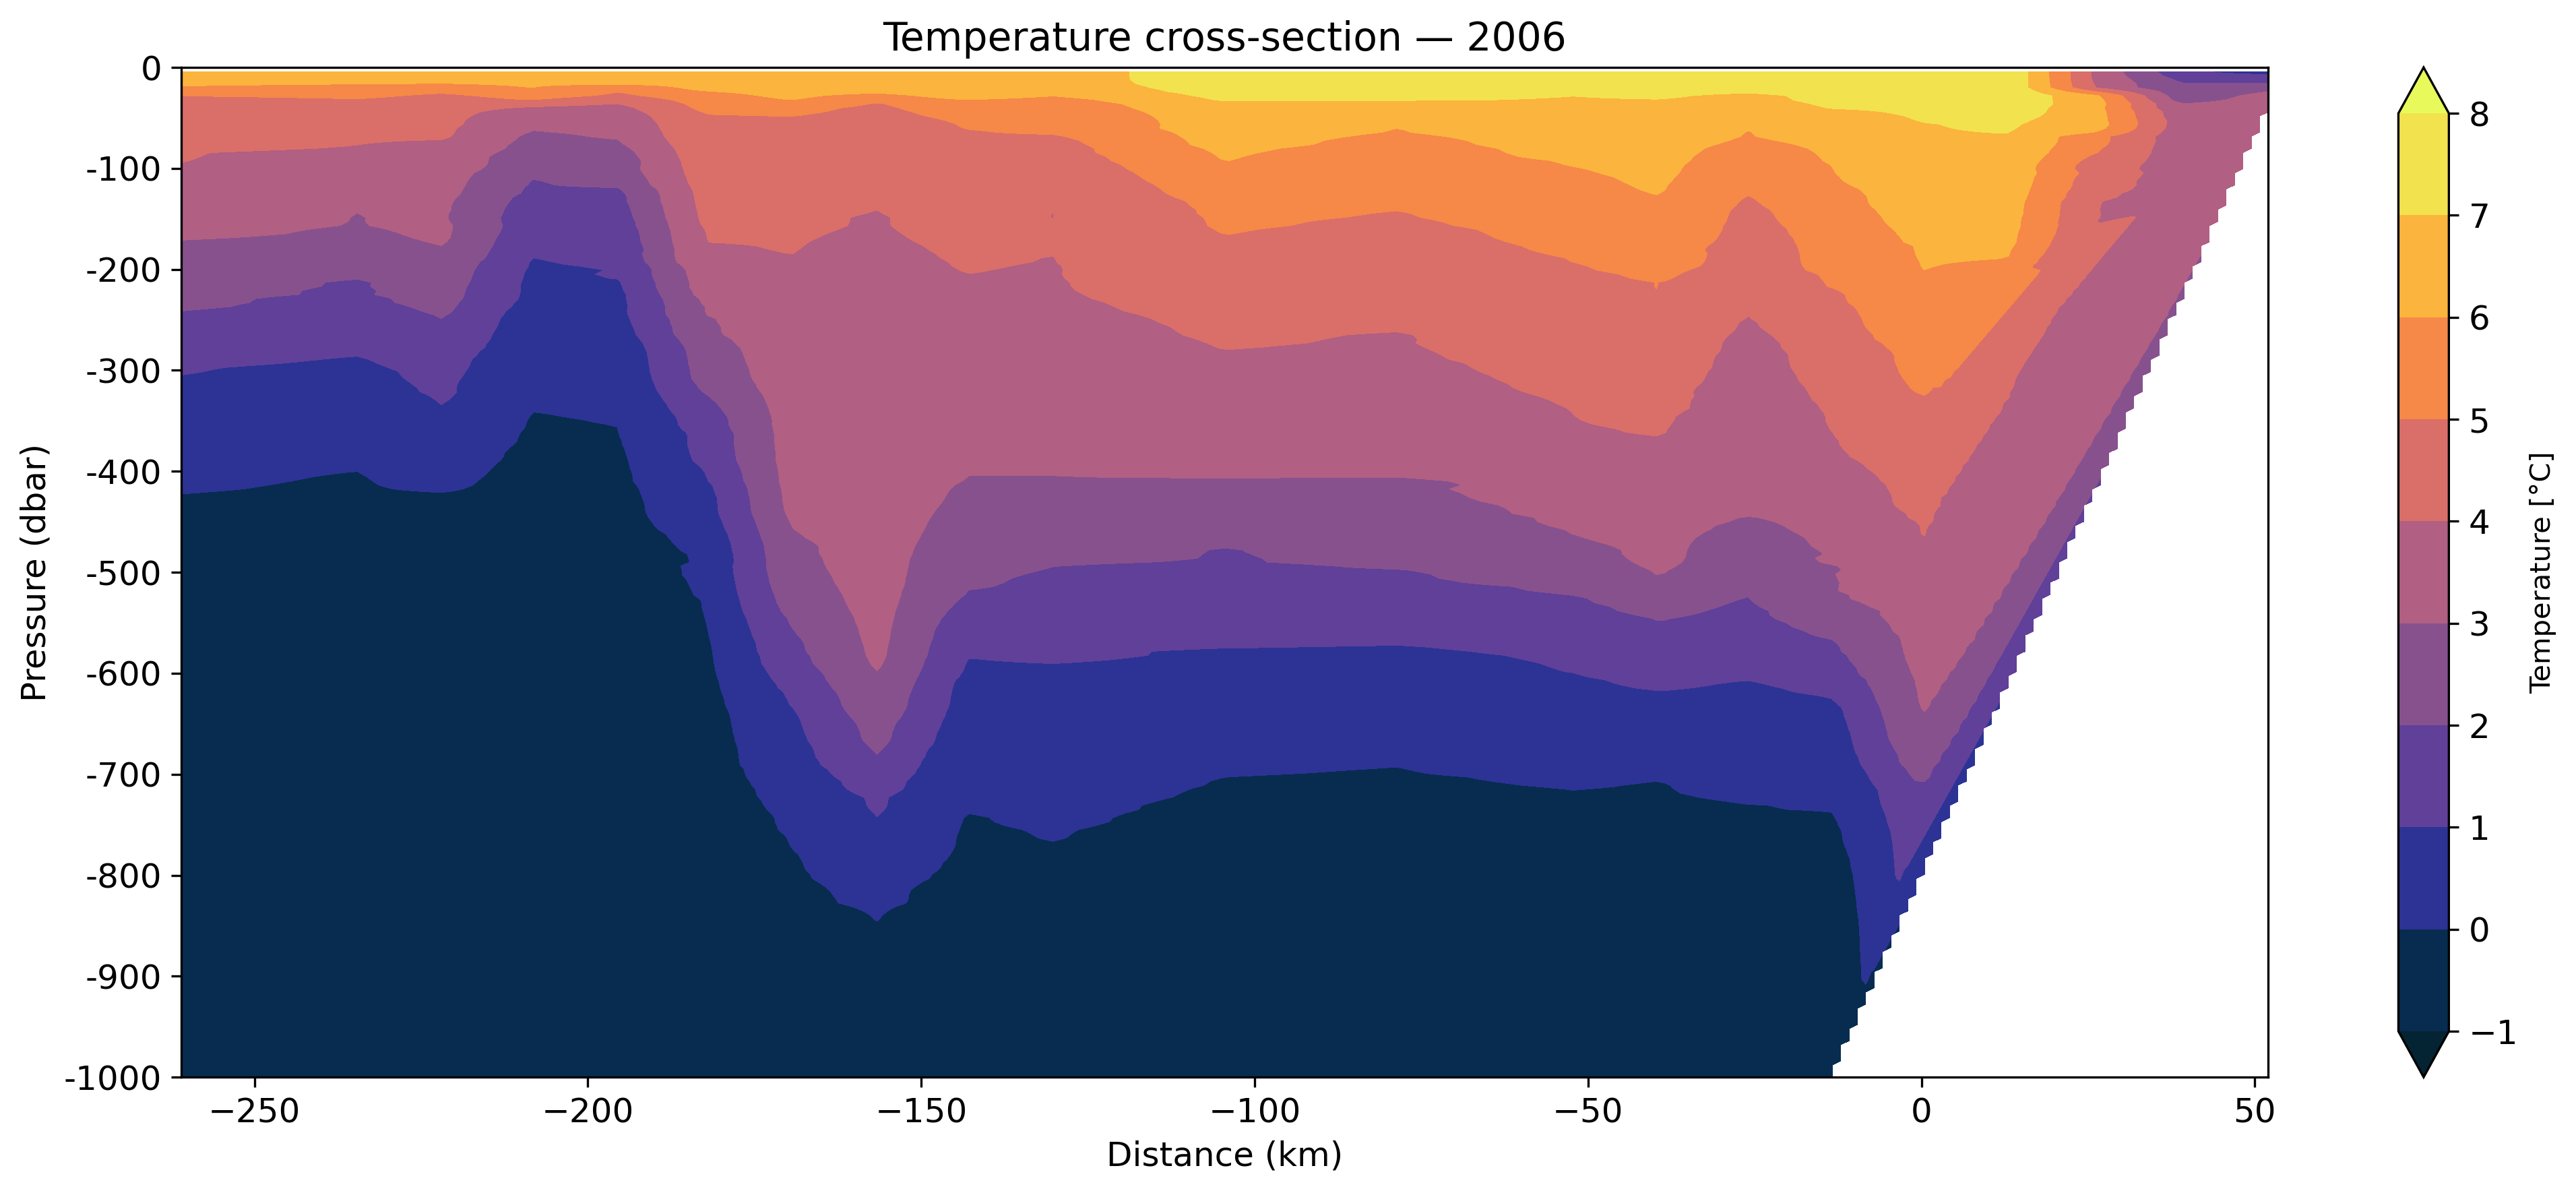

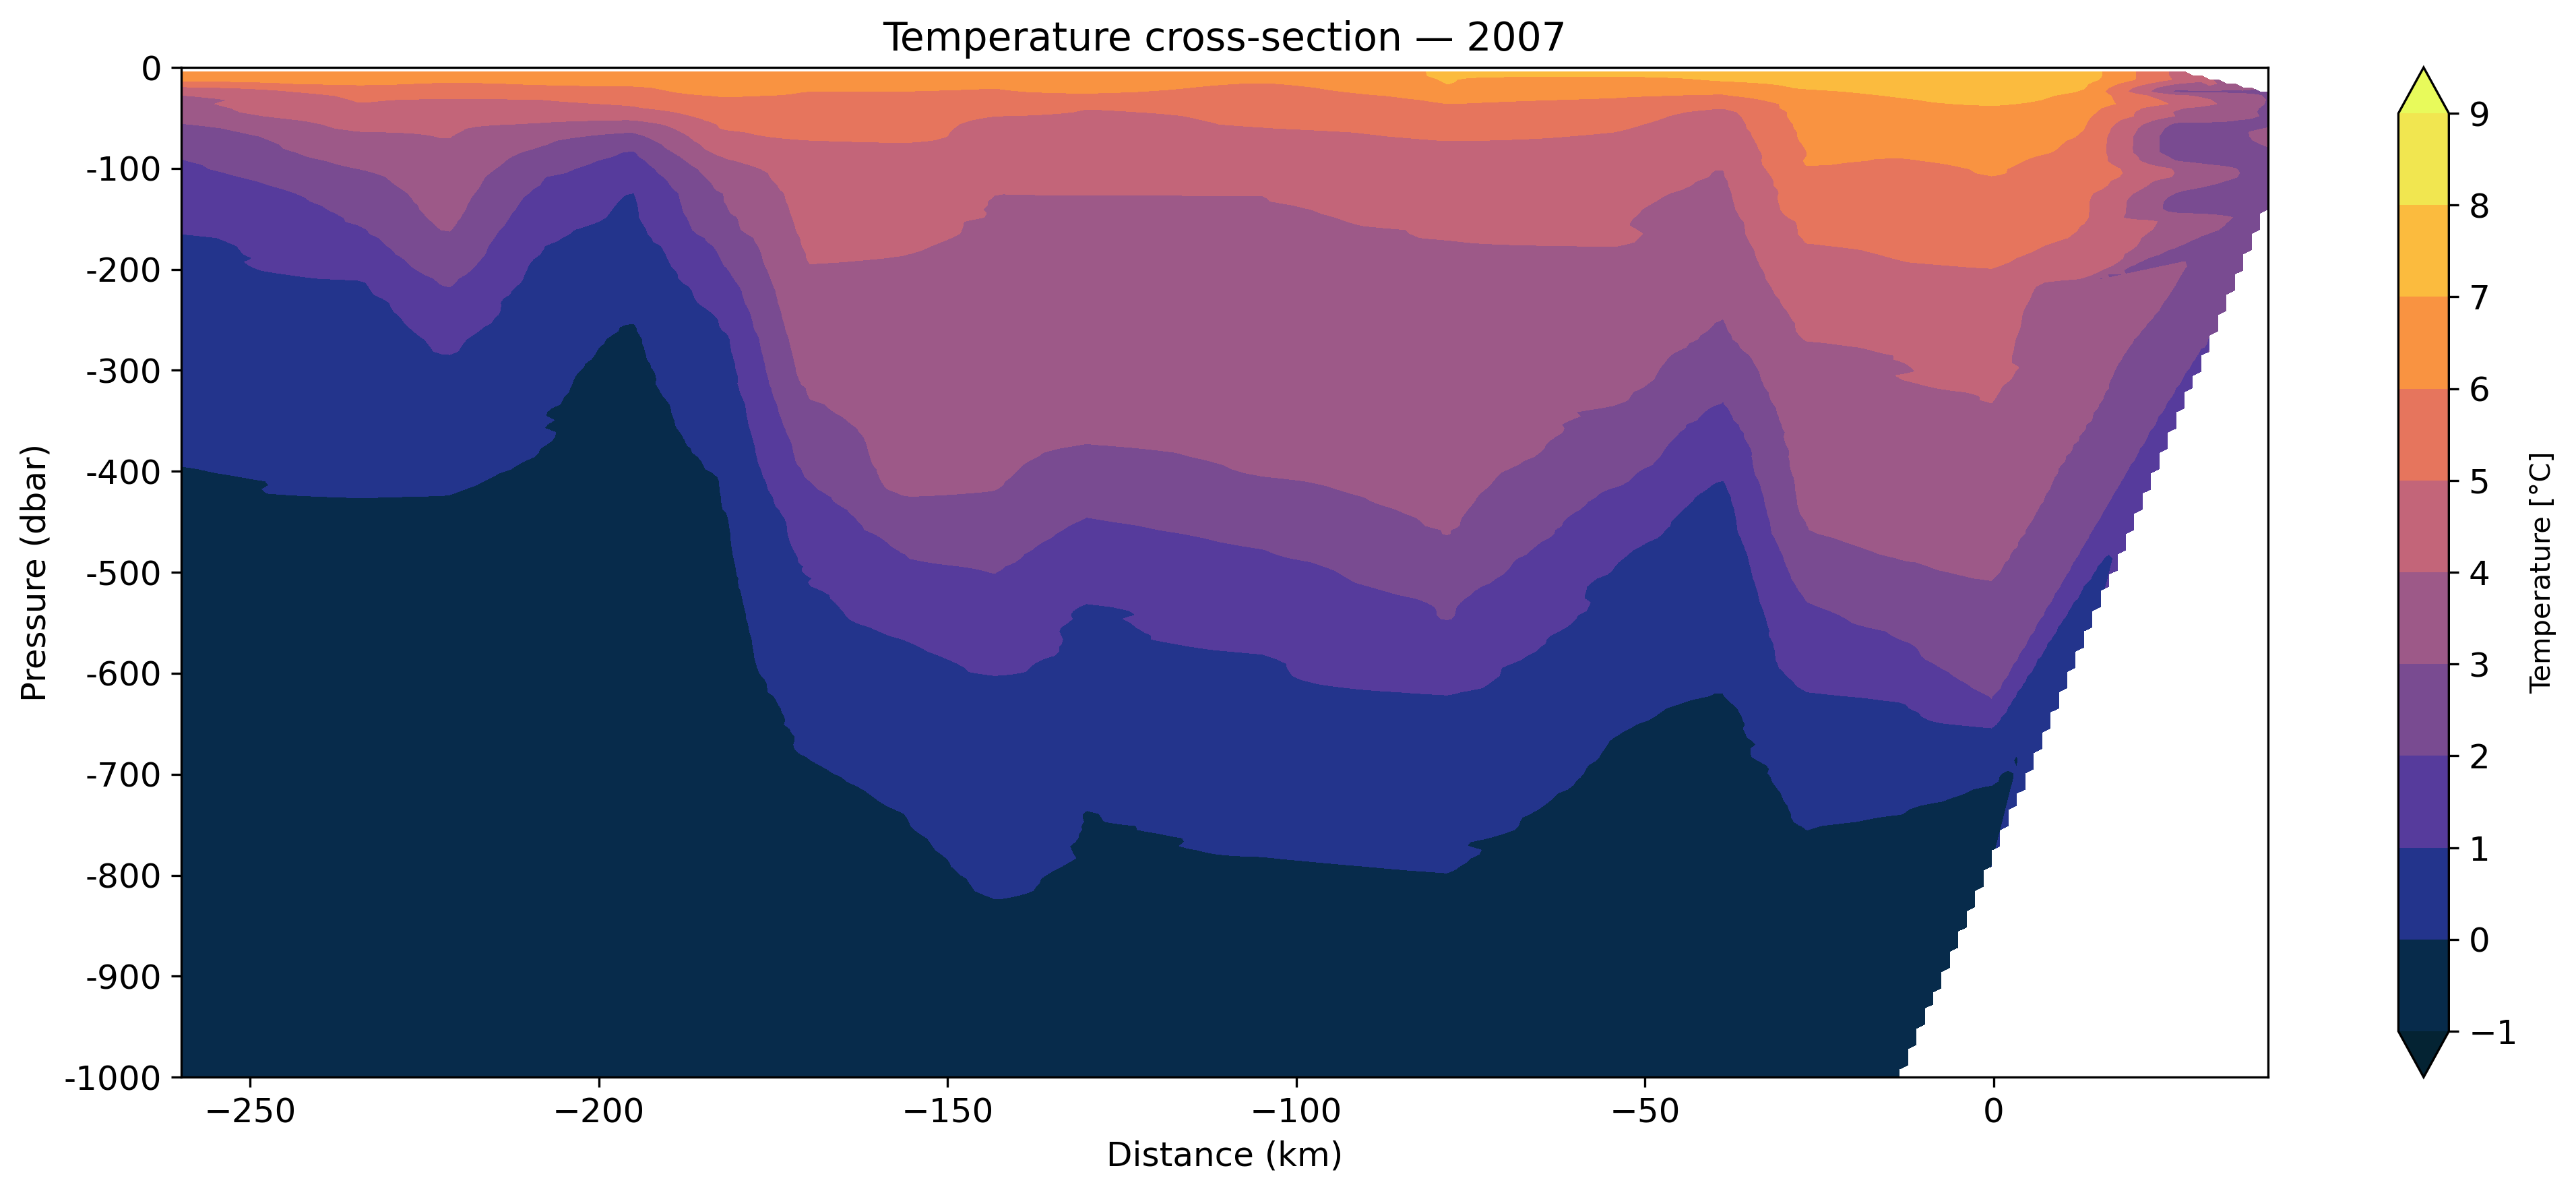

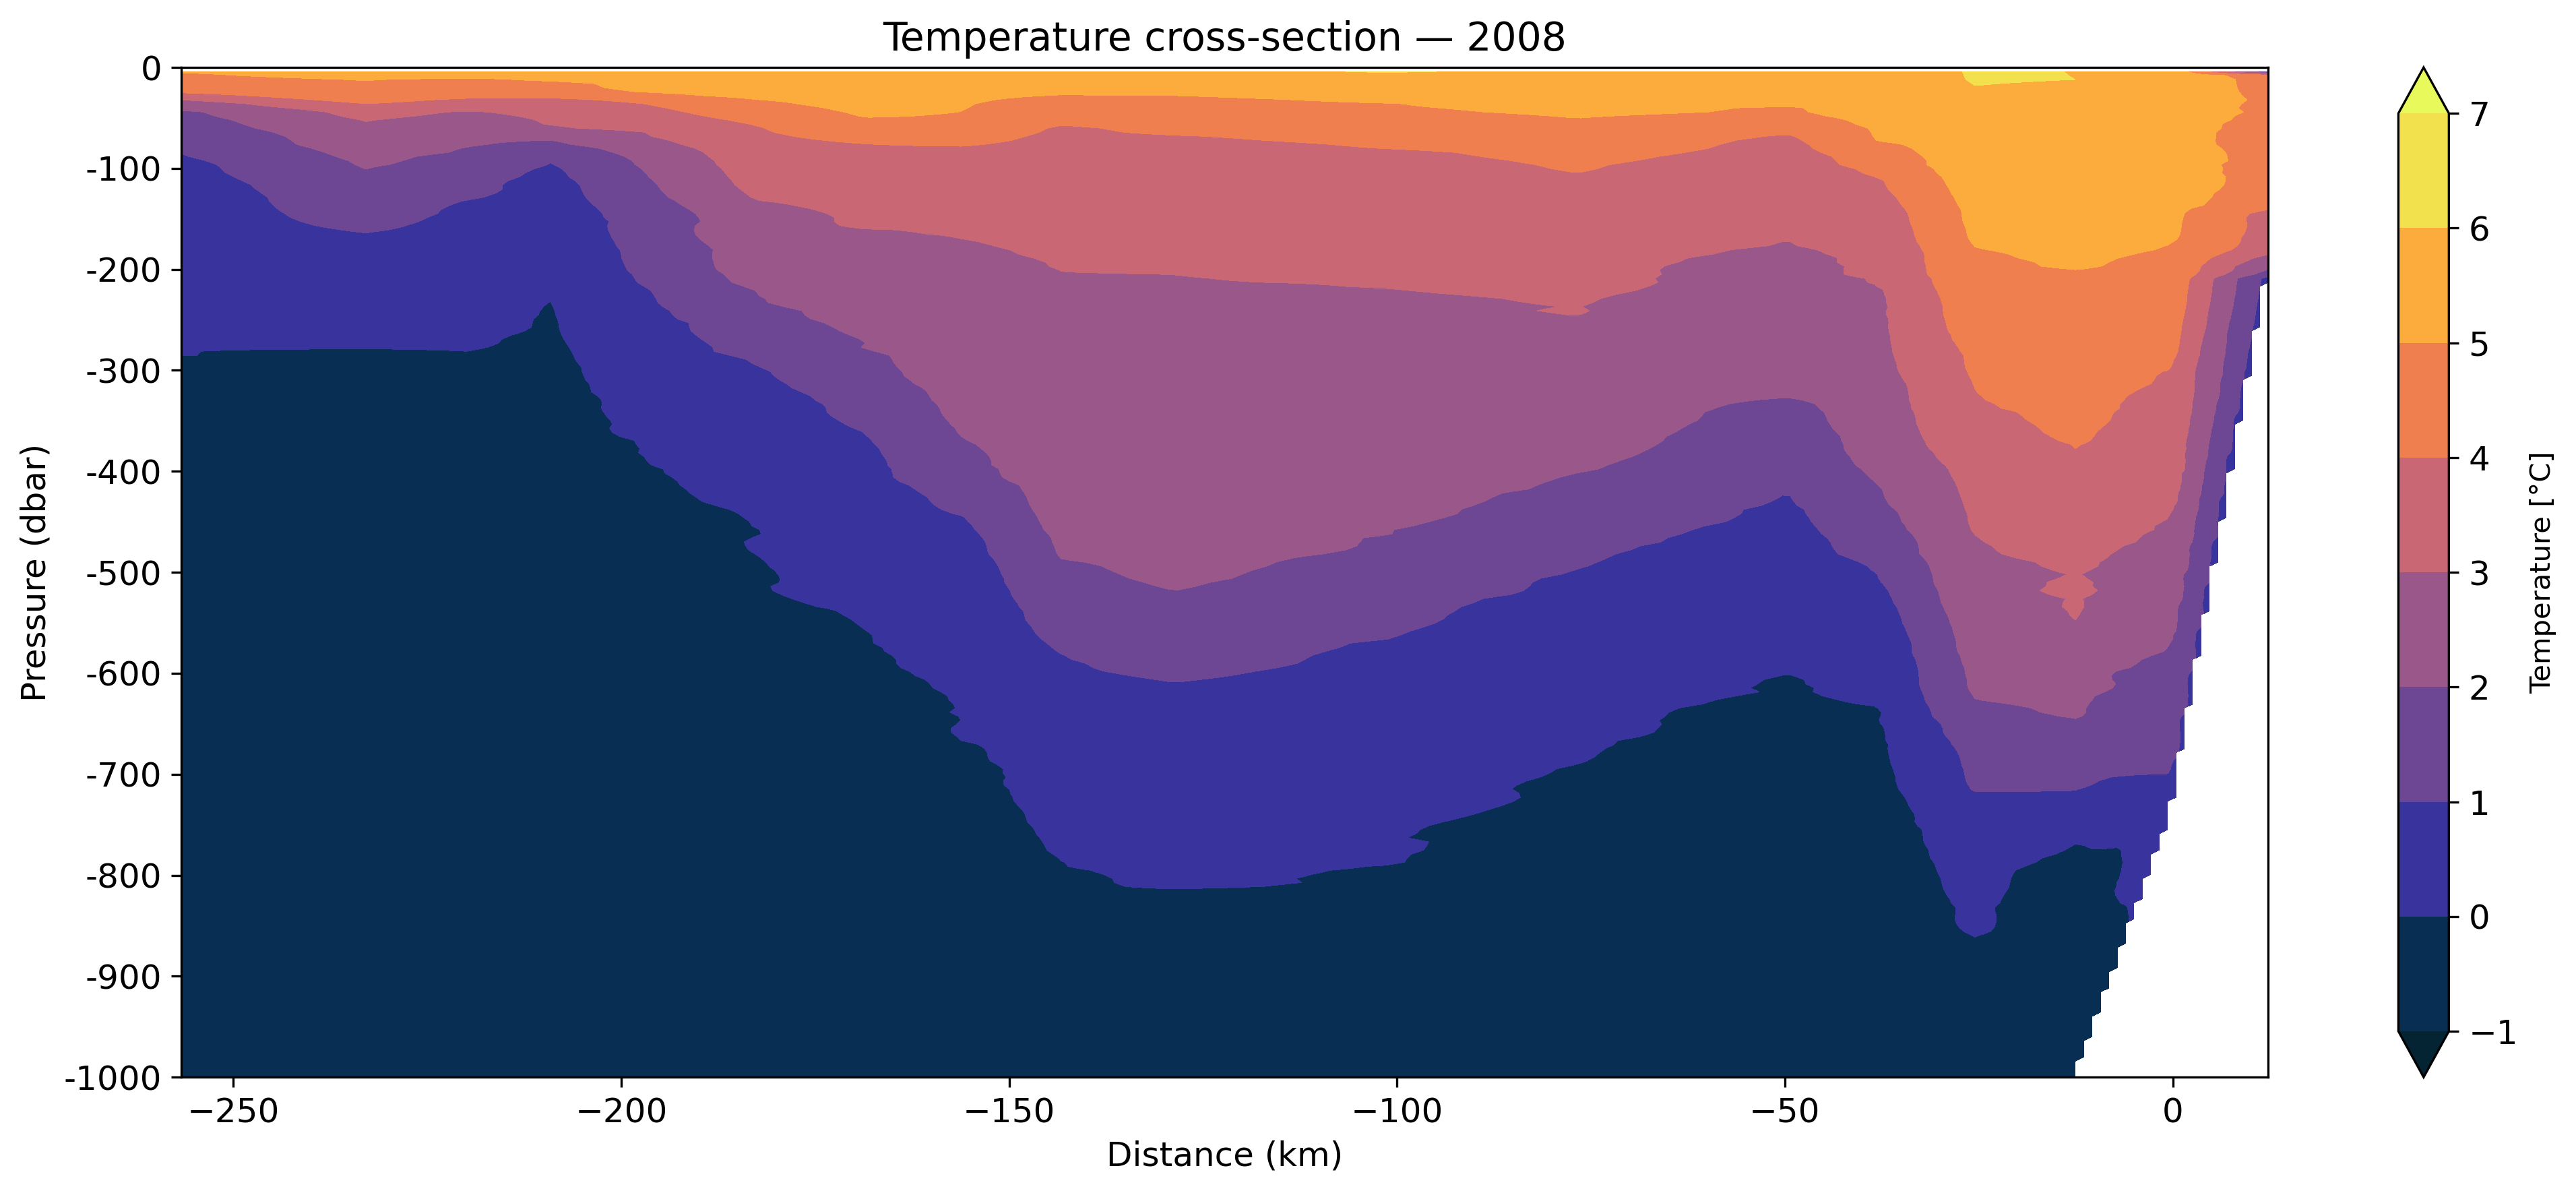

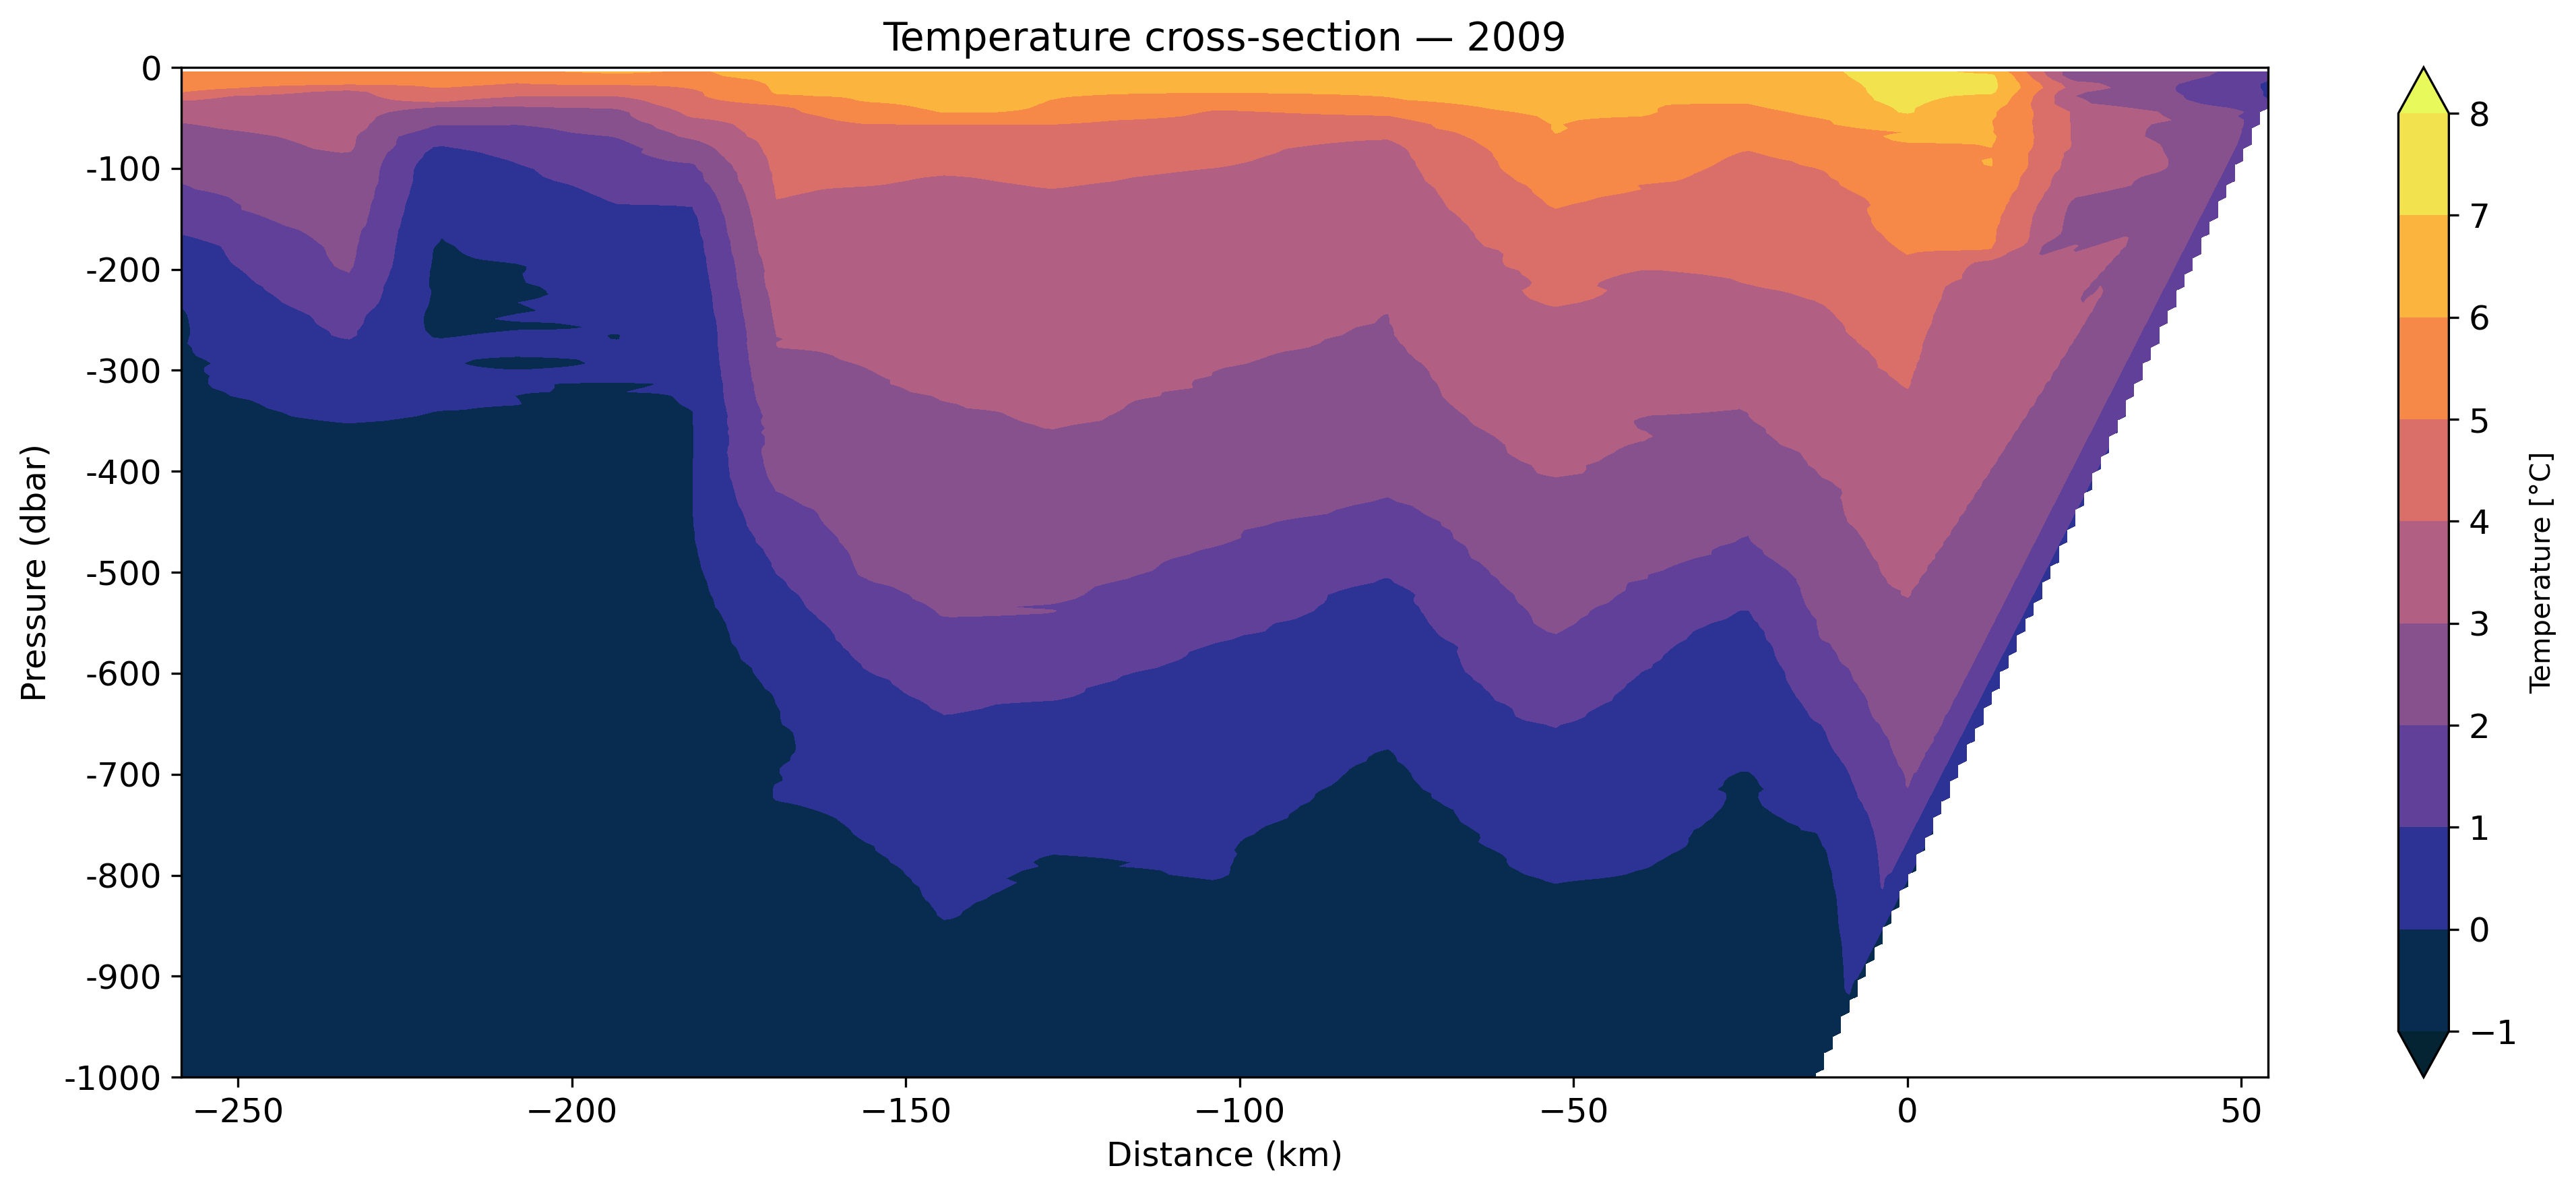

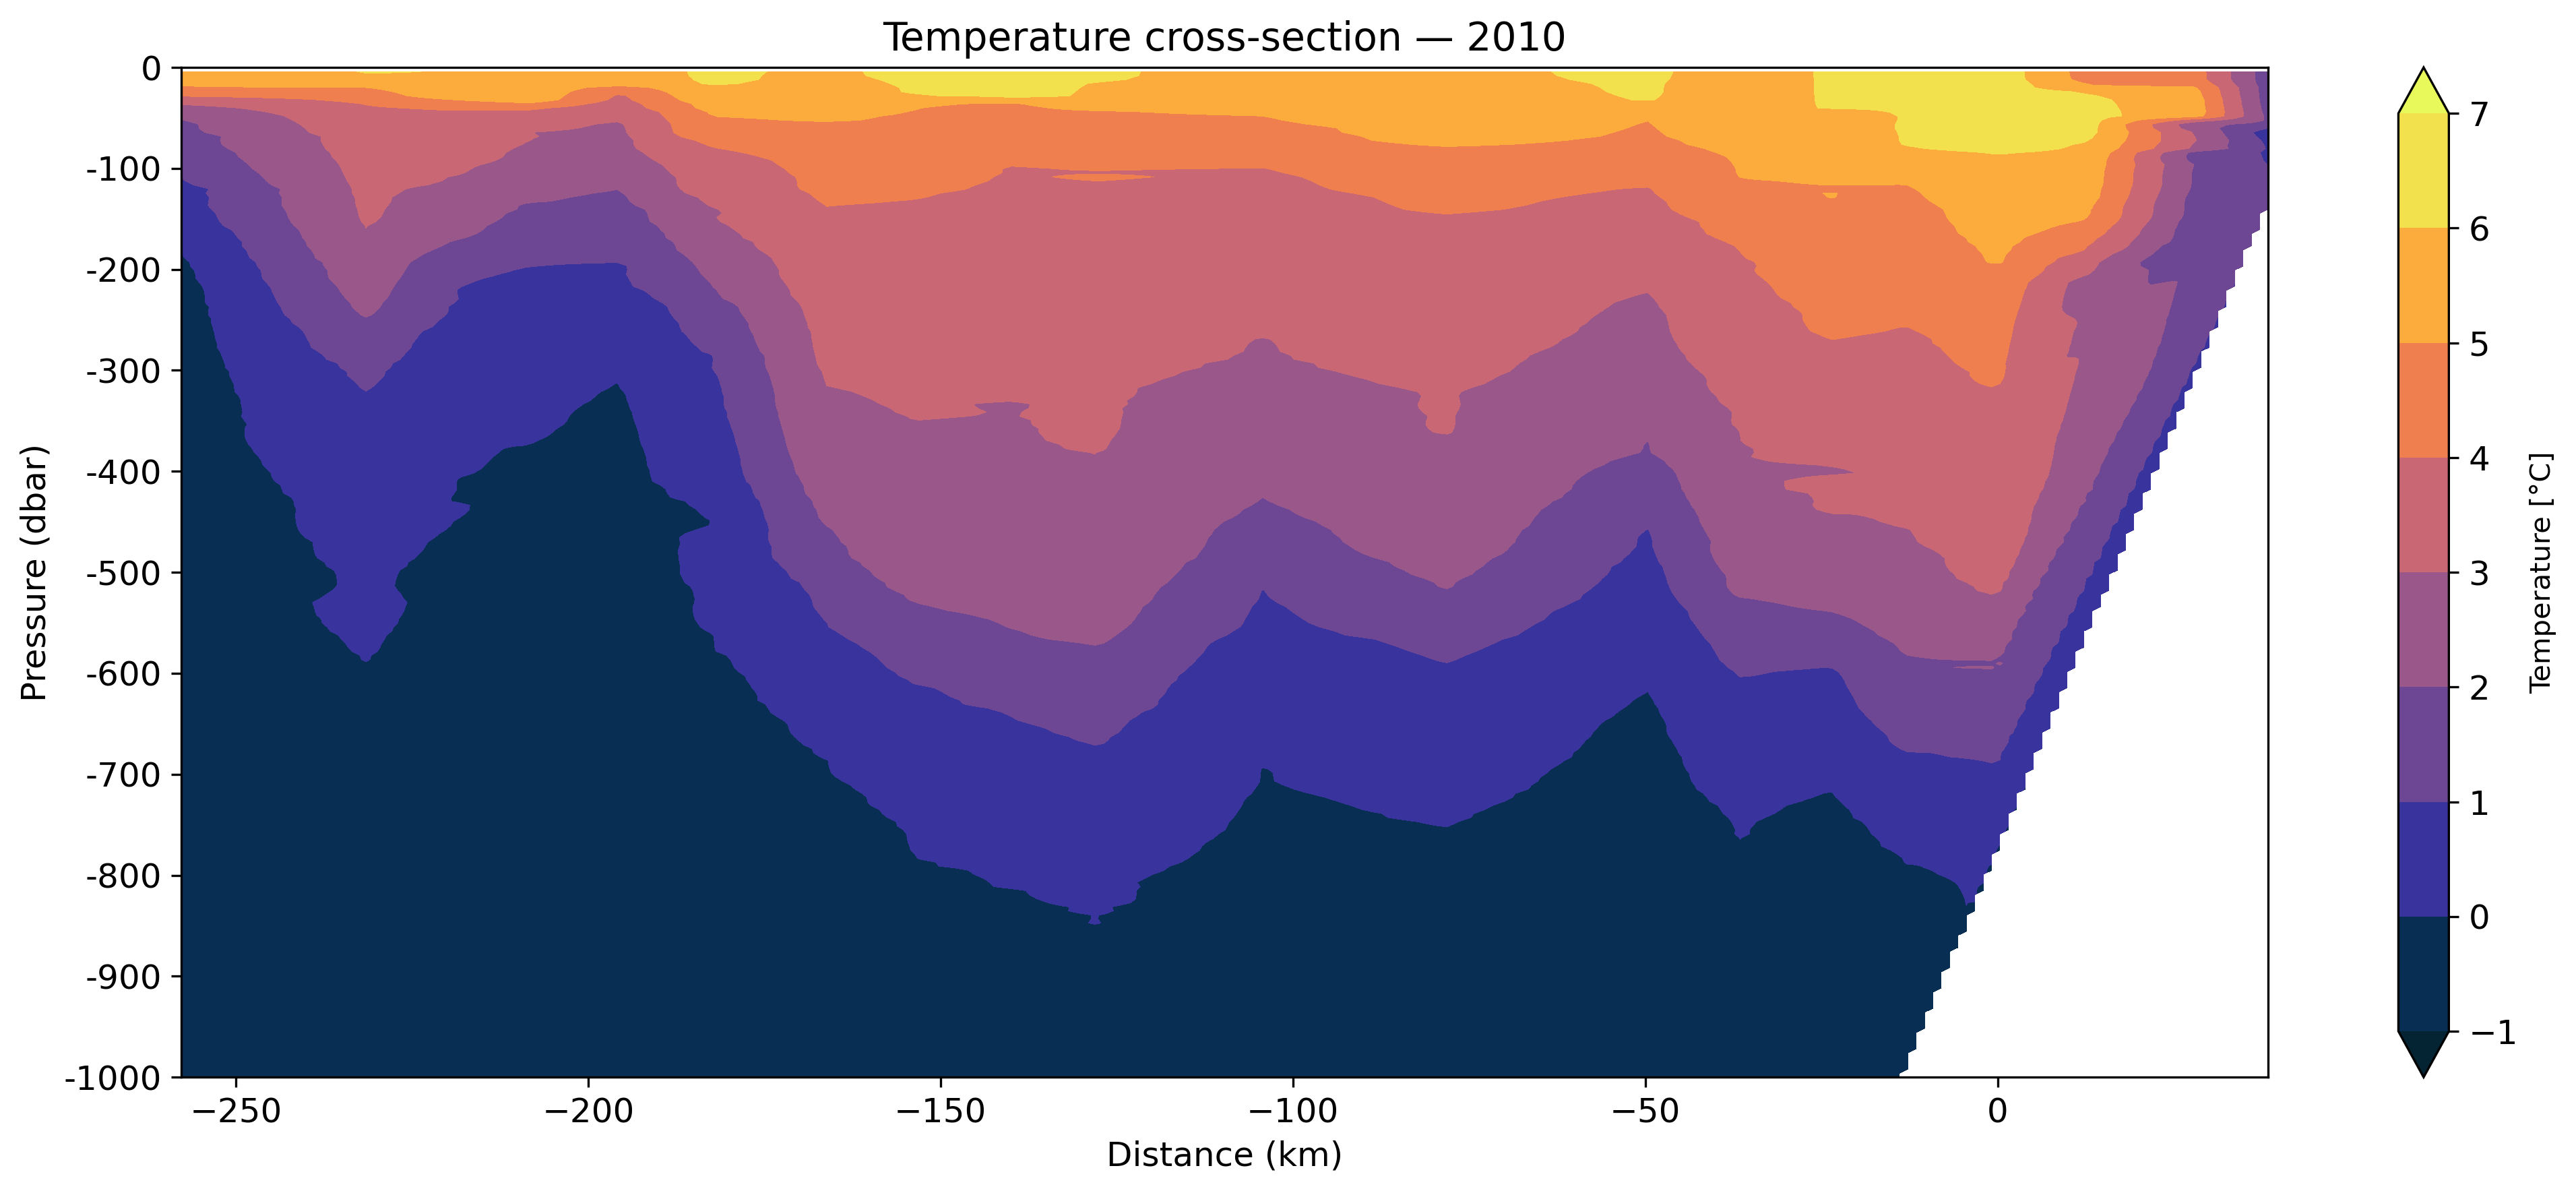

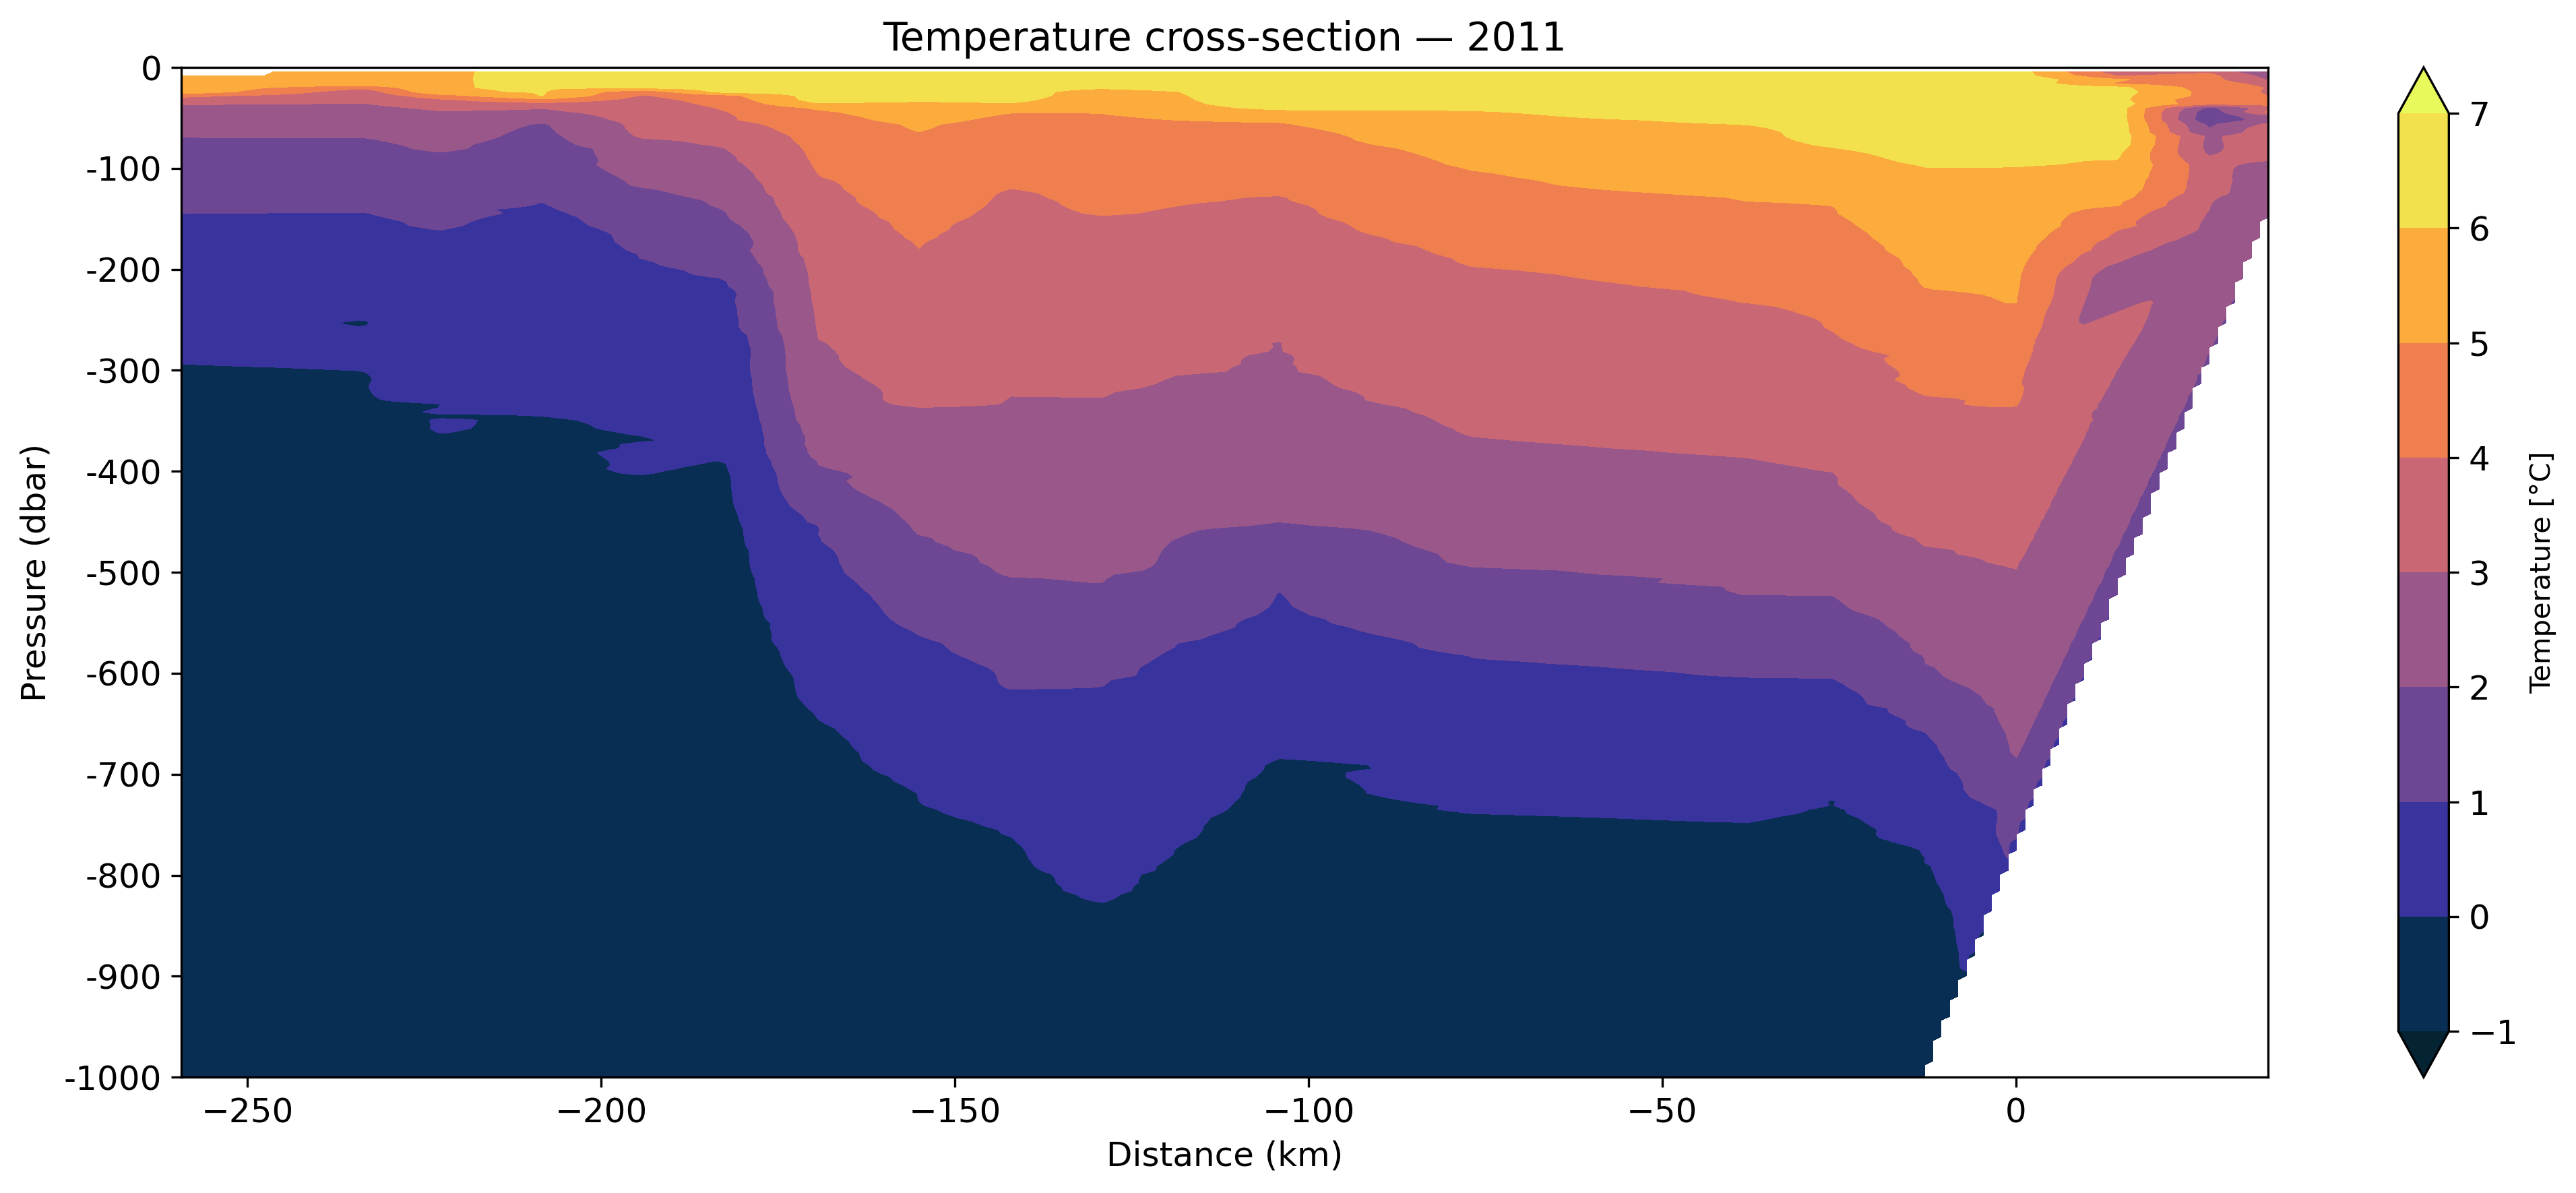

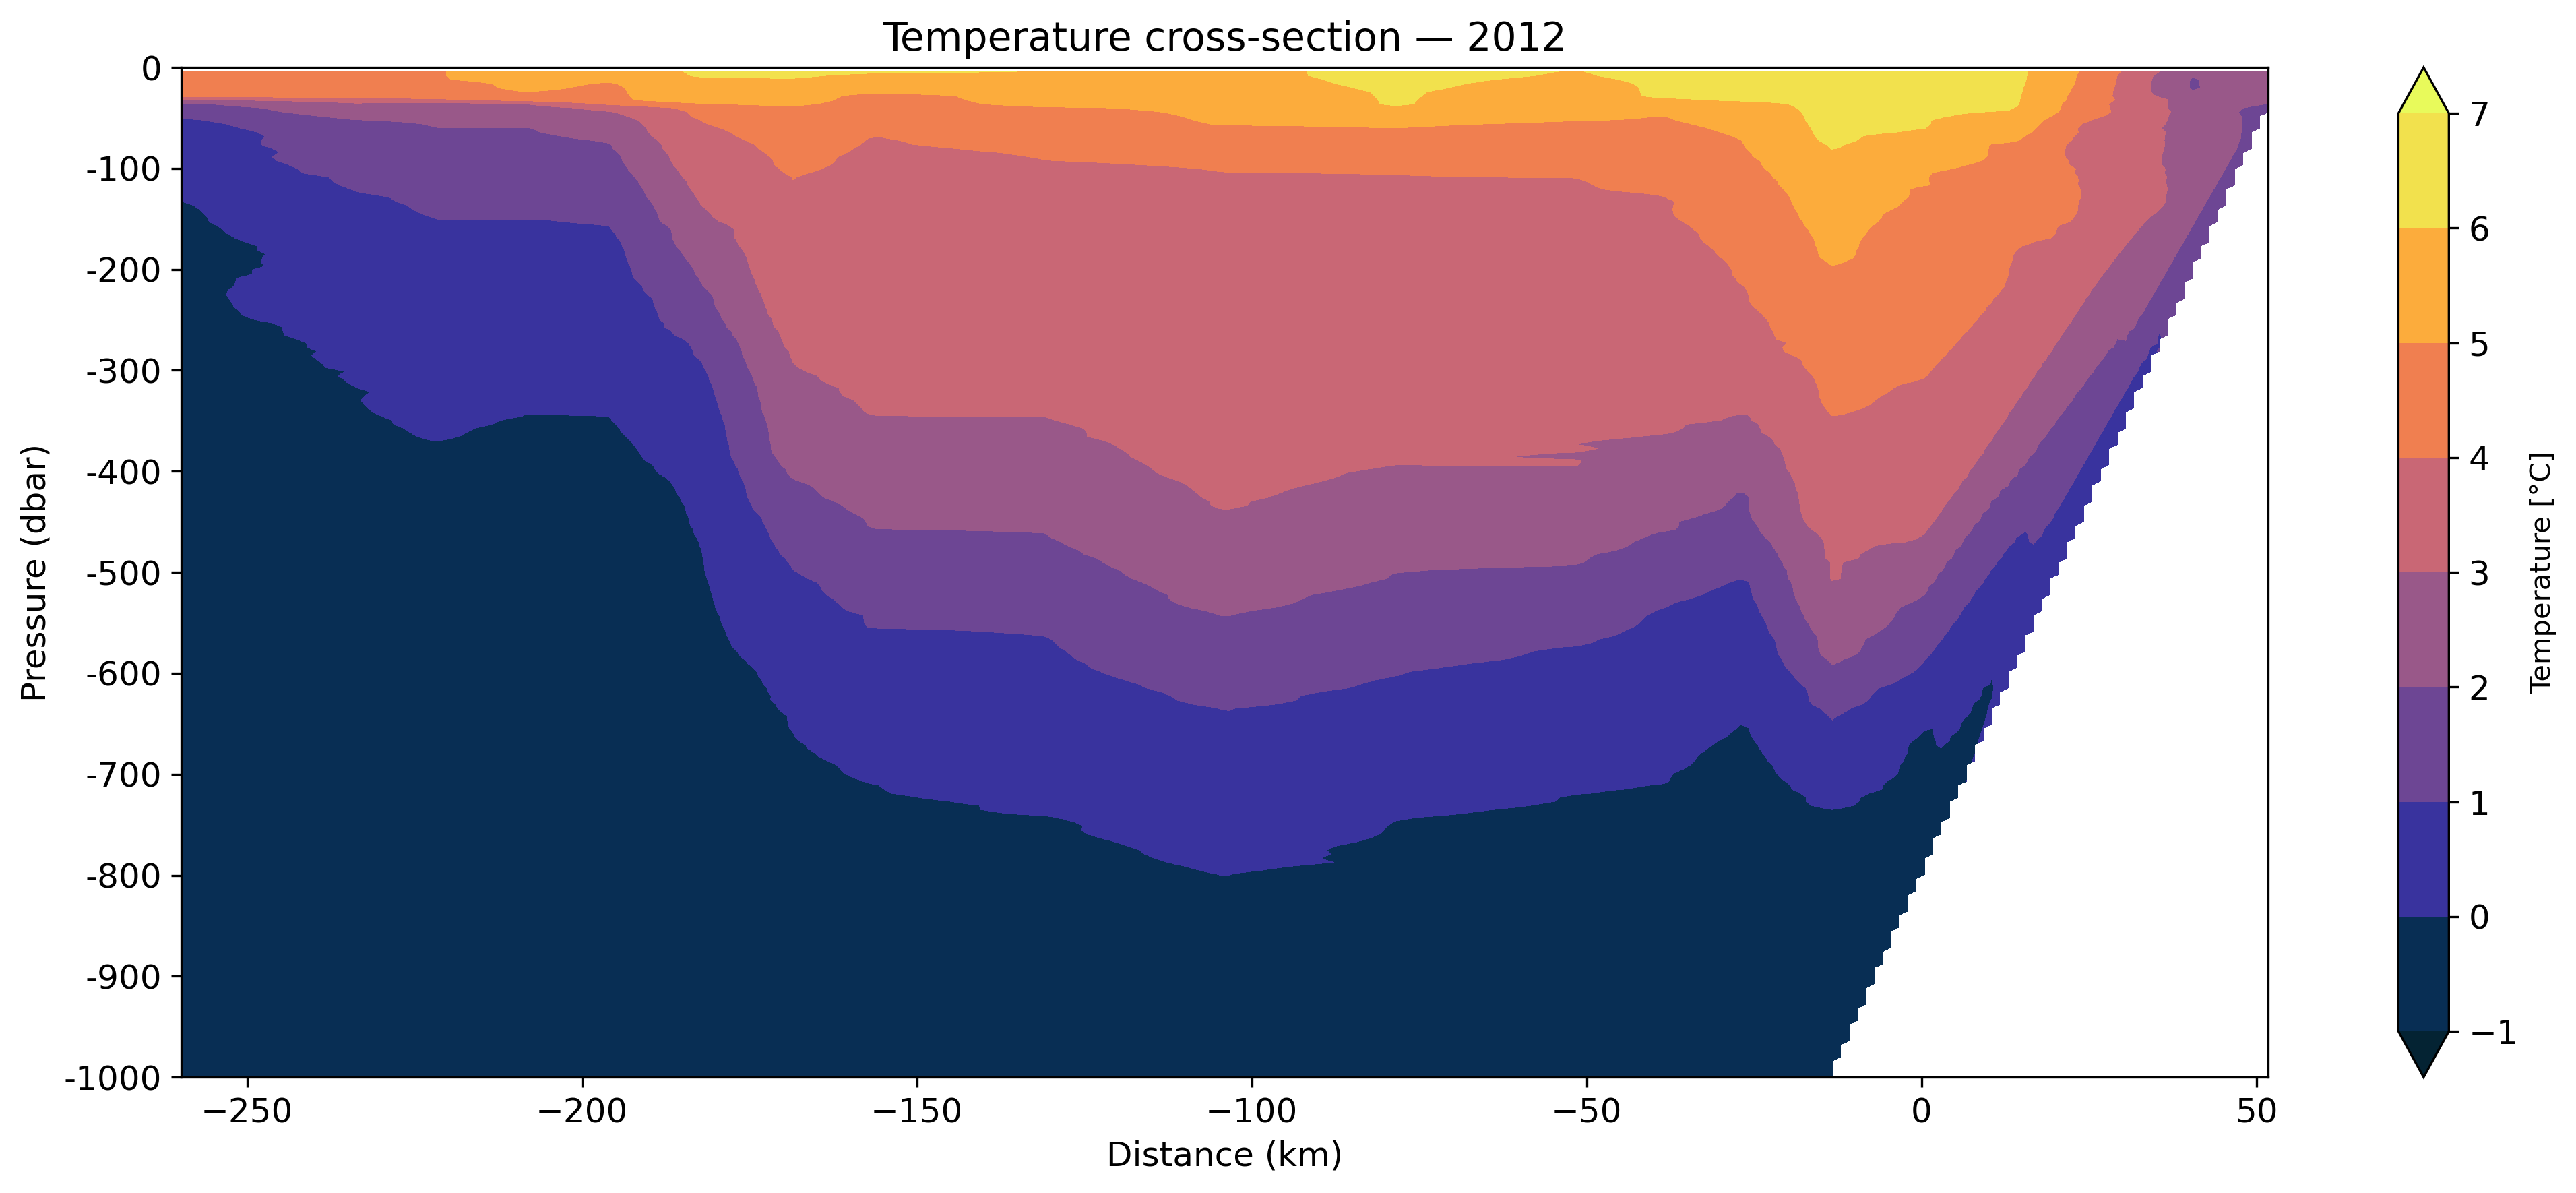

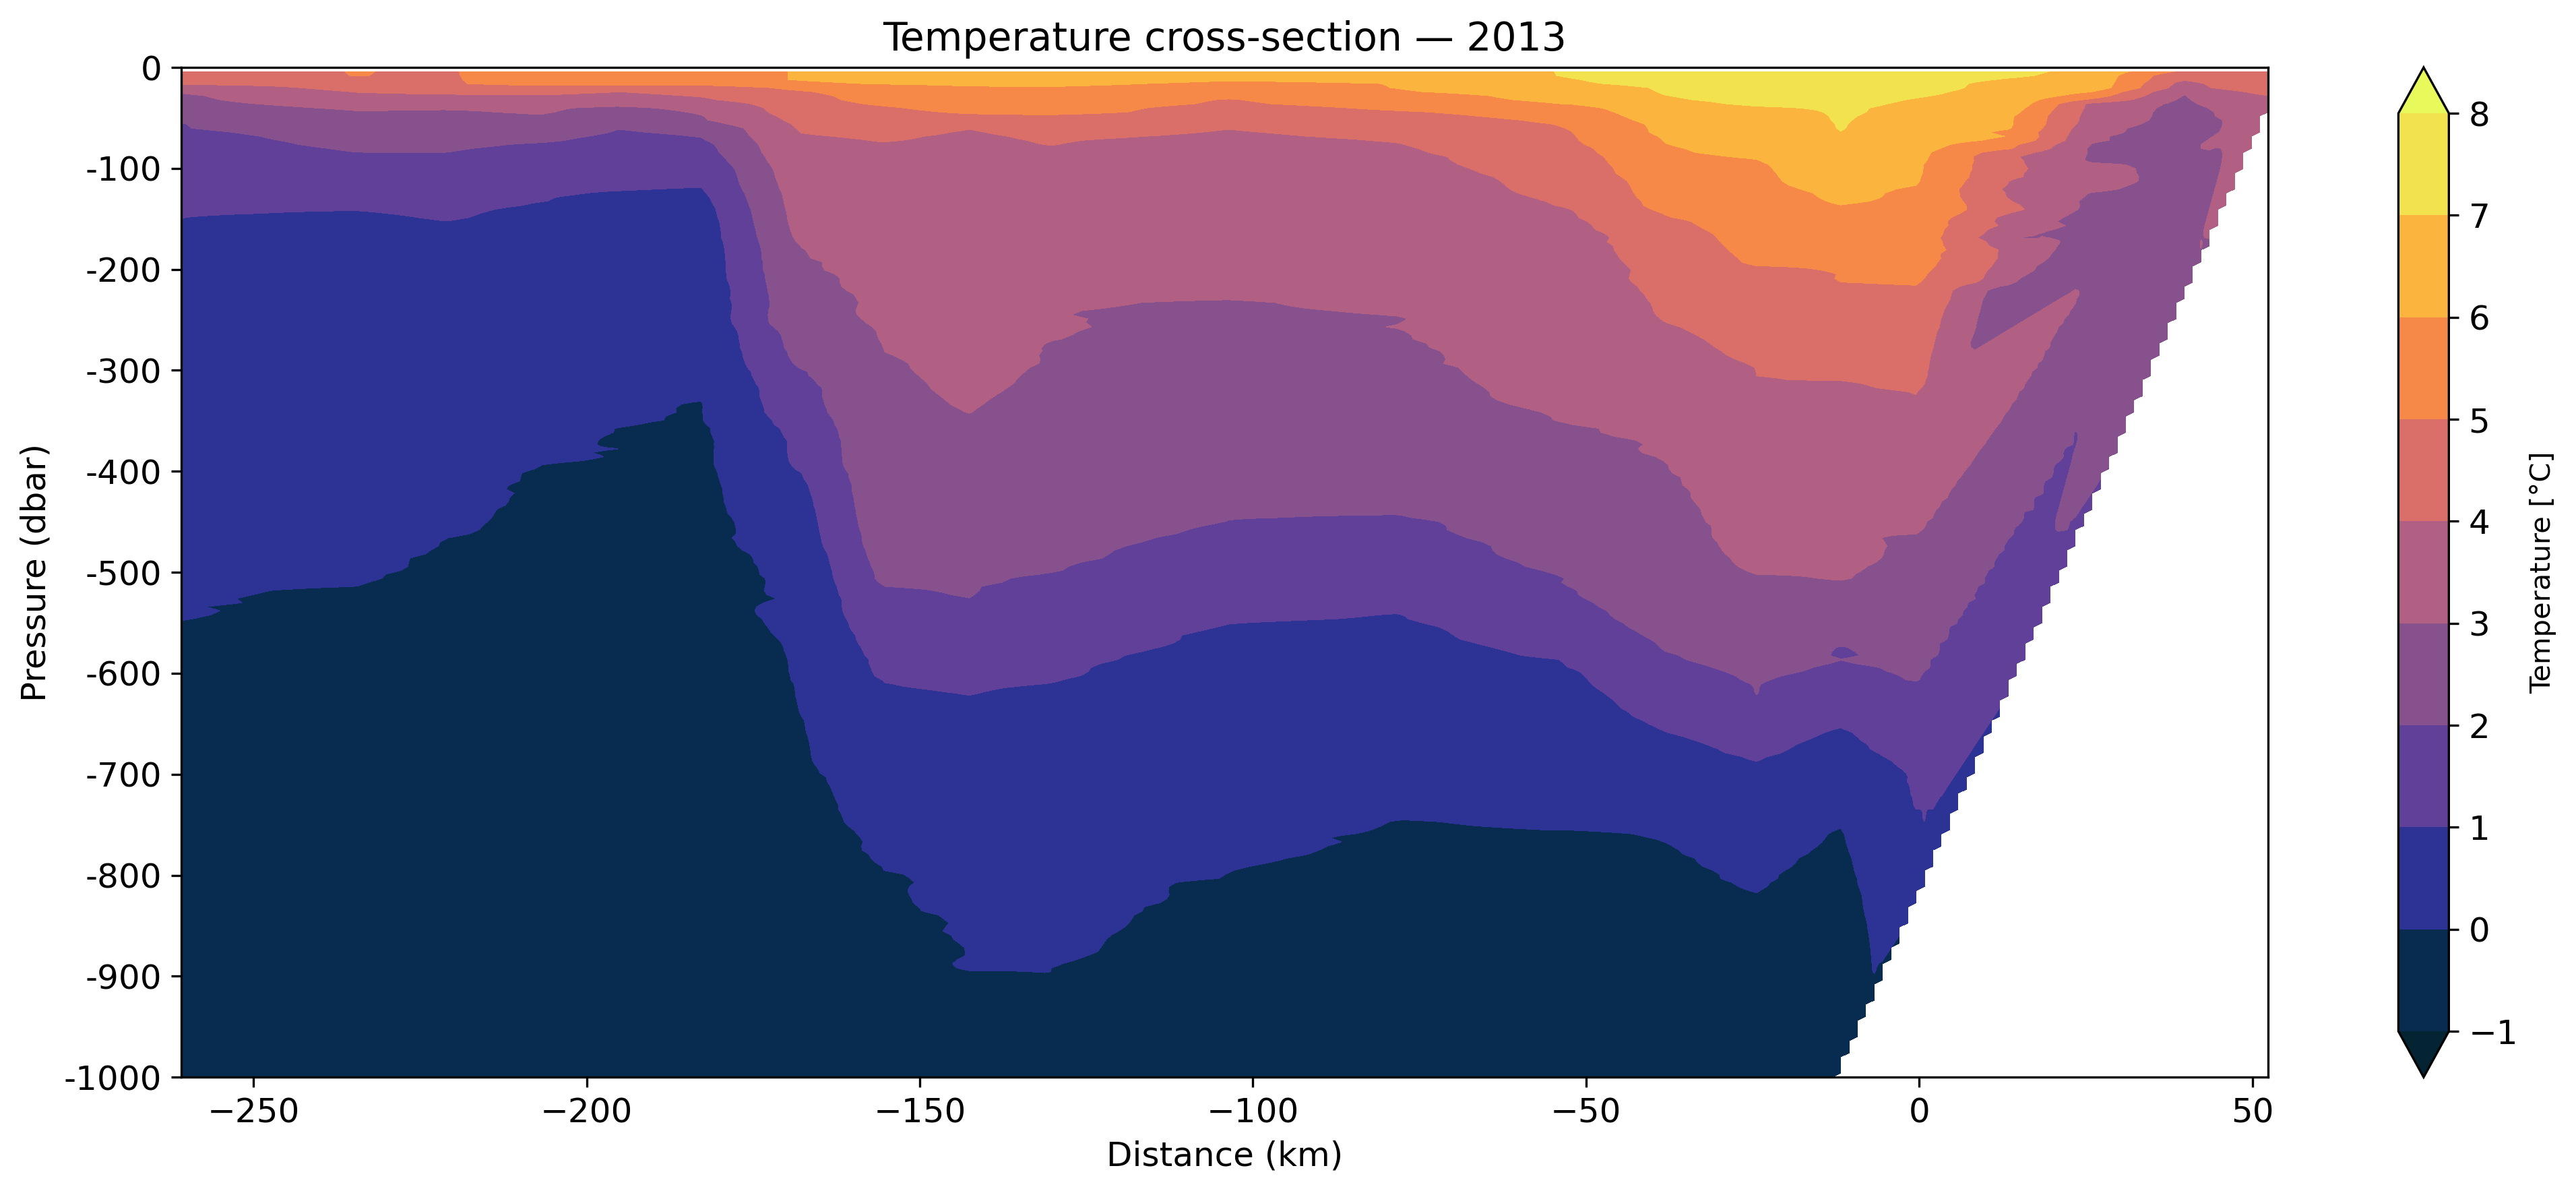

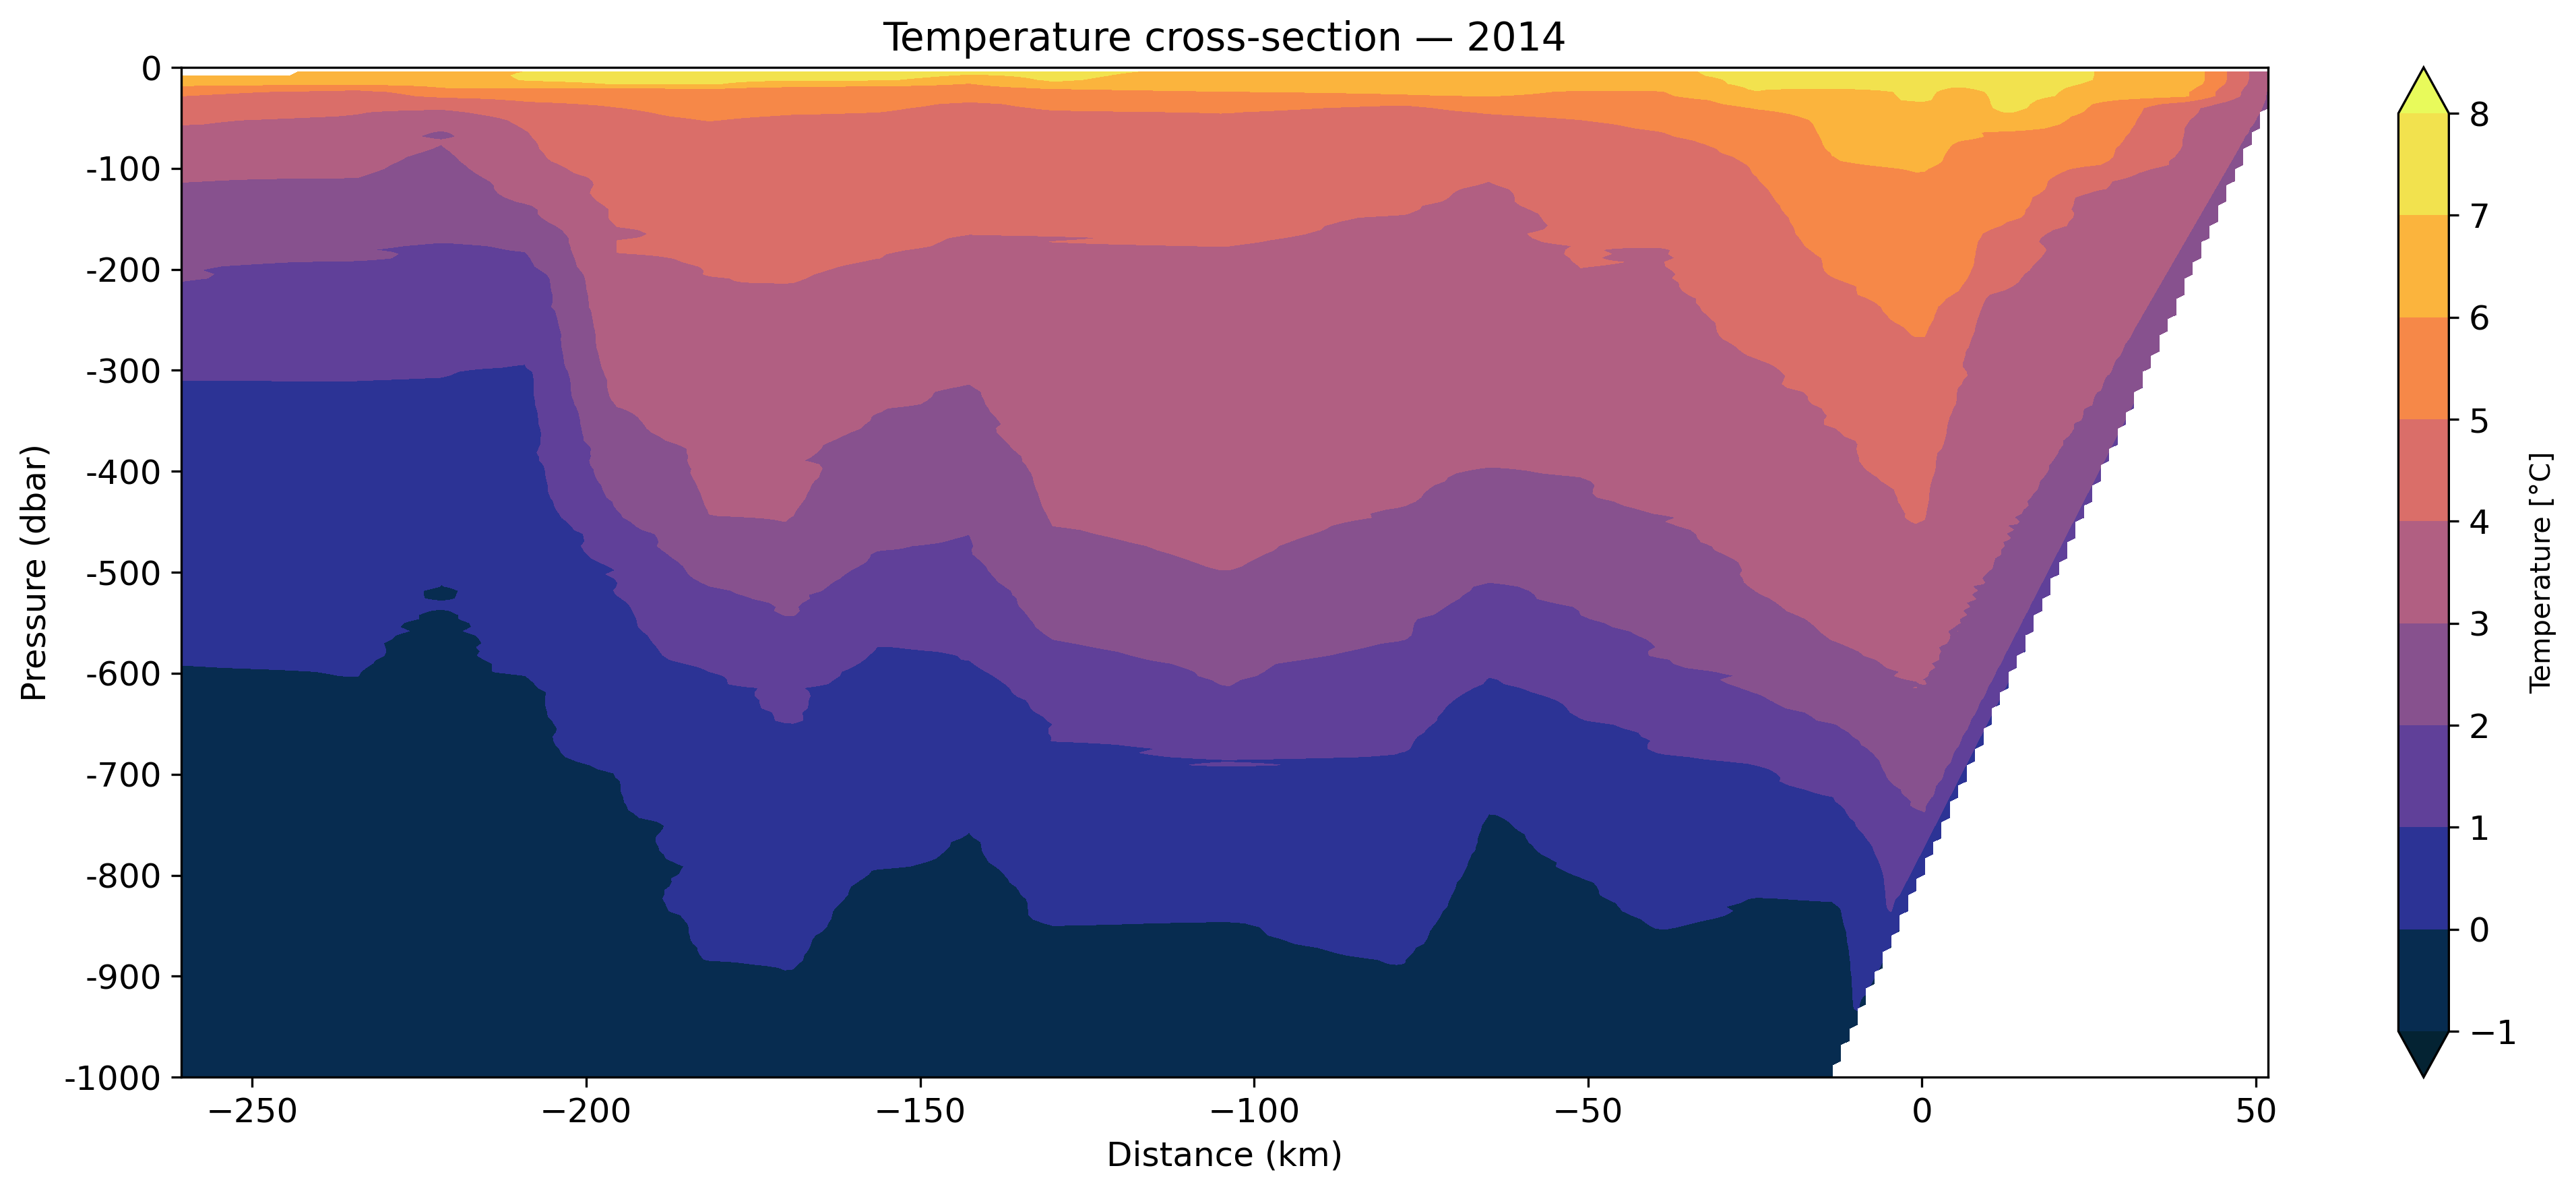

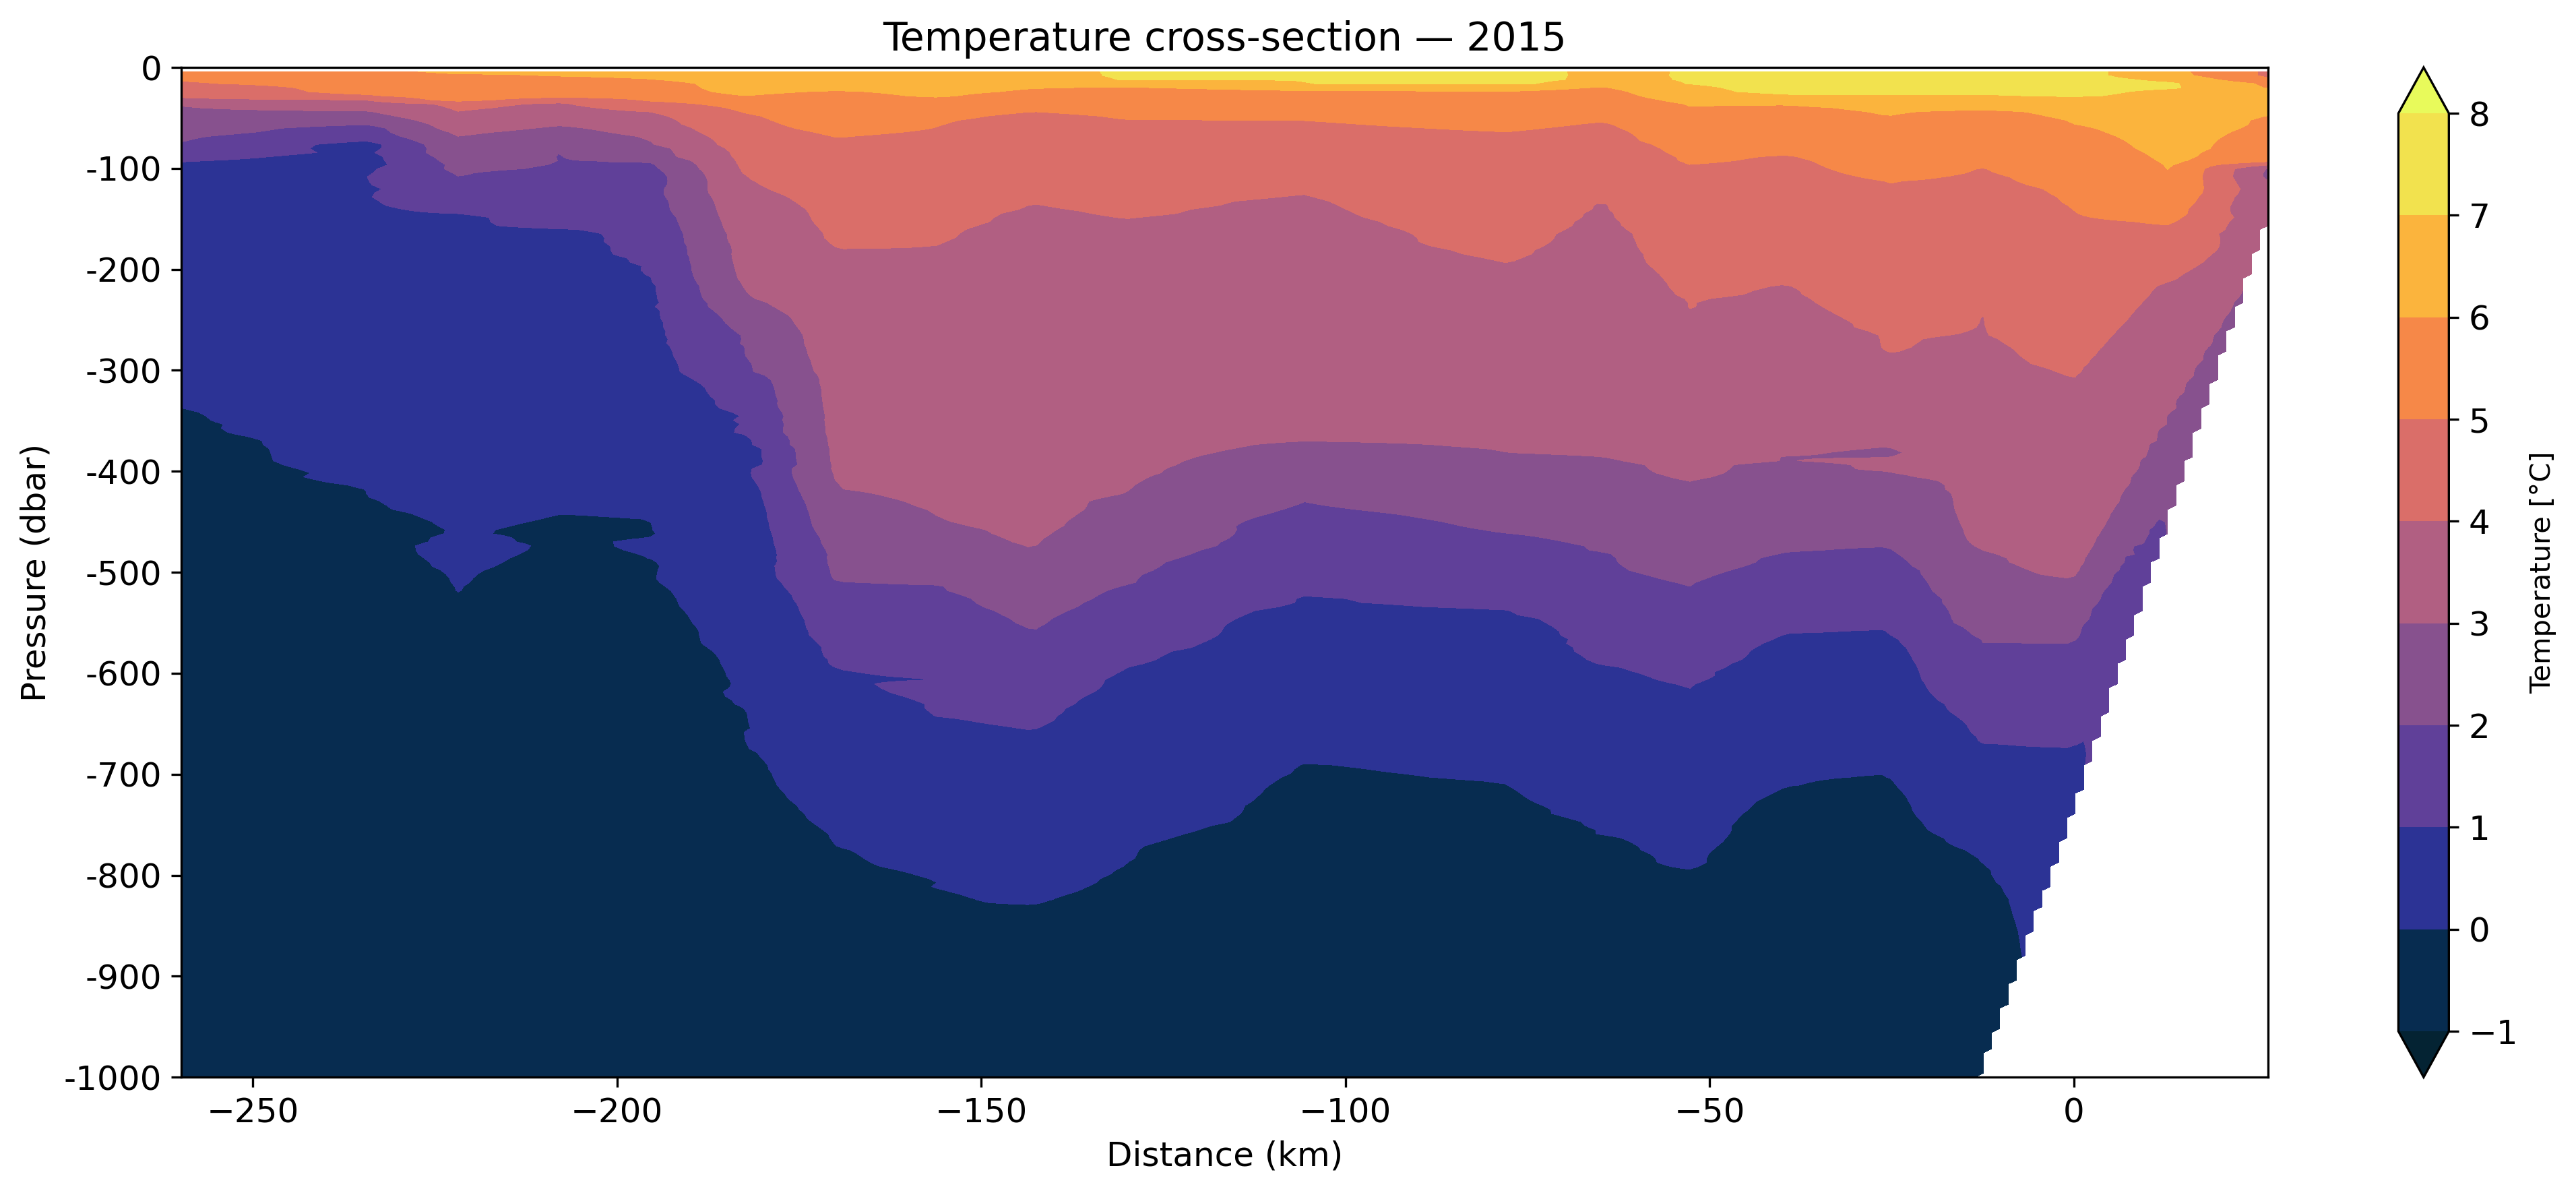

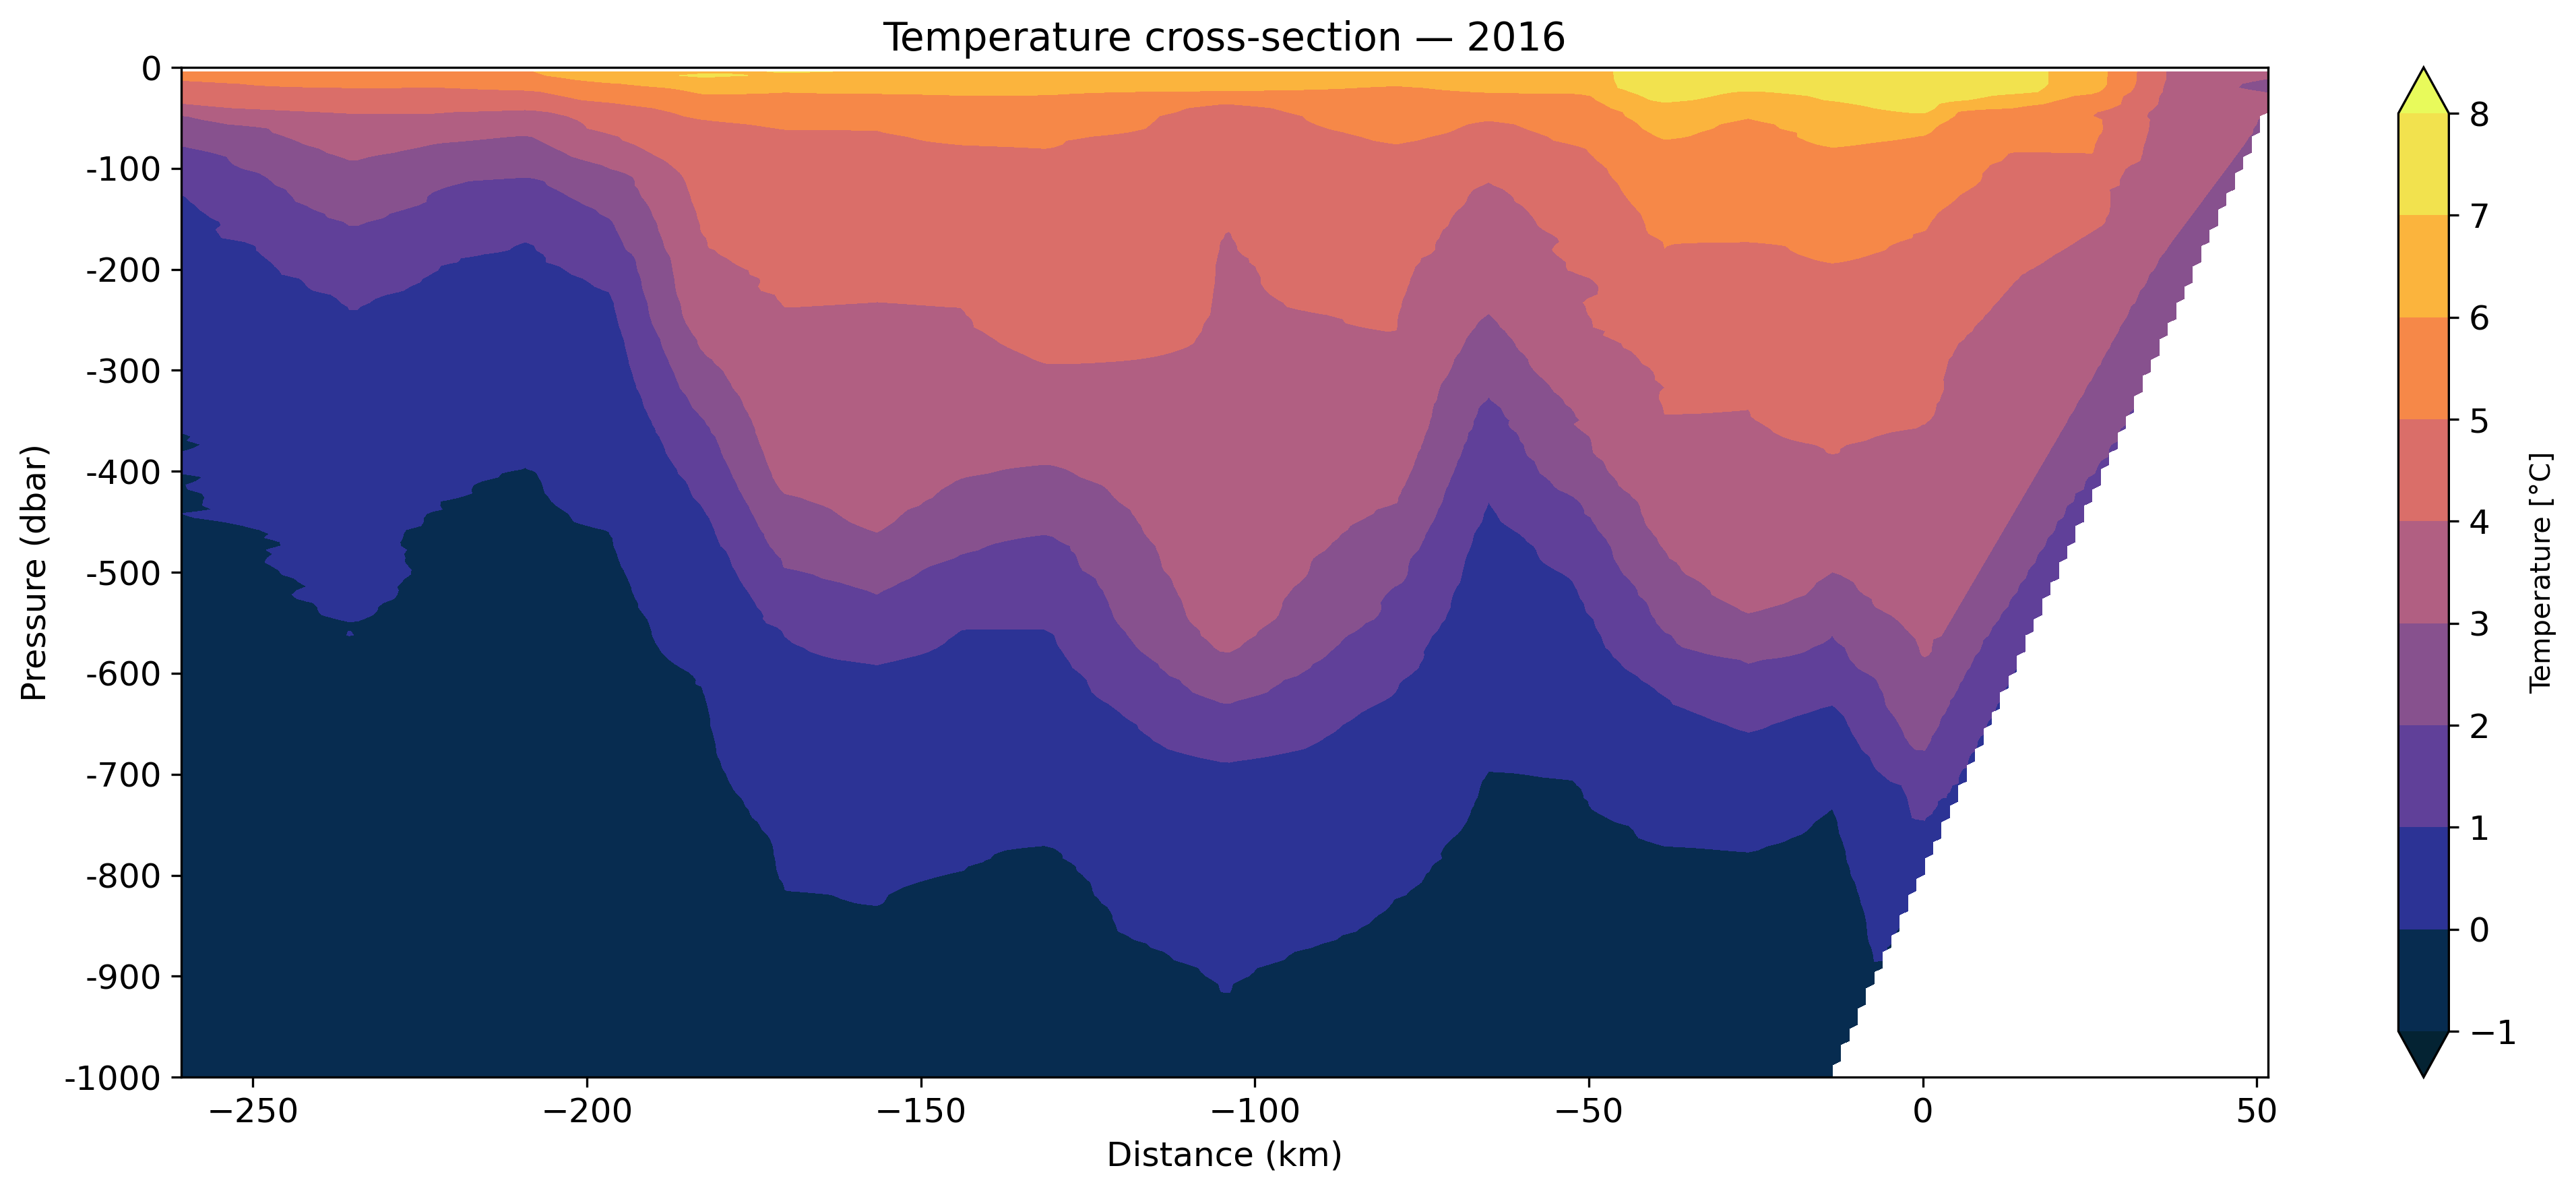

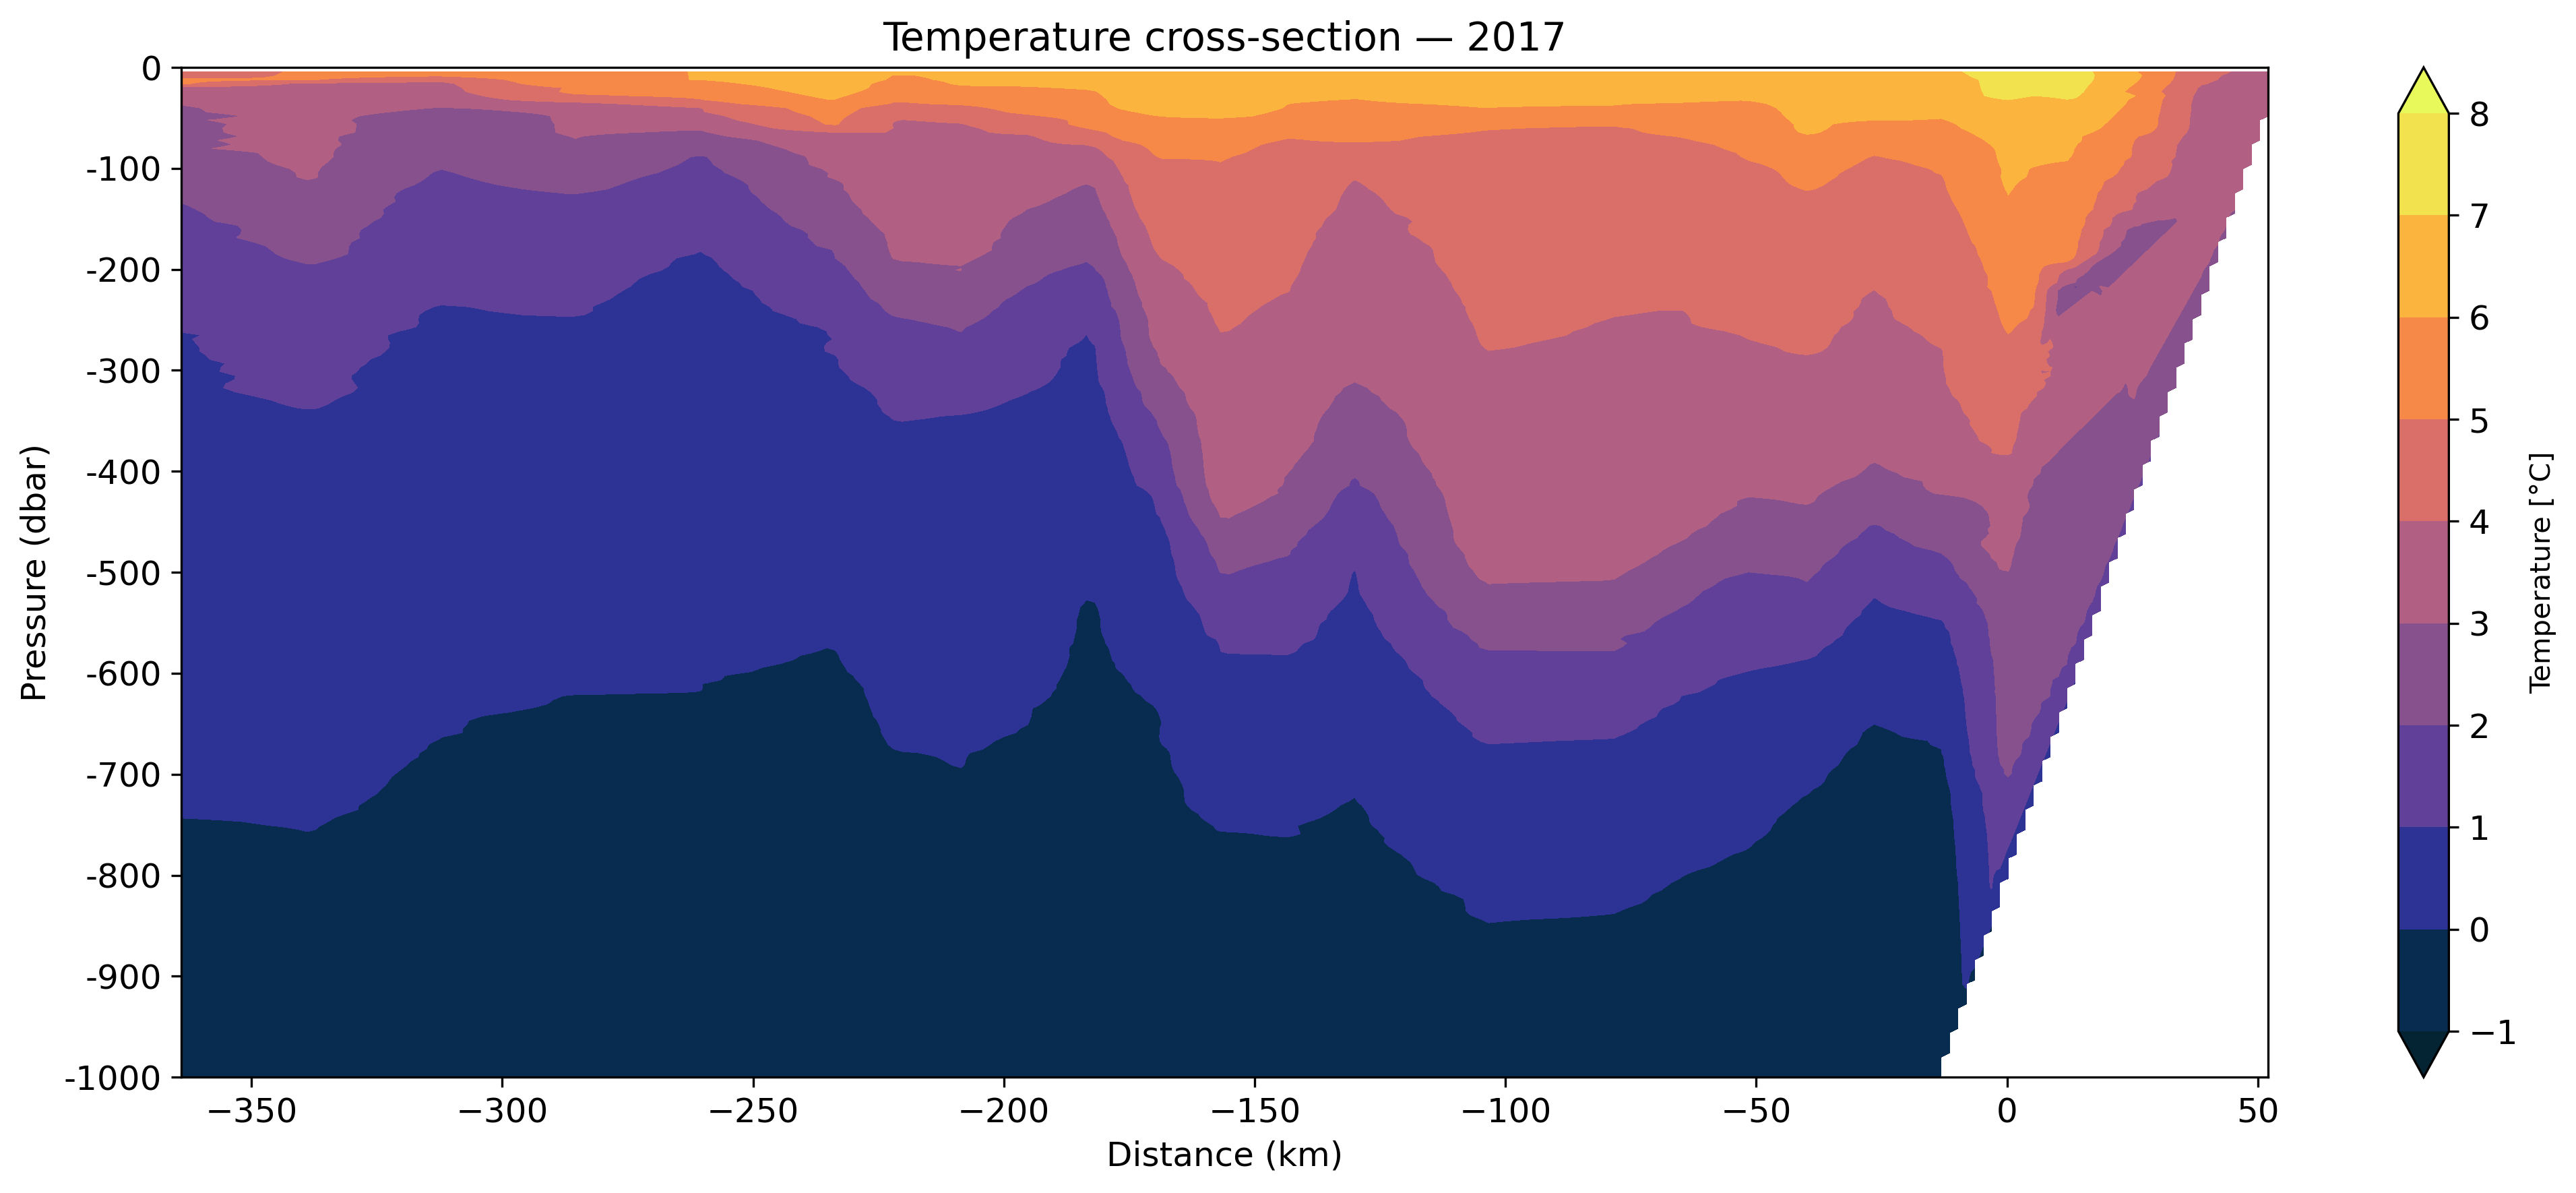

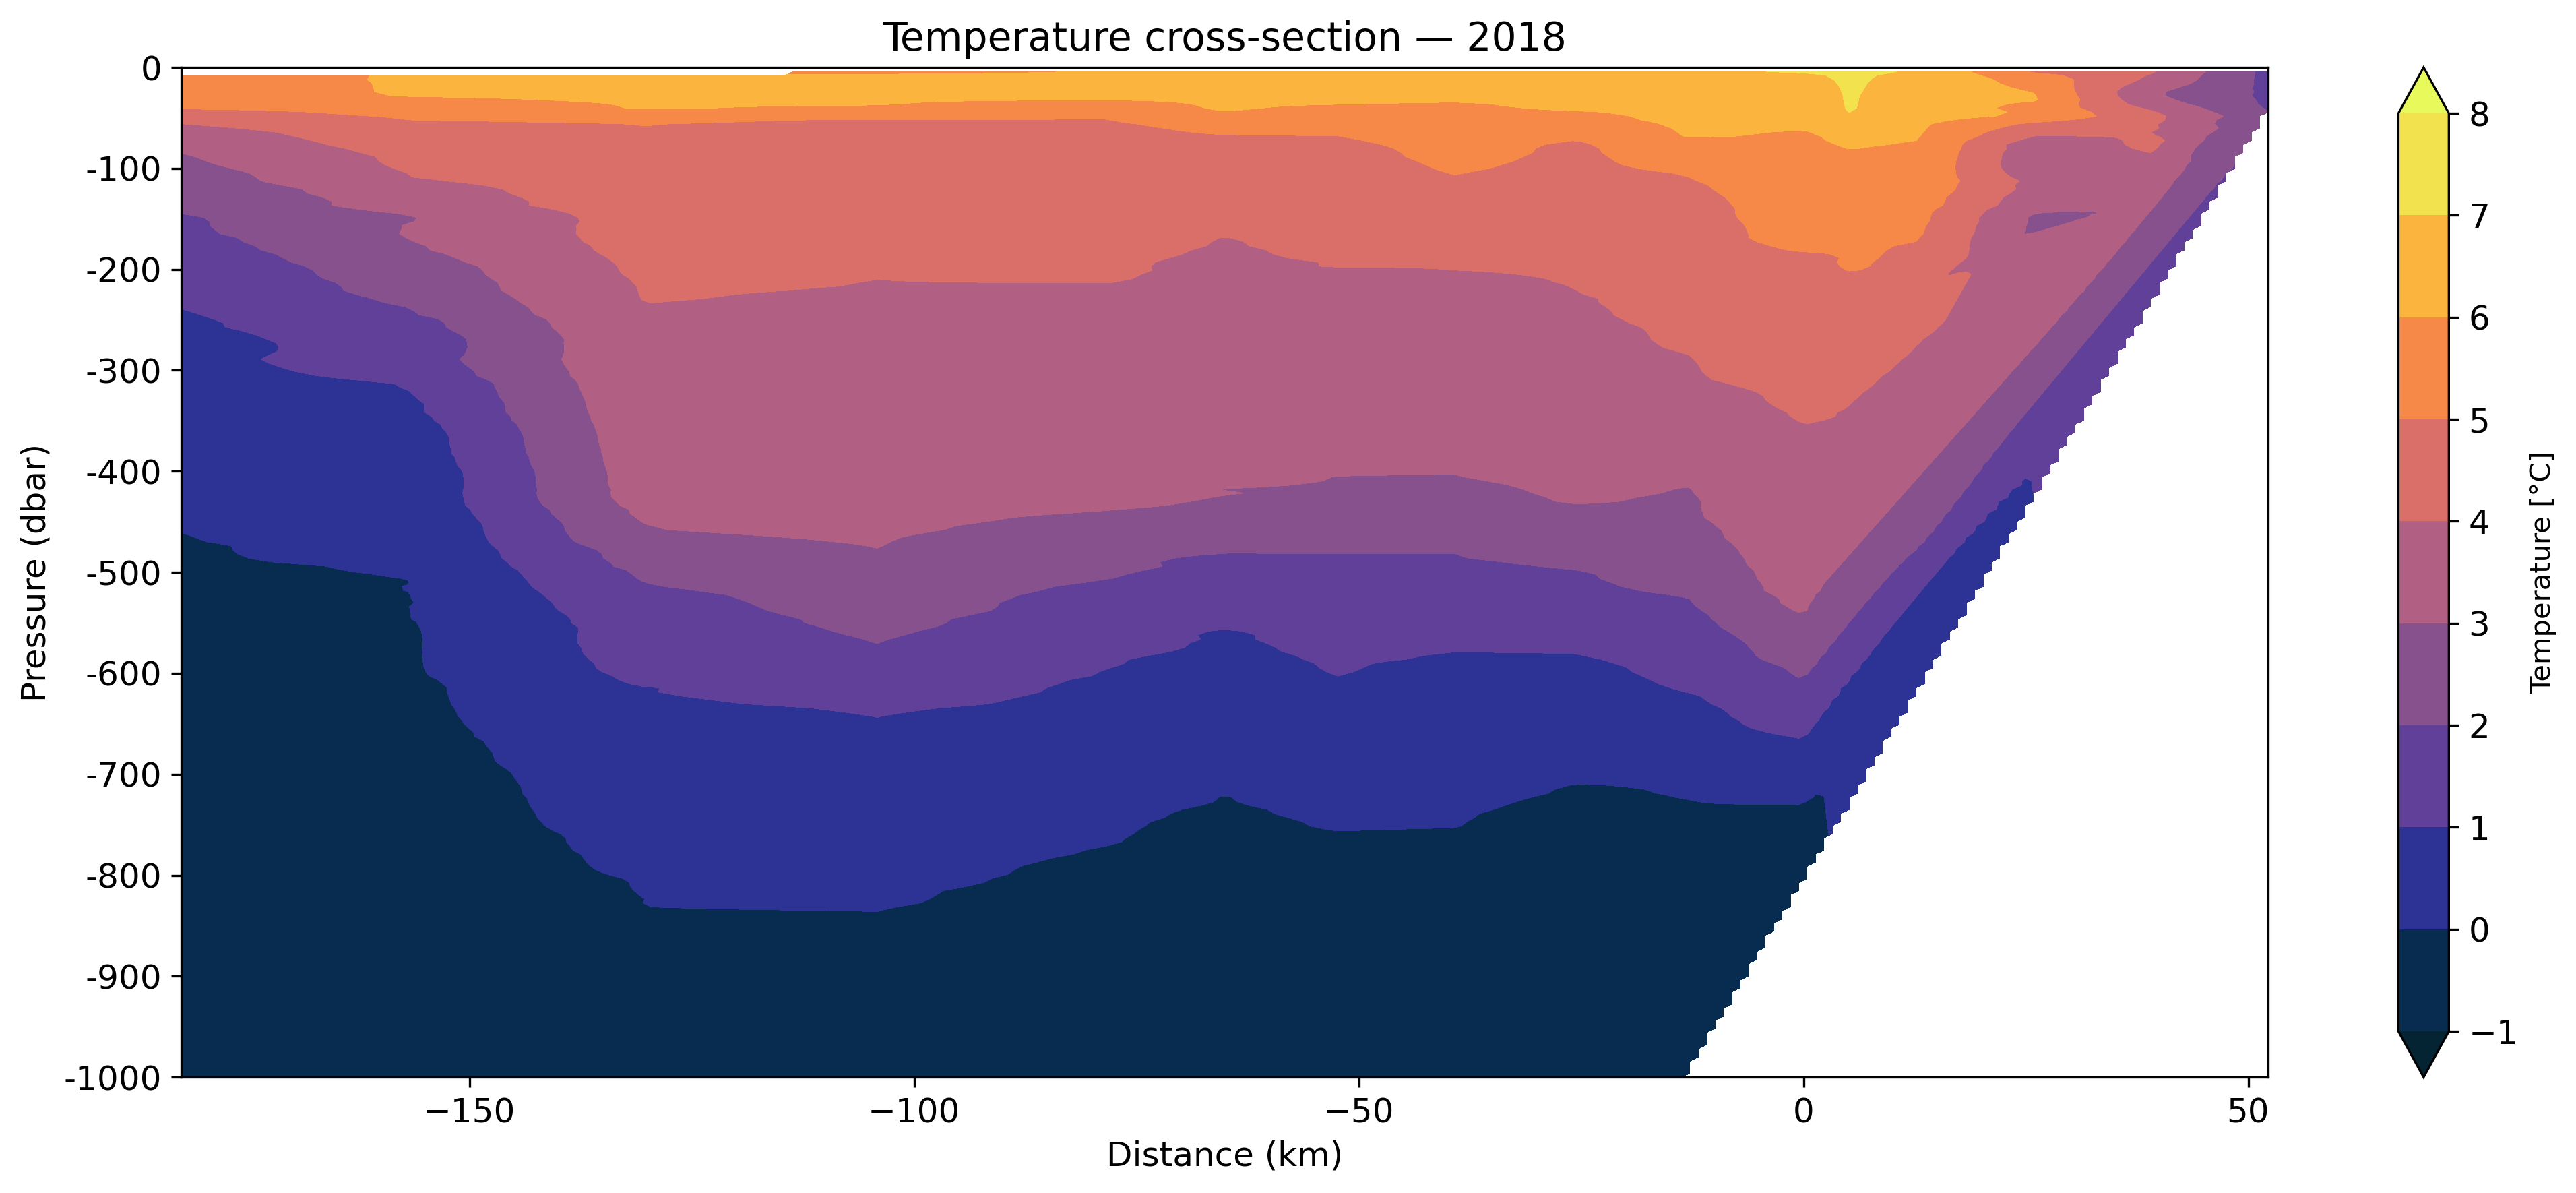

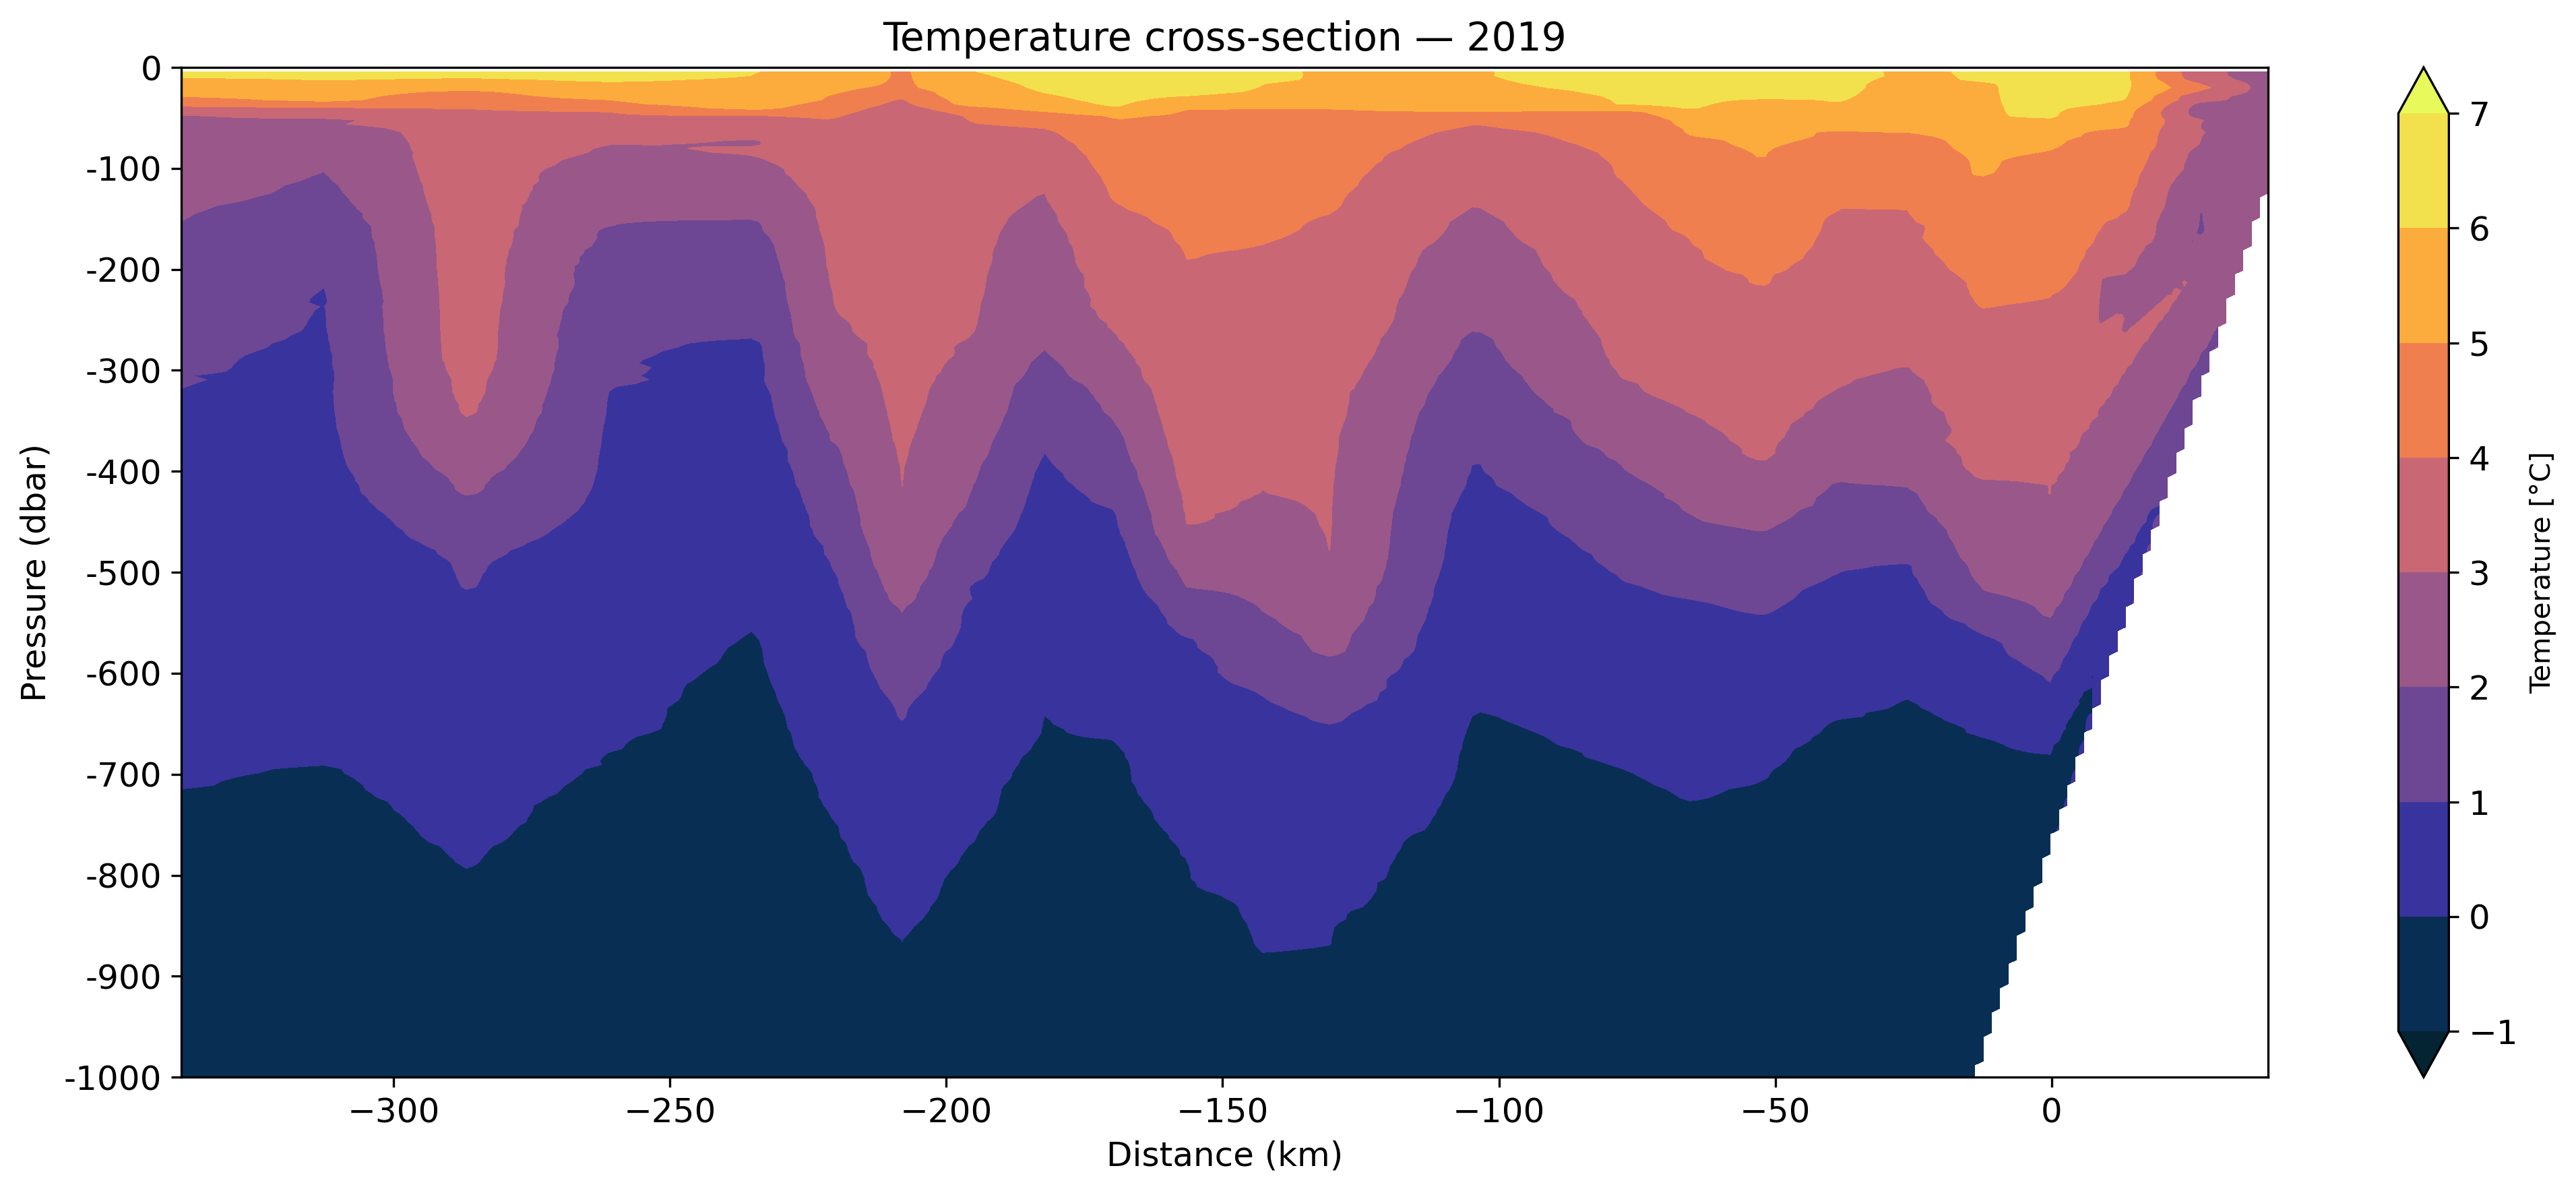

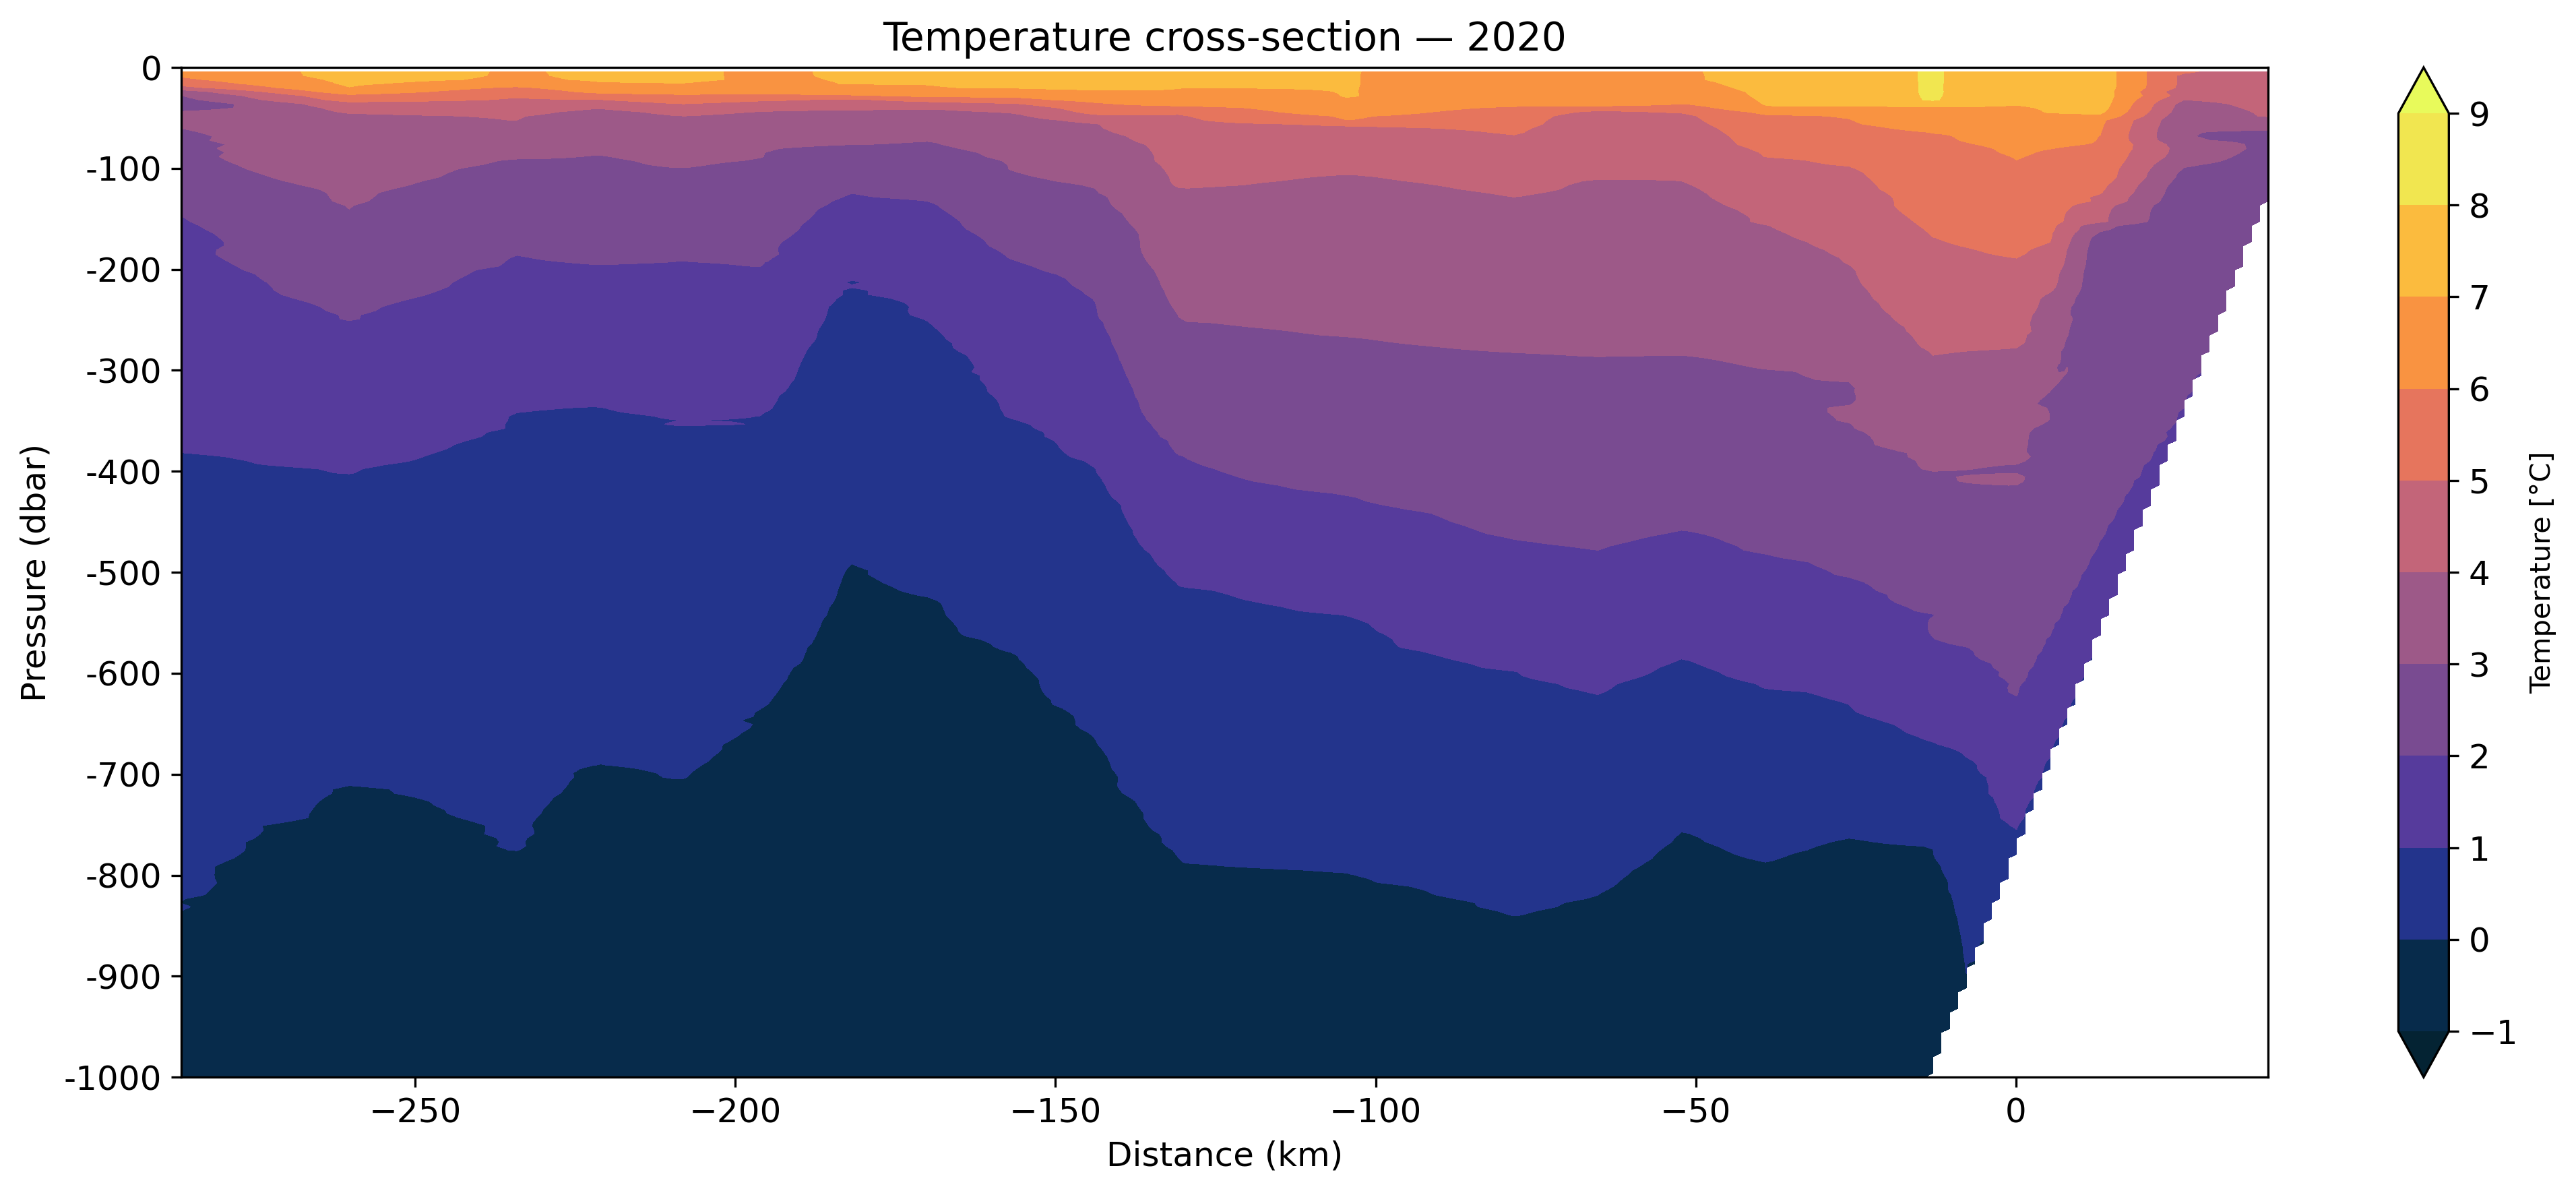

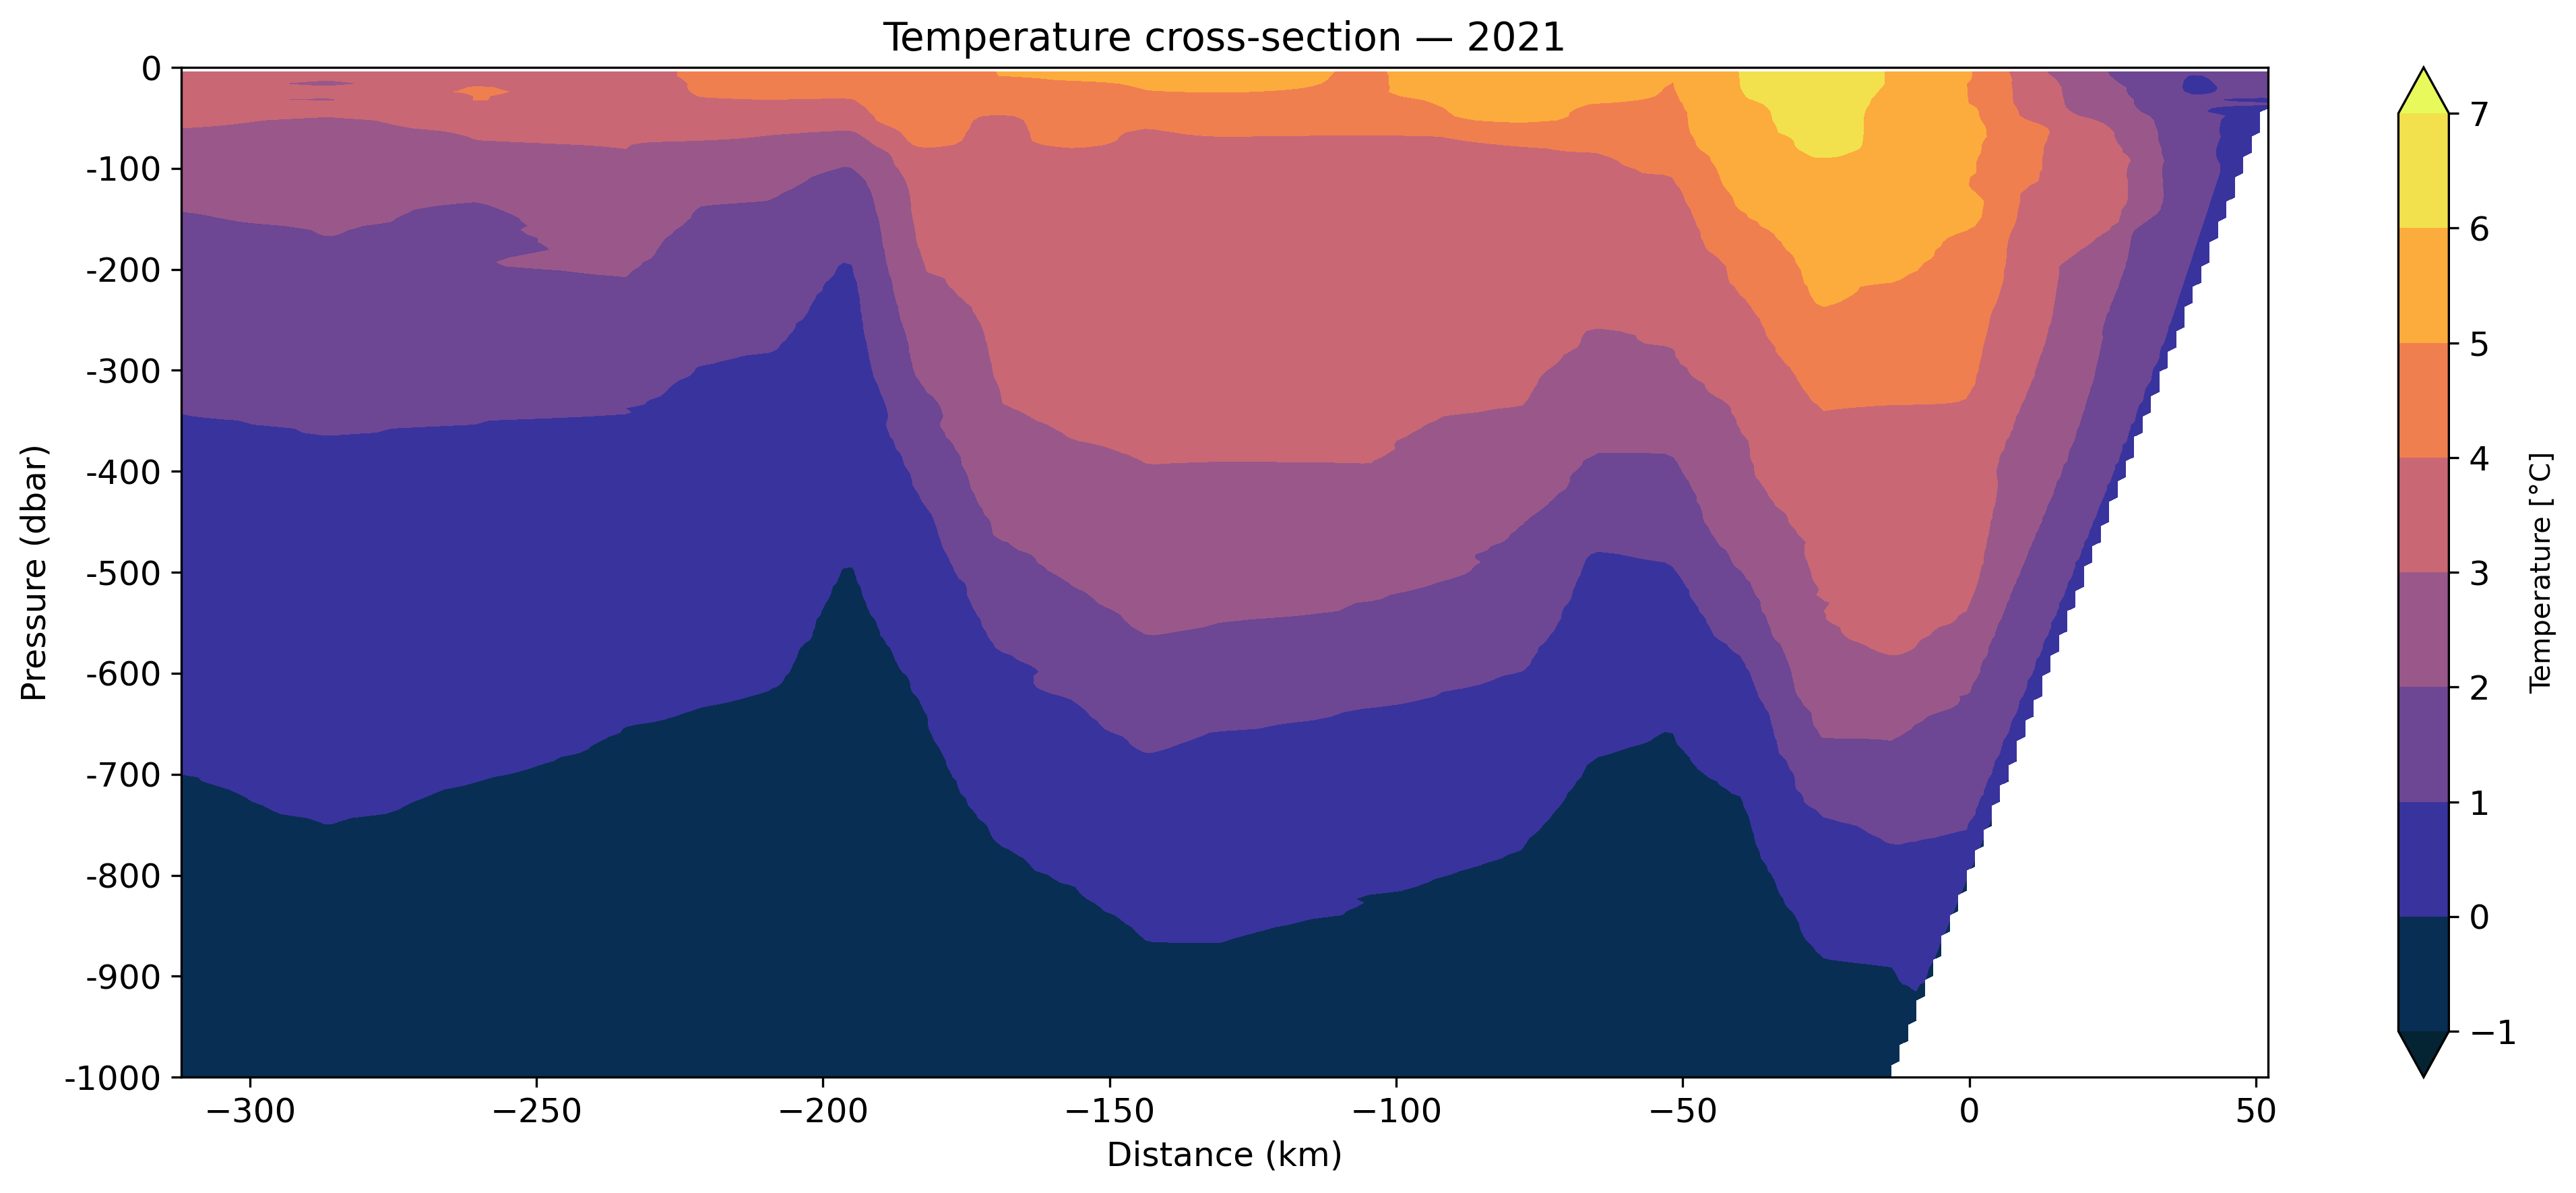

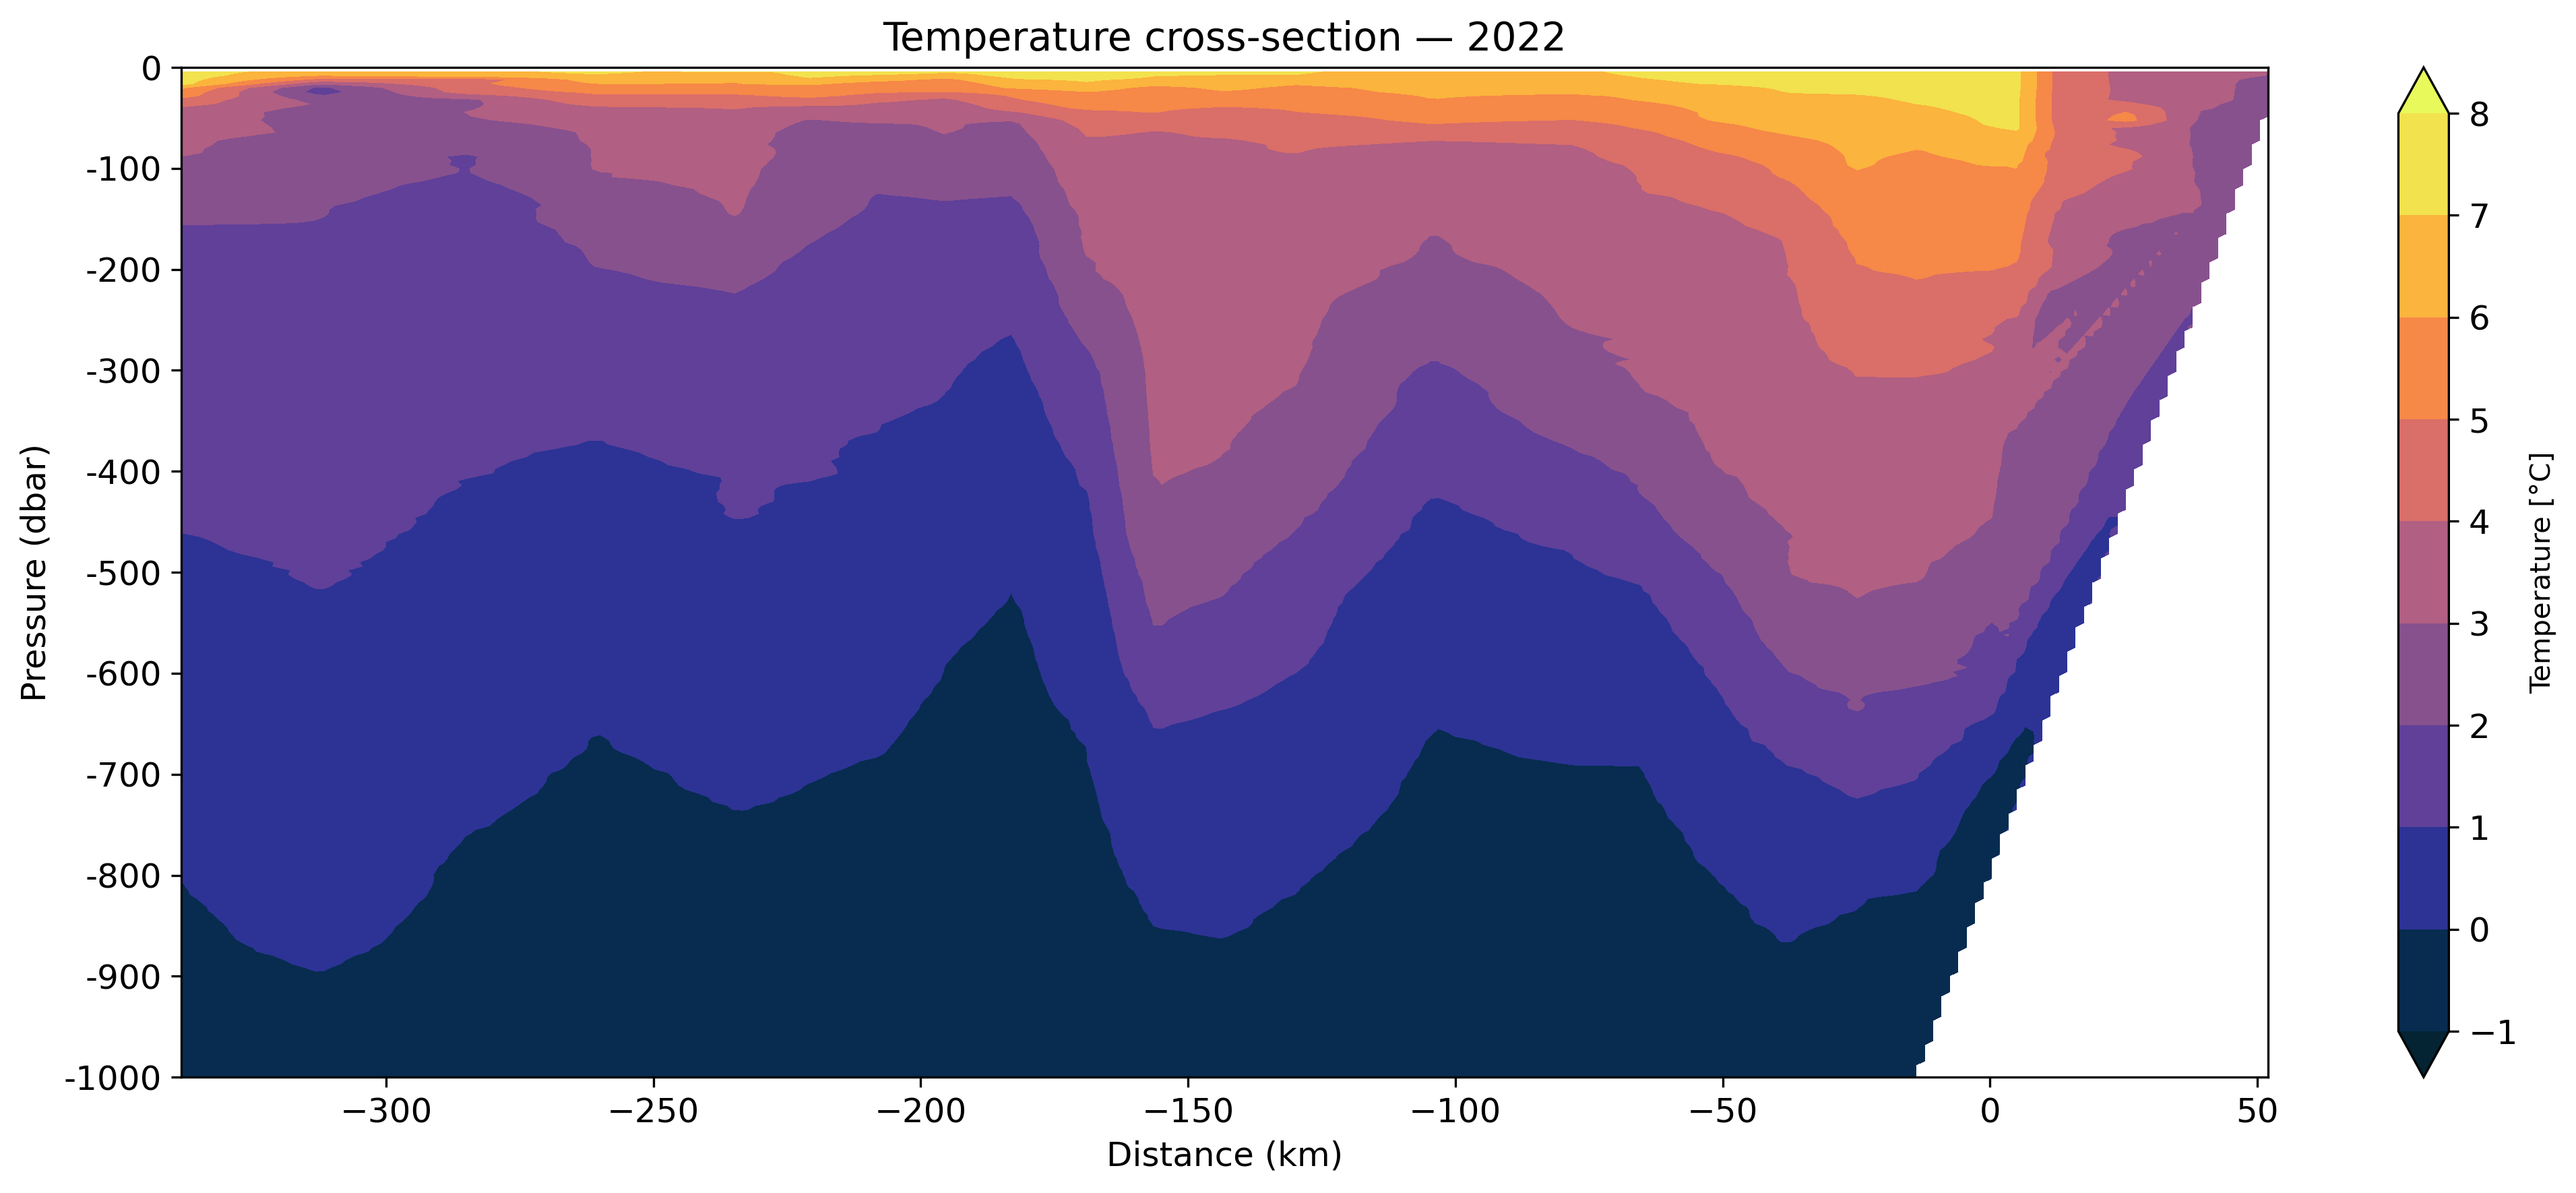

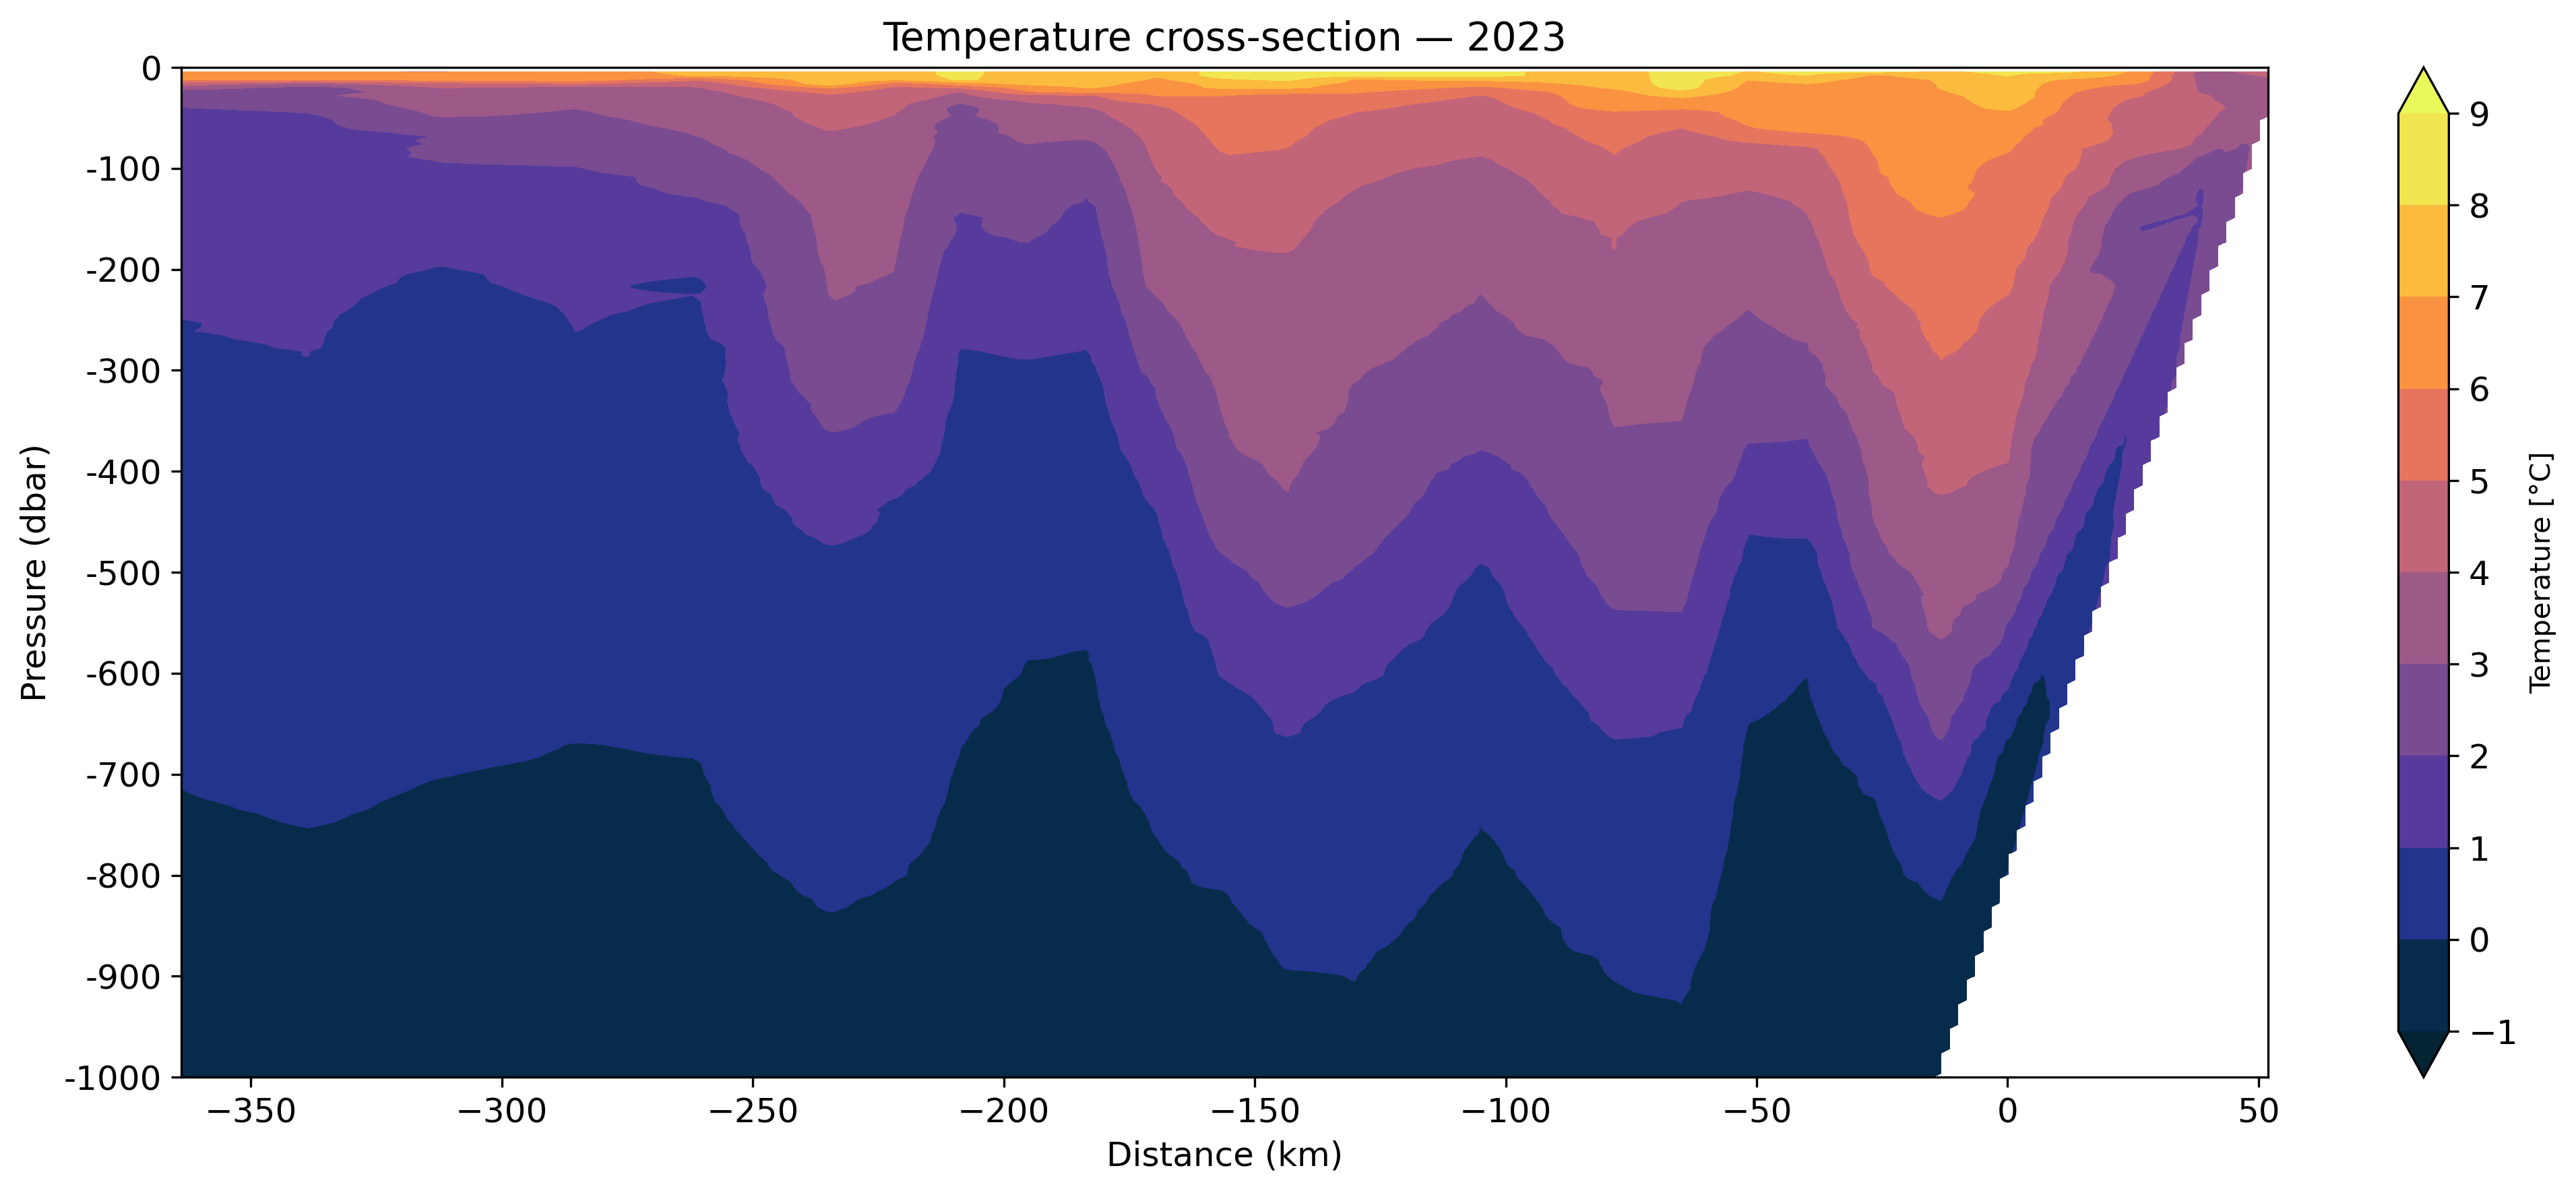

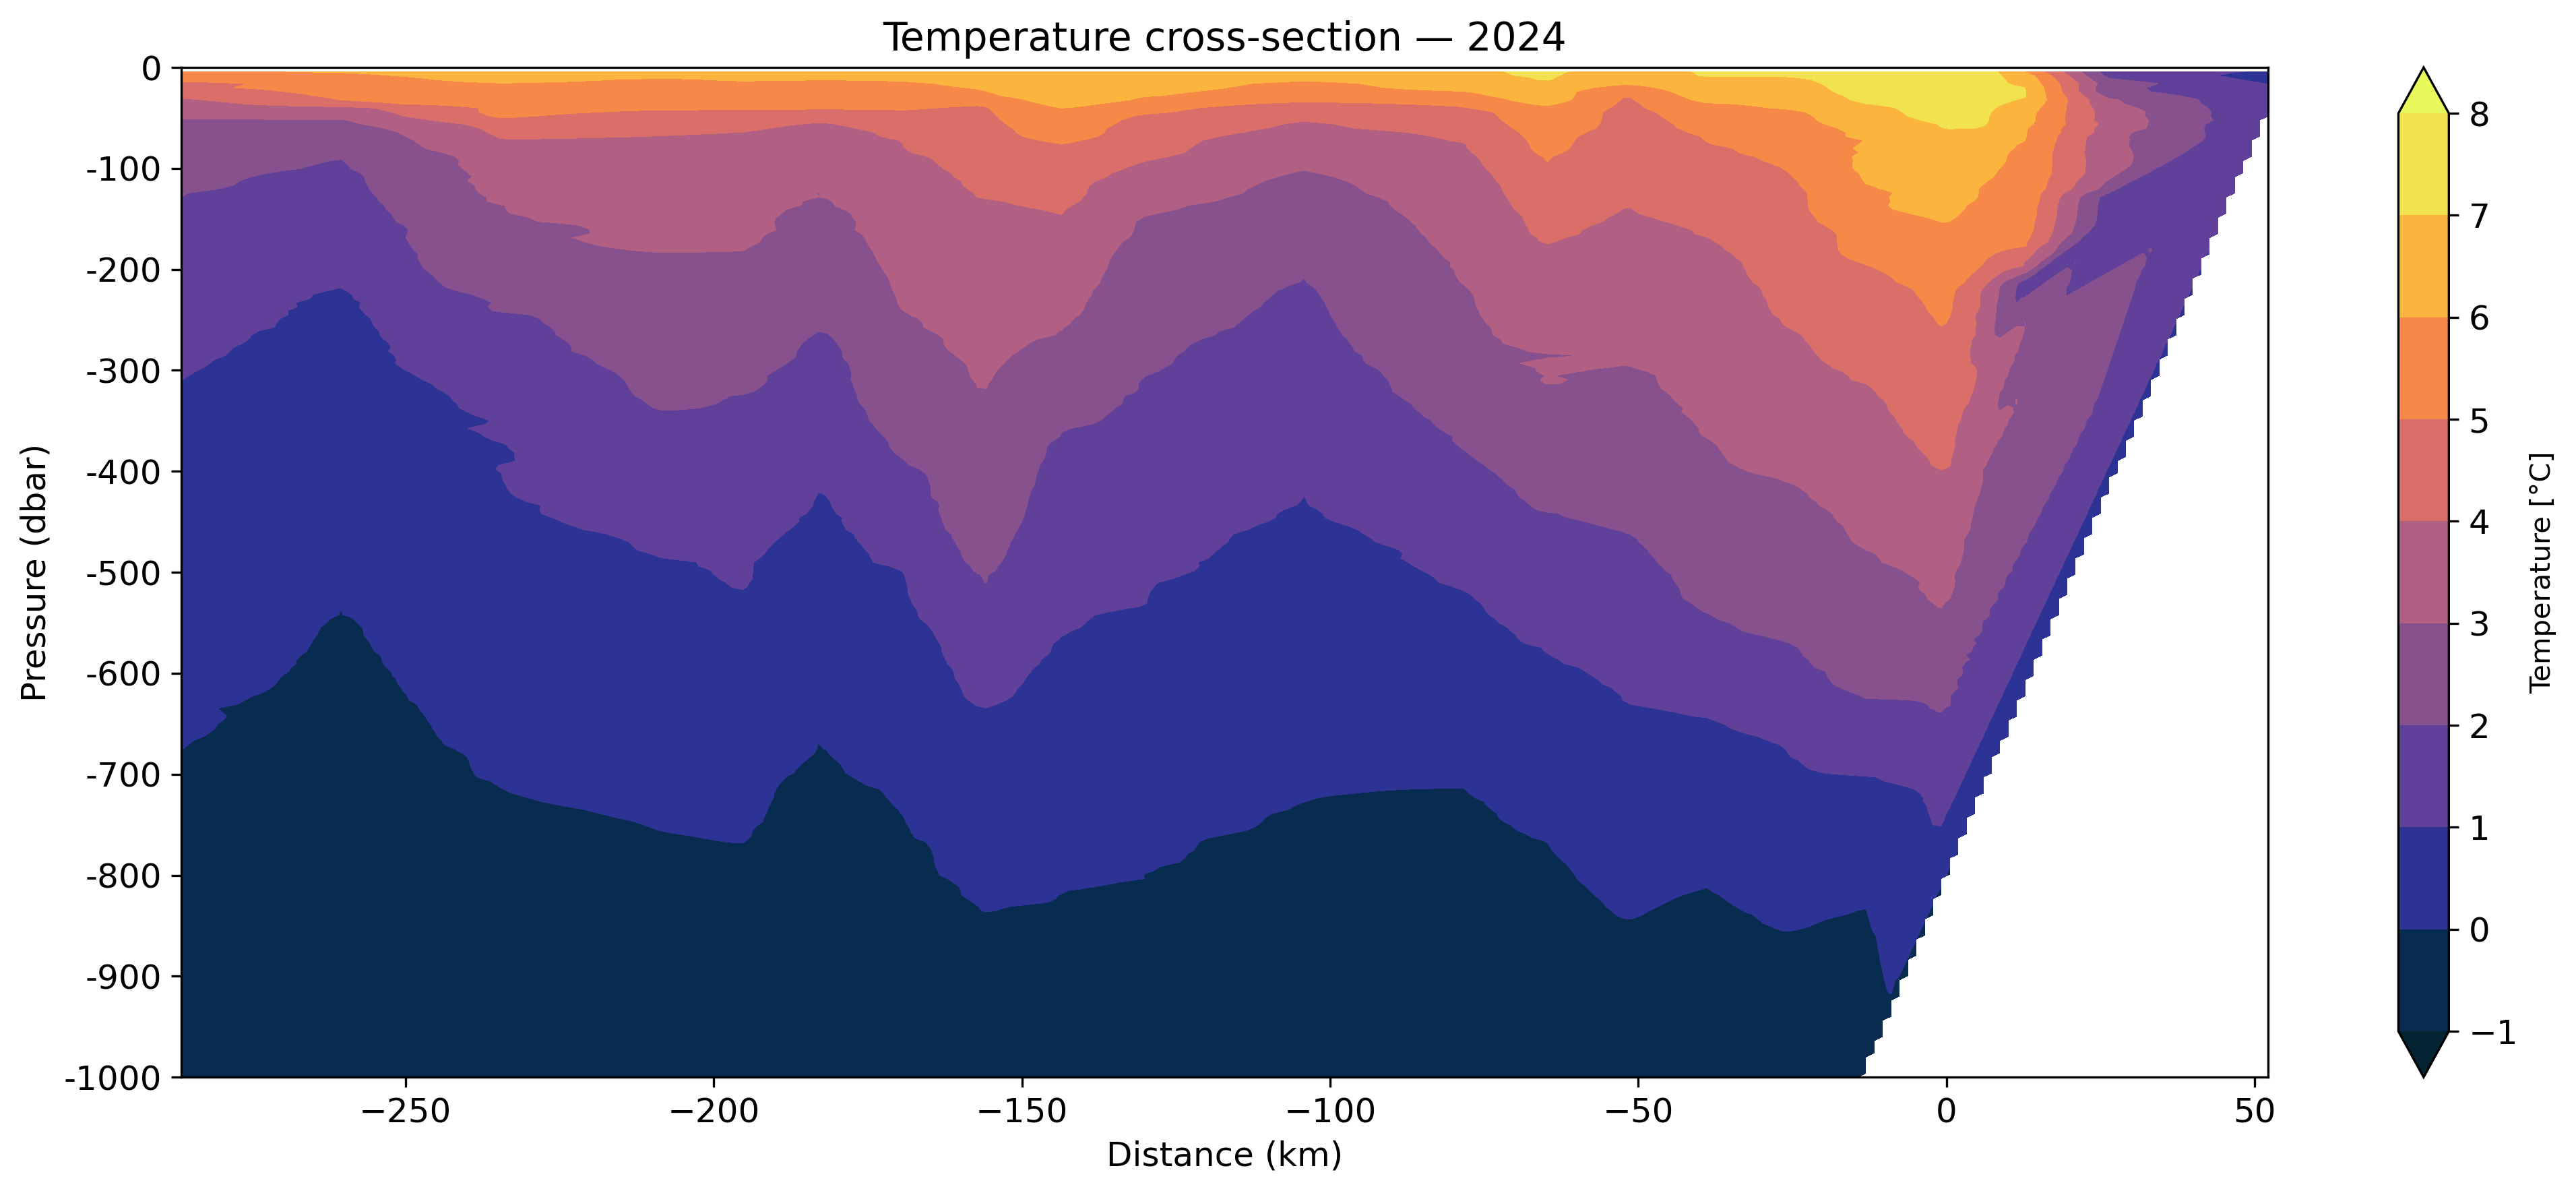

In [35]:
for year, df_year in stations_N_by_year.items():

    if df_year.empty:
        continue

    
    x = []
    y = []
    z = []

    # Grupowanie po stacjach
    grouped = df_year.groupby("station_name")

    for station, group in grouped:

        dist = group['distance_km'].iloc[0]

        pres = group['pres'].iloc[0]
        CT   = group['CT'].iloc[0]

        # Spłaszczenie profili
        pres = np.asarray(pres).flatten()
        CT   = np.asarray(CT).flatten()

        # Ograniczenie do 0–1000 dbar
        mask = pres <= 1000
        pres = pres[mask]
        CT   = CT[mask]

        n = len(pres)
        x.extend([dist] * n)
        y.extend(pres)
        z.extend(CT)

    # DataFrame z punktami
    data = pd.DataFrame({
        "x": x,
        "y": y,
        "z": z
    }).dropna()

    if data.empty:
        print(f"Brak danych do rysowania: {year}")
        continue

    # Siatka interpolacji
    xi = np.linspace(data['x'].min(), data['x'].max(), 250)
    yi = np.linspace(0, 1000, 250)

    X, Y = np.meshgrid(xi, yi)

    Z = griddata(
        (data['x'], data['y']),
        data['z'],
        (X, Y),
        method='linear'
    )

    # Skala temperatury co 1°C
    minT = np.floor(data['z'].min())
    maxT = np.ceil(data['z'].max())
    levels = np.arange(minT, maxT + 1, 1)

    
    fig_width  = 14  # cale
    fig_height = 6   # cale

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=300)

    cmap = cmocean.cm.thermal

    
    cf = ax.contourf(
        X, Y, Z,
        levels=levels,
        cmap=cmap,
        extend='both'
    )

    # Colorbar co 1°C
    cbar = plt.colorbar(cf, ax=ax, ticks=levels)
    cbar.set_label("Temperature [°C]")
    cbar.ax.tick_params(labelsize=12)

    
    ax.set_xlabel("Distance (km)", fontsize=12)
    ax.set_ylabel("Pressure (dbar)", fontsize=12)
    ax.set_title(f"Temperature cross-section — {year}", fontsize=14)

    ax.tick_params(labelsize=12)

    # Głębokość do 1000
    ax.set_ylim(1000, 0)  

# Ticki co 100 dbar 
    yticks = np.arange(0, 1001, 100)  
    ax.set_yticks(yticks)
    ax.set_yticklabels([-int(t) for t in yticks])




    plt.tight_layout()
    plt.show()
